## First things first
* Click **File -> Save a copy in Drive** and click **Open in new tab** in the pop-up window to save your progress in Google Drive.
* Click **Runtime -> Change runtime type** and select **GPU** in Hardware accelerator box to enable faster GPU training.

#**Final Project for Coursera's 'How to Win a Data Science Competition'**
April, 2020

Andreas Theodoulou and Michael Gaidis

(Competition Info last updated:  3 years ago)

##**About this Competition**

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

Evaluation: root mean squared error (RMSE). True target values are clipped into [0,20] range.

.

##**File descriptions**

***sales_train.csv*** - the training set. Daily historical data from January 2013 to October 2015.

***test.csv*** - the test set. You need to forecast the sales for these shops and products for November 2015.

***sample_submission.csv*** - a sample submission file in the correct format.

***items.csv*** - supplemental information about the items/products.

***item_categories.csv***  - supplemental information about the items categories.

***shops.csv***- supplemental information about the shops.

.

##**Data fields**

***ID*** - an Id that represents a (Shop, Item) tuple within the test set

***shop_id*** - unique identifier of a shop

***item_id*** - unique identifier of a product

***item_category_id*** - unique identifier of item category

***item_cnt_day*** - number of products sold. You are predicting a monthly amount of this measure

***item_price*** - current price of an item

***date*** - date in format dd/mm/yyyy

***month*** - a consecutive month number. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

***item_name*** - name of item

***shop_name*** - name of shop

***item_category_name*** - name of item category

#**Set Up Enviornment and Load Files**
Load competition data files, import python modules, and set up pandas environment options

###If data gets too big, use DASK for parallel computations and out-of-memory data residence by parquets

In [0]:
# # !pip install ipyparallel
# !pip install dask distributed #--upgrade   # Be sure to use the "dask distributed" and not "dask"... also, "--upgrade" seems to cause problems
# # !ipcluster start
# # !ipcluster start -n 4
# # no_engines = 4
# # !ipcluster start -n {no_engines} --daemonize  # daemonize forces it to work in background - otherwise ipynb hangs here -- will not work on windows (probably)

In [0]:
# from dask.distributed import Client, LocalCluster
# # errors here might come from using VPN, or $ipcluster start... or LocalCluster
# # cluster = LocalCluster()
# # client = Client(cluster)
# client = Client()
# client

In [0]:
# %%time
# # check the specifics of Google Colab resources
# #CPU only:
# # Client
# # Scheduler: tcp://127.0.0.1:41697
# # Dashboard: http://127.0.0.1:8787/status
# # Cluster
# # Workers: 4
# # Cores: 4
# # Memory: 27.39 GB

# #With GPU:
# # code doesn't work; can't get a client (above)

# #With TPU:
# # code doesn't work; can't get a client (above)

# # Single machine progress bar
# from dask.diagnostics import ProgressBar
# from dask import compute
# import dask.dataframe as dd
# import pandas as pd
# import numpy as np

# df = pd.DataFrame(np.random.choice(10, (1000, 4)), columns=list('ABCD'))
# ddf = dd.from_pandas(df, npartitions=4)
# with ProgressBar():
#     u=ddf.sum().compute()
# print(u)

###Name the files you wish to load

In [0]:
# List of the *data* files (path relative to GitHub branch), to be loaded into pandas DataFrames
data_files = [  
                "models_and_predictions/LGBMv1p3mg_uint16_submission.csv",
                "models_and_predictions/LGBMv4_submission.csv",
                "data_output/items_augmented.csv",
                "data_output/item_categories_augmented.csv",
                "data_output/shops_new.csv",
                "data_output/items_new.csv",
                "data_output/sales_train_cleaned.csv.gz",
                "data_output/sales_train_cln_mrg.csv.gz",
                "data_output/test_mrg.csv.gz",
                "readonly/final_project_data/test.csv.gz"
             ]


###Import Modules, Set Up Environment

In [0]:
# General python libraries/modules used throughout the notebook
import os
from itertools import product
from collections import OrderedDict
import re
import time
from time import sleep, localtime, strftime
import pickle

# Helpful packages for EDA, cleaning, data manipulation
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import numpy as np
from scipy import sparse   # for large dataframes
from numba import jit      # speedup for appropriate functions and datatypes (no sets, lists, dictionaries, string functions; use np arrays rather than pandas series or dataframes)
#  If you want Numba to throw an error if it cannot compile a function in a way that speeds up your code, pass the argument nopython=True (e.g. @jit(nopython=True))
from numba import vectorize  # speed up row-wise operations like .apply() --> https://pandas.pydata.org/pandas-docs/stable/user_guide/enhancingperf.html

# ML packages
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# !pip install catboost
# from catboost import CatBoostRegressor

# Pandas additional enhancements
pd.set_option('compute.use_bottleneck', False)  # speed up operation when using NaNs
pd.set_option('compute.use_numexpr', False)     # speed up boolean operations, large dataframes; DataFrame.query() and pandas.eval() will evaluate the subexpressions that can be evaluated by numexpr

# Notebook formatting
# Adjust as per your preferences.  
# I'm using a FHD monitor with a full-screen browser window containing my IPynb
# format pandas output so we can see all the columns we care about 
# (instead of "col1  col2  ........ col8 col9", we will see 
# "col1 col2 col3 col4 col5 col6 col7 col8 col9" if it fits inside display.width)
pd.set_option("display.max_rows",100)     # Override pandas choice of how many rows to show, so we can see the full 84-row item_category df instead of '...' in the middle
pd.set_option("display.max_columns",30)   # Similar to row code above, we can show more columns than default
pd.set_option("display.width", 250)       # Tune this to our monitor window size to avoid horiz scroll bars in output windows (but, will get output text wrapping)
pd.set_option("max_colwidth", None)       # This is done, for example, so we can see full item name and not '...' in the middle
# pd.set_option("display.precision", 3)     # Nah, this is helpful, but below is even better
#Tell pandas to print without decimal places if a number is actually an integer, and use 3 decimals if a float (helps keep column width down, and highlights data types)
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.3f}'.format(x)

###Load the files into pandas dataframes, from Google Drive local repo

In [6]:
# click on the URL link presented to you by this command, get your authorization code from Google, then paste it into the input box and hit 'enter' to complete mounting of the drive
from google.colab import drive  
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [91]:
'''
############################################################
############################################################
'''
# Replace this path with the path on *your* Google Drive where the repo master branch is stored
#   (on GitHub, the remote repo is located at github.com/migai/Kag --> below is my cloned repo location)
GDRIVE_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag"
'''
############################################################
############################################################
'''

%cd "{GDRIVE_REPO_PATH}"

print("Loading Files from Google Drive repo into Colab...\n")

# Loop to load the data files into appropriately-named pandas DataFrames
for path_name in data_files:
    filename = path_name.rsplit("/")[-1]
    data_frame_name = filename.split(".")[0]
    exec(data_frame_name + " = pd.read_csv(path_name)")
    print(f'Data Frame: {data_frame_name}; n_rows = {len(eval(data_frame_name))}, n_cols = ',end="")
    print(f'{len(eval(data_frame_name).columns)}\n') #\nData Types: {eval(data_frame_name).dtypes}\n')
    print(eval(data_frame_name).head(2))
    print("\n")


/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag
Loading Files from Google Drive repo into Colab...

Data Frame: LGBMv1p3mg_uint16_submission; n_rows = 214200, n_cols = 2

   ID  item_cnt_month
0   0           0.713
1   1           0.049


Data Frame: LGBMv4_submission; n_rows = 214200, n_cols = 2

   ID  item_cnt_month
0   0           0.295
1   1           0.113


Data Frame: items_augmented; n_rows = 22170, n_cols = 5

   item_id  item_category_id                                                              item_name  item_tested                                                          delim_name_list
0        0                40                                           ! POWER IN glamor (PLAST.) D        False                                      ['power in glamor', 'plast', 'dvd']
1        1                76  ! ABBYY FineReader 12 Professional Edition Full [PC, Digital Version]        False  ['abbyy finereader 12 professional edition full', 'pc digital v

###Comparing 8/10 coursera grade submission with 5/10 submission

In [54]:
# inspect the difference between a 5/10 grade submission and an 8/10
LGBMv4_submission.rename(columns={"item_cnt_month":'sales8'},inplace=True)
LGBMv1p3mg_uint16_submission.rename(columns={"item_cnt_month":'sales5'},inplace=True)
submissions8and5 = LGBMv4_submission.merge(LGBMv1p3mg_uint16_submission, on='ID', how='outer').reset_index(drop=True)
submissions8and5['diff'] = submissions8and5.sales8 - submissions8and5.sales5
submissions8and5['diffpct'] = submissions8and5.apply(lambda row: 100*(row.sales8 - row.sales5)/max(row.sales8,row.sales5), axis=1)
submissions8and5 = submissions8and5.merge(test, on='ID', how='left').reset_index(drop=True)
submissions8and5 = submissions8and5.merge(items_augmented[['item_id','item_name']], on='item_id', how='left').reset_index(drop=True)
print(submissions8and5.describe())
print(submissions8and5.head())

               ID  sales8  sales5   diff  diffpct  shop_id    item_id
count      214200  214200  214200 214200   214200   214200     214200
mean  107,099.500   0.221   0.220  0.000   -1.942   31.643 11,019.399
std    61,834.358   0.617   0.654  0.263   49.310   17.562  6,252.645
min             0       0   0.018 -7.910 -100.000        2         30
25%    53,549.750   0.040   0.048 -0.037  -43.956       16  5,381.500
50%   107,099.500   0.102   0.054 -0.007   -8.511   34.500      11203
75%   160,649.250   0.167   0.174  0.058   49.626       47 16,071.500
max        214199      20      20 10.893   98.682       59      22167
   ID  sales8  sales5   diff  diffpct  shop_id  item_id                                                      item_name
0   0   0.295   0.713 -0.418  -58.638        5     5037                                NHL 15 [PS3, Russian subtitles]
1   1   0.113   0.049  0.064   56.602        5     5320                                 ONE DIRECTION Made In The A.M.
2   2   0.546

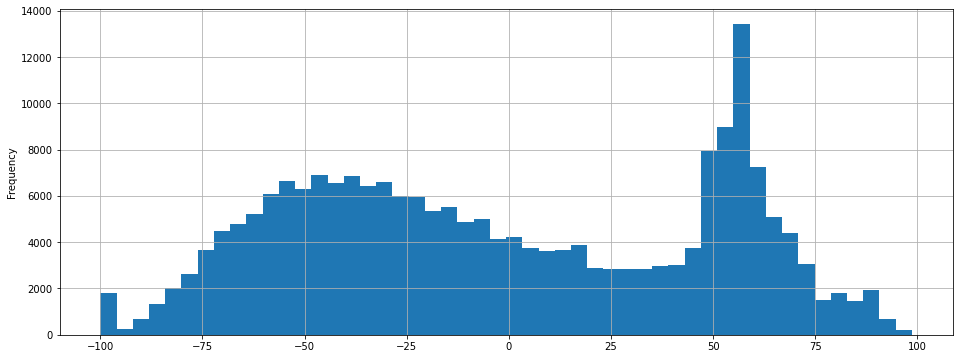

In [55]:
# plotting
#hist_logy = submissions8and5['diff'].plot(kind='hist', grid=True,bins=50, logy=True, figsize=(16,6))
hist_pct = submissions8and5['diffpct'].plot(kind='hist', grid=True, bins=50, figsize=(16,6))

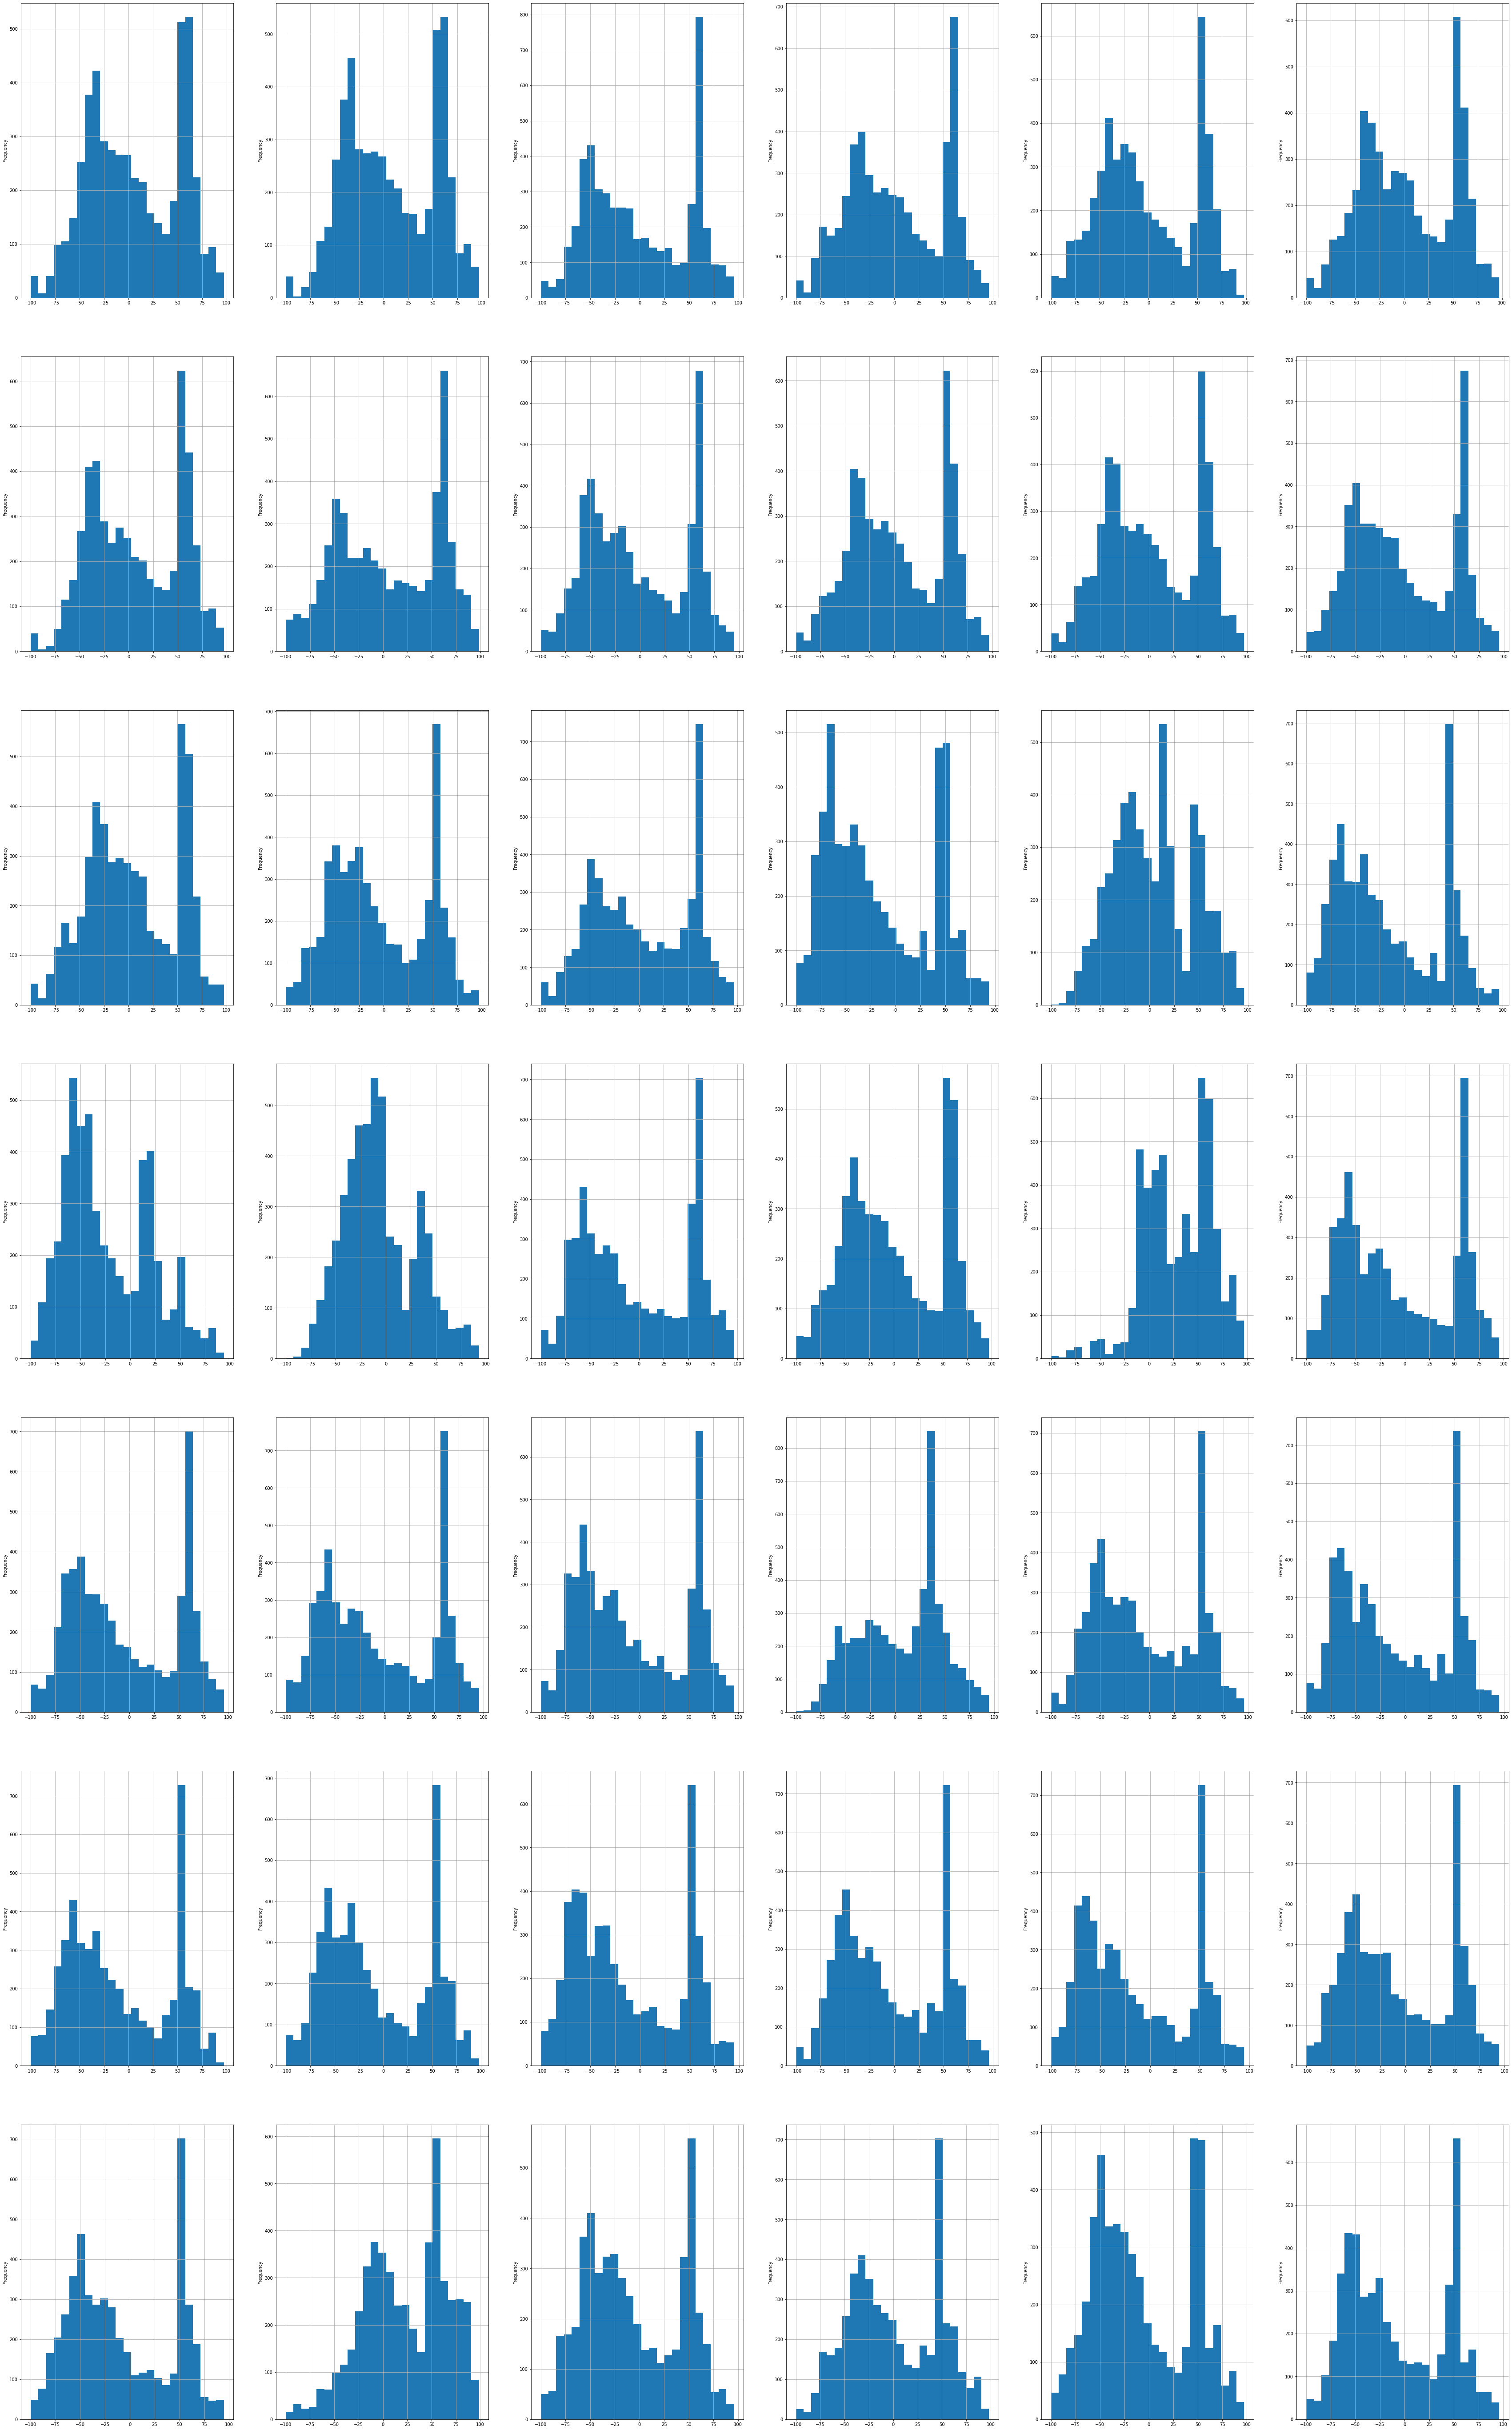

In [61]:

# cnt = 1
# for s in submissions8and5.sort_values('shop_id').shop_id.unique():
#     print(f'ax{s} = fig.add_subplot(7,6,{cnt})')
#     cnt+=1
# for s in submissions8and5.sort_values('shop_id').shop_id.unique():
#     print(f'hist_pct{s} = submissions8and5[submissions8and5.shop_id == {s}]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax{s})')

fig = plt.figure(figsize=(60,100)) 
ax2 = fig.add_subplot(7,6,1)
ax3 = fig.add_subplot(7,6,2)
ax4 = fig.add_subplot(7,6,3)
ax5 = fig.add_subplot(7,6,4)
ax6 = fig.add_subplot(7,6,5)
ax7 = fig.add_subplot(7,6,6)
ax10 = fig.add_subplot(7,6,7)
ax12 = fig.add_subplot(7,6,8)
ax14 = fig.add_subplot(7,6,9)
ax15 = fig.add_subplot(7,6,10)
ax16 = fig.add_subplot(7,6,11)
ax18 = fig.add_subplot(7,6,12)
ax19 = fig.add_subplot(7,6,13)
ax21 = fig.add_subplot(7,6,14)
ax22 = fig.add_subplot(7,6,15)
ax24 = fig.add_subplot(7,6,16)
ax25 = fig.add_subplot(7,6,17)
ax26 = fig.add_subplot(7,6,18)
ax28 = fig.add_subplot(7,6,19)
ax31 = fig.add_subplot(7,6,20)
ax34 = fig.add_subplot(7,6,21)
ax35 = fig.add_subplot(7,6,22)
ax36 = fig.add_subplot(7,6,23)
ax37 = fig.add_subplot(7,6,24)
ax38 = fig.add_subplot(7,6,25)
ax39 = fig.add_subplot(7,6,26)
ax41 = fig.add_subplot(7,6,27)
ax42 = fig.add_subplot(7,6,28)
ax44 = fig.add_subplot(7,6,29)
ax45 = fig.add_subplot(7,6,30)
ax46 = fig.add_subplot(7,6,31)
ax47 = fig.add_subplot(7,6,32)
ax48 = fig.add_subplot(7,6,33)
ax49 = fig.add_subplot(7,6,34)
ax50 = fig.add_subplot(7,6,35)
ax52 = fig.add_subplot(7,6,36)
ax53 = fig.add_subplot(7,6,37)
ax55 = fig.add_subplot(7,6,38)
ax56 = fig.add_subplot(7,6,39)
ax57 = fig.add_subplot(7,6,40)
ax58 = fig.add_subplot(7,6,41)
ax59 = fig.add_subplot(7,6,42)
hist_pct2 = submissions8and5[submissions8and5.shop_id == 2]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax2)
hist_pct3 = submissions8and5[submissions8and5.shop_id == 3]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax3)
hist_pct4 = submissions8and5[submissions8and5.shop_id == 4]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax4)
hist_pct5 = submissions8and5[submissions8and5.shop_id == 5]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax5)
hist_pct6 = submissions8and5[submissions8and5.shop_id == 6]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax6)
hist_pct7 = submissions8and5[submissions8and5.shop_id == 7]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax7)
hist_pct10 = submissions8and5[submissions8and5.shop_id == 10]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax10)
hist_pct12 = submissions8and5[submissions8and5.shop_id == 12]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax12)
hist_pct14 = submissions8and5[submissions8and5.shop_id == 14]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax14)
hist_pct15 = submissions8and5[submissions8and5.shop_id == 15]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax15)
hist_pct16 = submissions8and5[submissions8and5.shop_id == 16]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax16)
hist_pct18 = submissions8and5[submissions8and5.shop_id == 18]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax18)
hist_pct19 = submissions8and5[submissions8and5.shop_id == 19]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax19)
hist_pct21 = submissions8and5[submissions8and5.shop_id == 21]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax21)
hist_pct22 = submissions8and5[submissions8and5.shop_id == 22]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax22)
hist_pct24 = submissions8and5[submissions8and5.shop_id == 24]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax24)
hist_pct25 = submissions8and5[submissions8and5.shop_id == 25]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax25)
hist_pct26 = submissions8and5[submissions8and5.shop_id == 26]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax26)
hist_pct28 = submissions8and5[submissions8and5.shop_id == 28]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax28)
hist_pct31 = submissions8and5[submissions8and5.shop_id == 31]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax31)
hist_pct34 = submissions8and5[submissions8and5.shop_id == 34]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax34)
hist_pct35 = submissions8and5[submissions8and5.shop_id == 35]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax35)
hist_pct36 = submissions8and5[submissions8and5.shop_id == 36]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax36)
hist_pct37 = submissions8and5[submissions8and5.shop_id == 37]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax37)
hist_pct38 = submissions8and5[submissions8and5.shop_id == 38]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax38)
hist_pct39 = submissions8and5[submissions8and5.shop_id == 39]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax39)
hist_pct41 = submissions8and5[submissions8and5.shop_id == 41]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax41)
hist_pct42 = submissions8and5[submissions8and5.shop_id == 42]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax42)
hist_pct44 = submissions8and5[submissions8and5.shop_id == 44]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax44)
hist_pct45 = submissions8and5[submissions8and5.shop_id == 45]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax45)
hist_pct46 = submissions8and5[submissions8and5.shop_id == 46]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax46)
hist_pct47 = submissions8and5[submissions8and5.shop_id == 47]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax47)
hist_pct48 = submissions8and5[submissions8and5.shop_id == 48]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax48)
hist_pct49 = submissions8and5[submissions8and5.shop_id == 49]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax49)
hist_pct50 = submissions8and5[submissions8and5.shop_id == 50]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax50)
hist_pct52 = submissions8and5[submissions8and5.shop_id == 52]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax52)
hist_pct53 = submissions8and5[submissions8and5.shop_id == 53]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax53)
hist_pct55 = submissions8and5[submissions8and5.shop_id == 55]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax55)
hist_pct56 = submissions8and5[submissions8and5.shop_id == 56]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax56)
hist_pct57 = submissions8and5[submissions8and5.shop_id == 57]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax57)
hist_pct58 = submissions8and5[submissions8and5.shop_id == 58]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax58)
hist_pct59 = submissions8and5[submissions8and5.shop_id == 59]["diffpct"].plot(kind="hist", grid=True, bins=25, ax=ax59)

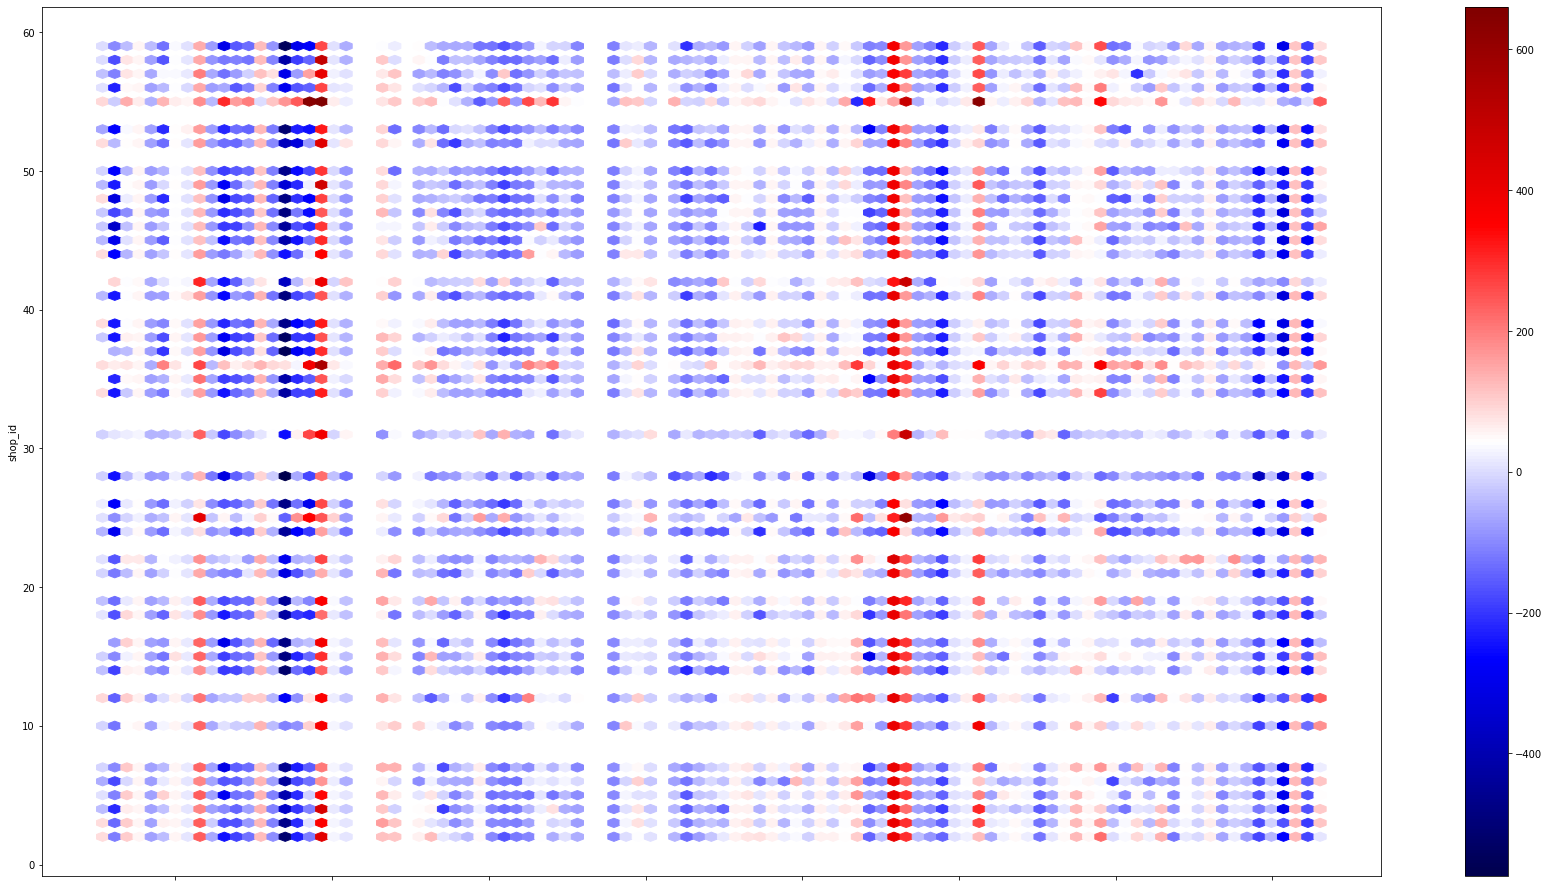

In [64]:
# Shops seem pretty similar in error distribution, based on a rough look at the above histograms...
# Again, it looks to me from the hexbin plot below that the big deviations are more item-dependent than shop-dependent
submissions8and5.sort_values('item_id',inplace=True)
hex_bin = submissions8and5.iloc[10000:25000][:].plot.hexbin(x='item_id',y='shop_id',C='diffpct',reduce_C_function=np.sum,gridsize=100,figsize=(30,16),cmap='seismic')

   item_id  sales8  sales5   diff  diffpct                                             item_name
0       30   0.046   0.087 -0.041  -41.252                           007: COORDINATES "SKAYFOLL"
1       31   0.250   0.335 -0.086   -7.991                      007: COORDINATES "SKAYFOLL» (BD)
2       32   0.320   0.356 -0.035    9.526                                                 1 + 1
3       33   0.180   0.239 -0.060   -1.701                                            1 + 1 (BD)
4       38   0.097   0.086  0.011   29.612  10 most popular comedy twentieth century 10DVD (rem)
         item_id  sales8  sales5   diff  diffpct
count       5100    5100    5100   5100     5100
mean  11,019.399   0.221   0.220  0.000   -1.942
std    6,253.243   0.469   0.471  0.187   40.219
min           30   0.019   0.036 -2.480  -98.216
25%    5,381.500   0.061   0.064 -0.046  -36.809
50%        11203   0.109   0.106 -0.021   -8.351
75%   16,071.500   0.181   0.202  0.046   40.034
max        22167  17.112  

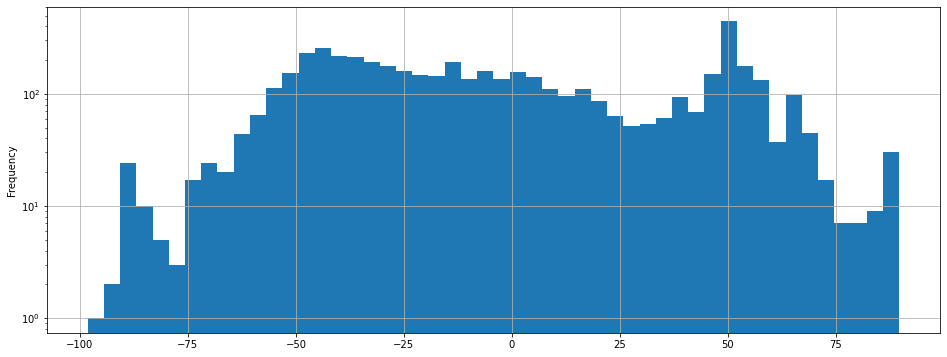

In [66]:
# let's group by item (thus discarding the shop individuality) and see if there are especially bad item_ids
sub85 = submissions8and5.groupby(by='item_id', as_index=False).mean().drop(['ID','shop_id'],axis=1).merge(items_augmented[['item_id','item_name']], on='item_id', how='left').reset_index(drop=True)
print(sub85.head())
print(sub85.describe())
hist_logy = sub85['diffpct'].plot(kind='hist', grid=True,bins=50, logy=True, figsize=(16,6))


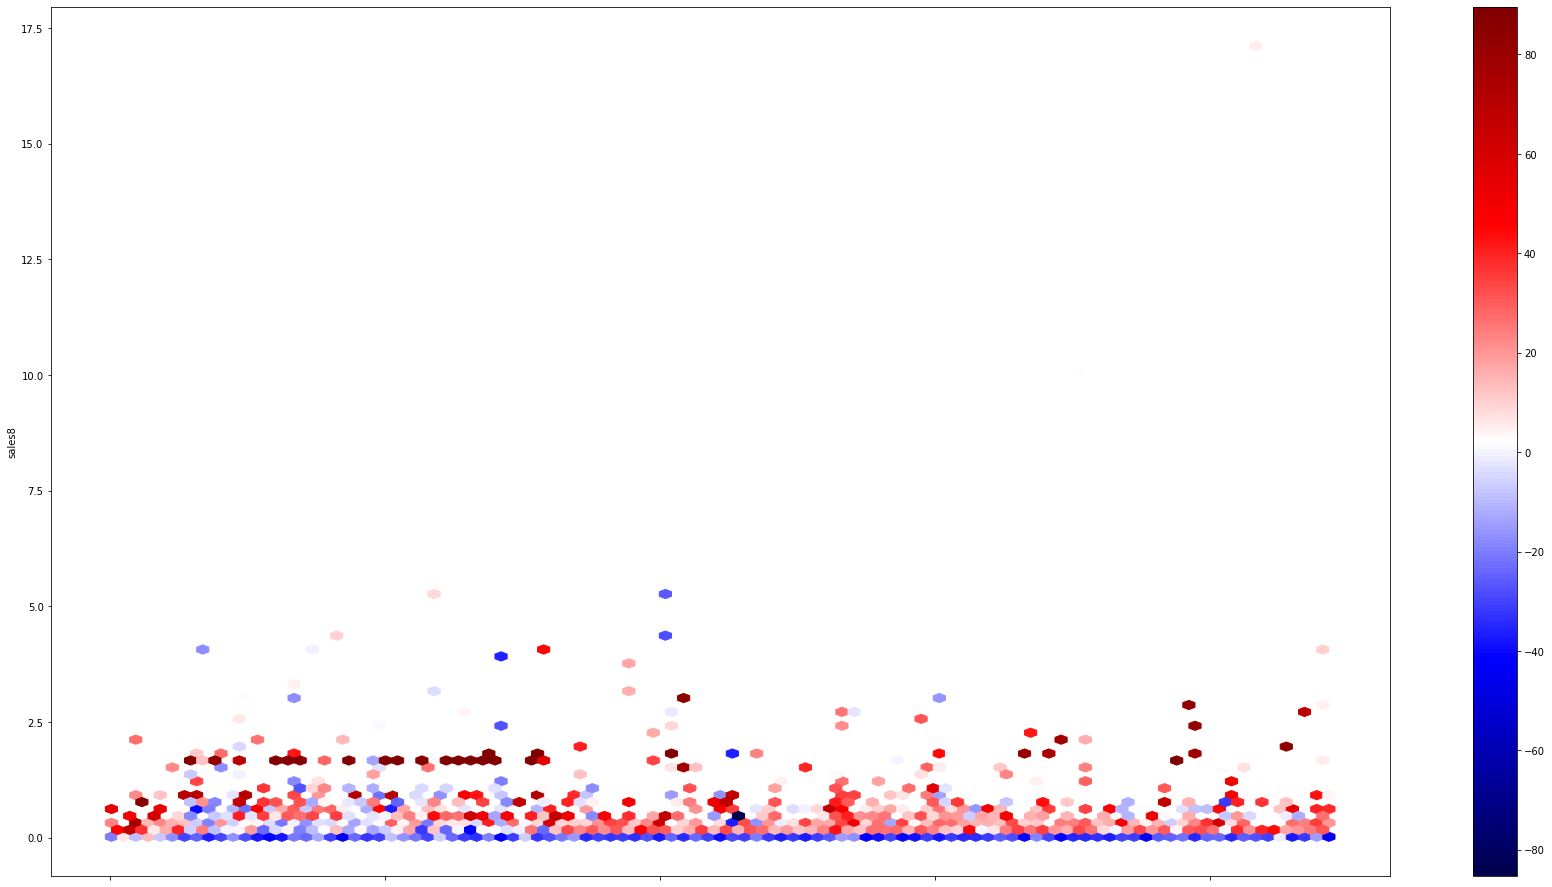

In [74]:
# Let's look at hexplot to help separate item id as well as total prediction:              xxxxx.iloc[10000:25000][:]

hex_bin = sub85.plot.hexbin(x='item_id',y='sales8',C='diffpct',reduce_C_function=np.mean,gridsize=100,figsize=(30,16),cmap='seismic')

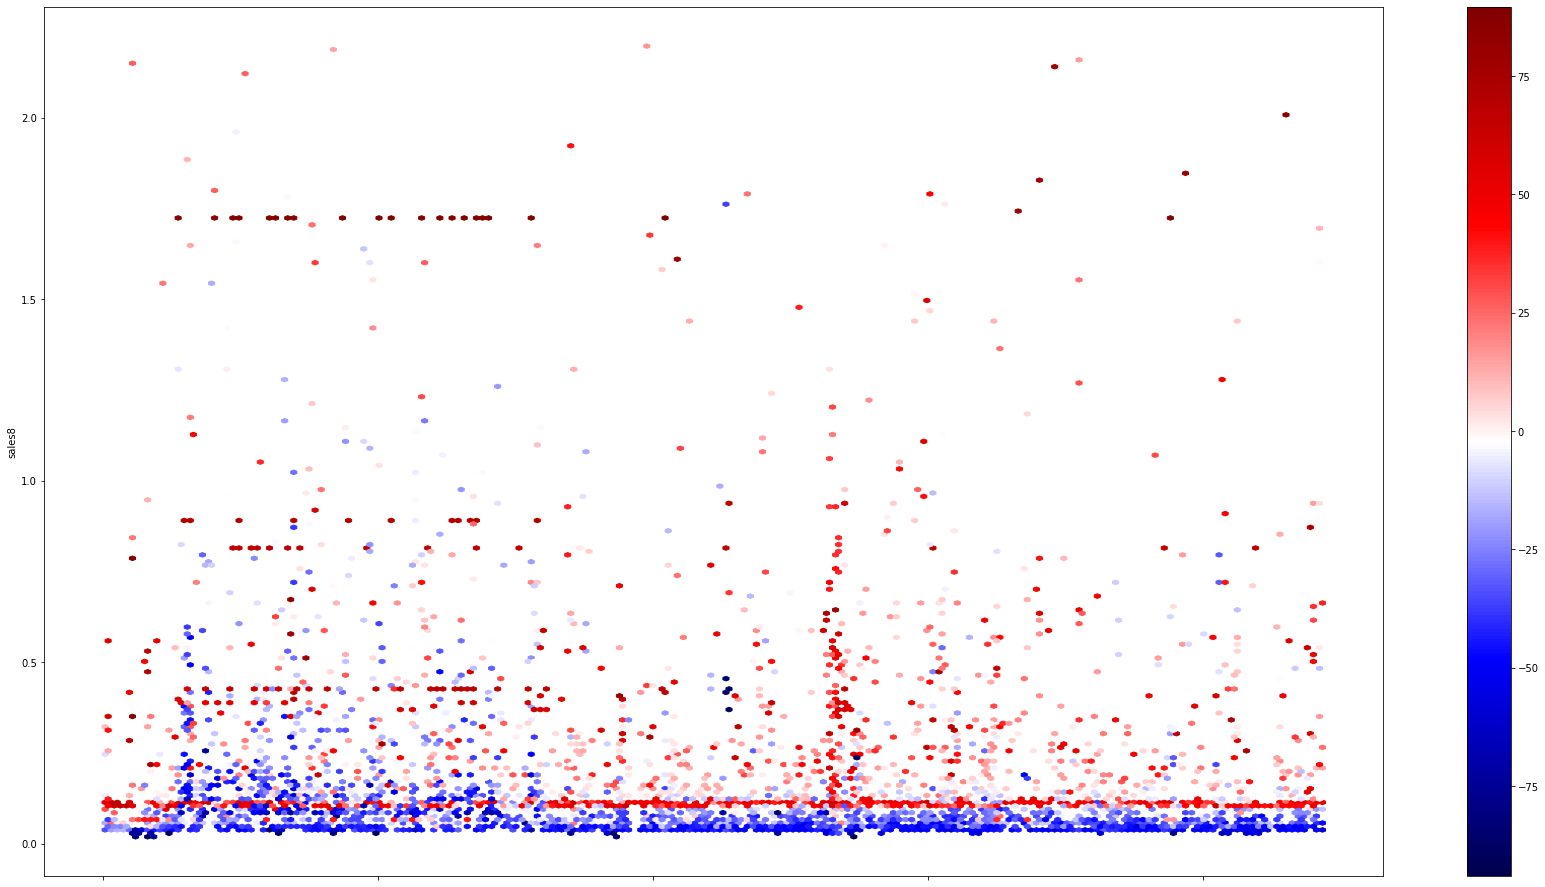

In [75]:
# Let's look at hexplot to help separate item id as well as total prediction:              xxxxx.iloc[10000:25000][:]

hex_bin = sub85[sub85.sales8 < 2.2].plot.hexbin(x='item_id',y='sales8',C='diffpct',reduce_C_function=np.mean,gridsize=200,figsize=(30,16),cmap='seismic')

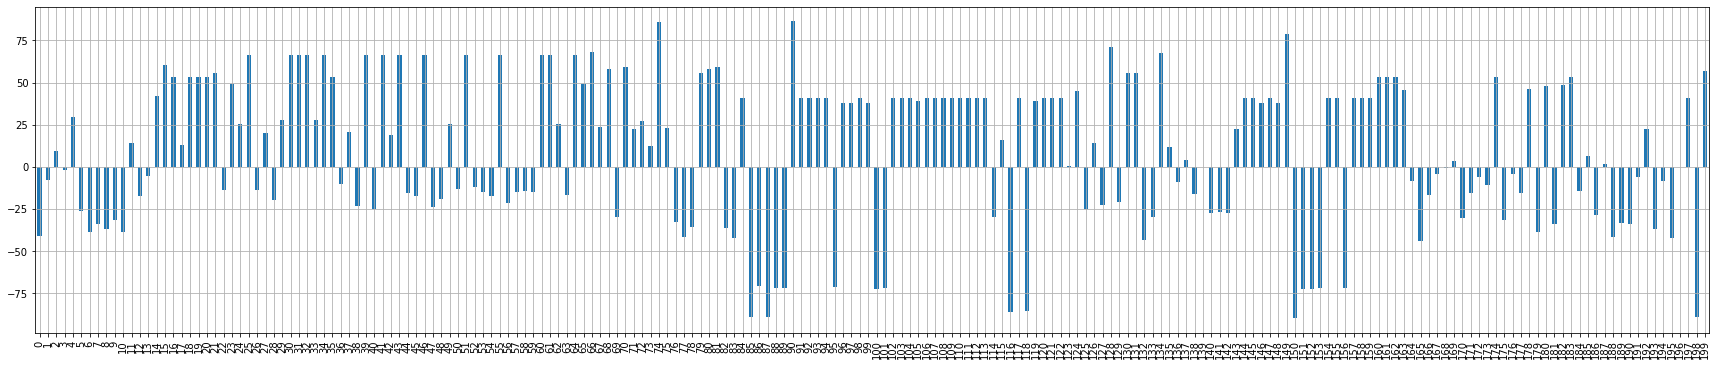

In [78]:
barplotpct = sub85.iloc[0:200][:]['diffpct'].plot(x='item_id',kind='bar', grid=True, figsize=(30,6))

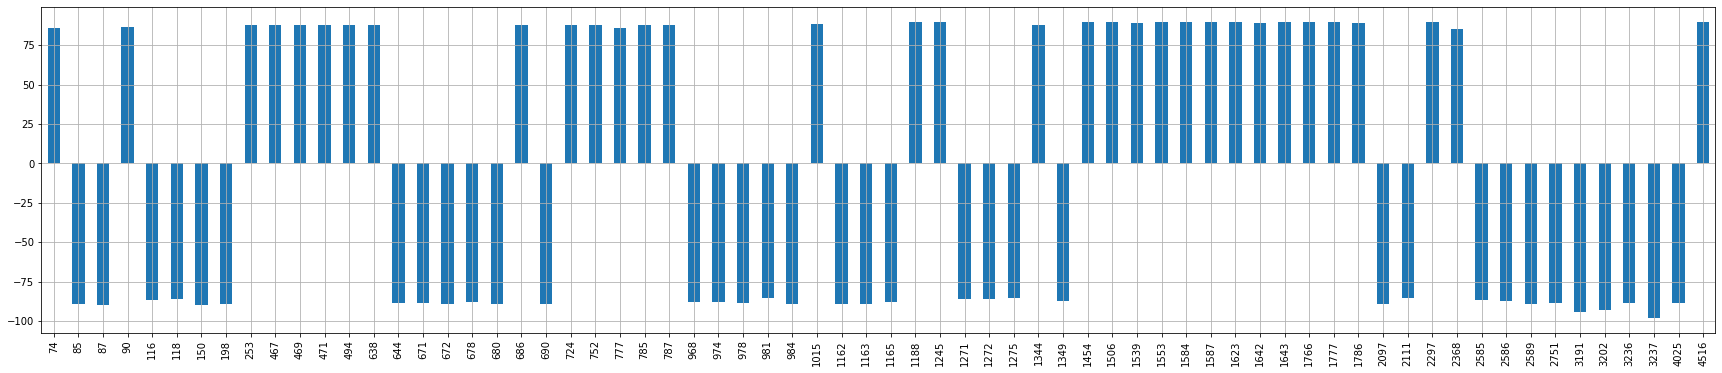

In [79]:
barplotoutliers = sub85[(sub85.diffpct > 85) | (sub85.diffpct < -85)]['diffpct'].plot(x='item_id',kind='bar', grid=True, figsize=(30,6))

###Comparing 8/10 coursera grade submission with 5/10 submission
looking at specific items and categories

In [95]:
# see if I can find a common thread in the elements with high deviation
sub85 = sub85.merge(items_new[['item_id','item_category_id','item_category3','item_category4','cluster_code']],on='item_id',how='left').reset_index(drop=True)
sub85 = sub85.merge(item_categories_augmented[['item_category_id', 'en_cat_name']], on='item_category_id',how='left').reset_index(drop=True)
sub85.item_name = sub85.item_name.apply(lambda x: x[:60])
print(sub85.item_id.nunique())
out=sub85.query('((diffpct > 60) | (diffpct < -60)) & (sales8 > 1.6)')
out_ids = out.item_id.unique()
print(len(out_ids))
print(out)
#barplotoutliers = sub85[(sub85.diffpct > 87) | (sub85.diffpct < -87)]['diffpct'].plot(x='item_id',kind='bar', grid=True, figsize=(30,6))

5100
41
      item_id  sales8  sales5  diff  diffpct                                                     item_name  item_category_id item_category3 item_category4  cluster_code         en_cat_name
253      1386   1.726   0.201 1.525   87.865                       Alien: Isolation [PS4, Russian version]                20          Games    PlayStation          1316         Games - PS4
398      1969   1.726   0.252 1.474   84.727      Bloodborne: Generation of blood [PS4, Russian subtitles]                20          Games    PlayStation           964         Games - PS4
467      2323   1.726   0.201 1.525   87.865            Call of Duty: Black Ops III [PS4, Russian version]                20          Games    PlayStation          4151         Games - PS4
469      2325   1.726   0.201 1.525   87.865  Call of Duty: Black Ops III. Hardened Edition [PS4, English                 20          Games    PlayStation          4151         Games - PS4
471      2327   1.726   0.201 1.525   87.865  C

In [110]:
# for diffpct >< 60 and sales8 > 1.6, value_counts of item_category_id =
# 41
# 20    31
# 37     5
# 40     4
# 38     1

# for diffpct >< 10 and sales8>2, item_cat_id=
# 27
# 20    5
# 40    5
# 47    3
# 37    3
# 28    2
# 75    2
# 70    2
# 30    1
# 61    1
# 55    1
# 73    1
# 65    1

# for diffpct >< 50 and sales8>1, item_cat_id=
# 43
# 20    31
# 37     5
# 40     4
# 47     2
# 38     1

# for diffpct >< 50 and sales8>0.5, item_cat_id=
# 110
# 20    32
# 30    15
# 28    12
# 37    11
# 40     7
# 47     6
# ...

# for diffpct >< 50 and sales8>0.2, item_cat_id=
# 271
# 20    32
# 23    20
# 24    17
# 30    16
# 19    15
# 37    15
# 47    13
# 25    13
# 28    12
# 40    12
# ...

# for diffpct >< 50 and sales >0.5, item category 3 value counts =
# 9
# Games          68
# Movies         19
# Books          10
# Debit_Cards     5
# Gifts           3
# Consoles        2
# Shipping        1
# Music           1
# Software        1

# diffpct >< 50 and sales > 0.2, item_cat3:
# 10
# Games          145
# Books           29
# Movies          29
# Gifts           27
# Consoles        12
# Accessories      8
# Music            7
# Shipping         6
# Debit_Cards      5
# Software         3

# # diffpct >< 50 and sales > 0.1 item_cat3:
# 10
# Games          332
# Movies         291
# Books          102
# Music          102
# Gifts           34
# Consoles        12
# Accessories      8
# Software         7
# Debit_Cards      7
# Shipping         7

# These are all item cat 3 counts in the test set:.... suggests "Gifts" is a good category; games & movies & consoles & Debit_Cards & shipping are not good
# Movies         1263
# Games          1078
# Music          1042
# Gifts           999
# Books           398
# Software        190
# Accessories      81
# Consoles         28
# Debit_Cards      13
# Shipping          8

# # diffpct >< 50 and sales > 0.1 item_cat4:
# 8
# Movies         291
# PC             240
# Music          102
# Books           87
# PlayStation     76
# Xbox            52
# Gifts           34
# Any             20

# # These are all item cat 4 counts in the test set:.... suggests PC is the worst, then movies and 'any'
# Movies         1263
# Music          1042
# Gifts           999
# PC              718
# PlayStation     369
# Books           360
# Xbox            299
# Any              50

# cluster codes... looks like 55 is very good; others scale roughly with overall distribution (no major problems are obvious)
# 456
# 40      62
# 431     29
# 2253    18
# 2920    12
# 37      12
# 1088     9
# 4151     9
# 1543     9
# 2504     9
# 47       8
# Top overall cluster codes item value counts
# 55      176
# 40      172
# 2504     96
# 431      77
# 37       56
# 2253     55
# 64       48

out=sub85.query('((diffpct > 50) | (diffpct < -50)) & (sales8 > 0.1)')
out_ids = out.cluster_code.unique()
print(len(out_ids))
print(out.cluster_code.value_counts()[:10])
print(sub85.cluster_code.value_counts()[:15])

456
40      62
431     29
2253    18
2920    12
37      12
1088     9
4151     9
1543     9
2504     9
47       8
Name: cluster_code, dtype: int64
55      176
40      172
2504     96
431      77
37       56
2253     55
64       48
1097     46
1551     36
1088     35
47       30
72       29
2920     27
235      27
110      27
Name: cluster_code, dtype: int64


###Comparing 8/10 coursera grade submission with 5/10 submission
looking at specific items and categories

In [124]:
# looks like item_cat_id = 20 is by far the worst (Games - PS4); cat3 = Games is not great (encoding = 4); cat4 = PC is also bad (encoding = 5) but doesn't have much overlap with cat = 20, PS4
# so, what is special about item 20?
sub85_20 = sub85.query('item_category_id==20').copy(deep=True).reset_index(drop=True)
sub85_20['round8'] = sub85_20.sales8.apply(lambda x: round(x,3))
sub85_20['round5'] = sub85_20.sales5.apply(lambda x: round(x,3))
print(sub85_20.head())
print(sub85_20.describe())
print(sub85_20.round8.value_counts())
print(sub85_20.round5.value_counts())

# sales8 has 31 items in item category id=20 with the same prediction for sales (1.726), 3 items at 0.162, a few with 2 items...
# sales5 is more smoothly distributed, but still has 9 items with same prediction (0.172), 8 items with another (.201), and 3, 2, 2...
print(sub85_20.query('round8 == 1.726'))

   item_id  sales8  sales5   diff  diffpct                                                     item_name  item_category_id item_category3 item_category4  cluster_code  en_cat_name  round8  round5
0     1386   1.726   0.201  1.525   87.865                       Alien: Isolation [PS4, Russian version]                20          Games    PlayStation          1316  Games - PS4   1.726   0.201
1     1389   0.822   0.952 -0.130   -8.672     Alien: Isolation. Nostromo Edition [PS4, Russian version]                20          Games    PlayStation          1316  Games - PS4   0.822   0.952
2     1496   0.518   0.835 -0.317  -36.781        Assassin's Creed IV. Black Flag [PS4, Russian version]                20          Games    PlayStation          5612  Games - PS4   0.518   0.835
3     1540   0.571   1.408 -0.837  -51.211                Assassin's Creed: Unity [PS4, Russian version]                20          Games    PlayStation          3062  Games - PS4   0.571   1.408
4     1545   0.159  

###Comparing 8/10 coursera grade submission with 5/10 submission
looking at category 20 behavior

In [186]:
stcm20 = sales_train_cln_mrg.query('item_category_id == 20').copy(deep=True).rename(columns={'date_block_num':'month','item_cnt_day':'y_sales','item_category_id':'n_train_rows'})
su = sorted(stcm20.shop_id.unique())
print(len(su), su)
stcm20 = stcm20.drop(['shop_type_enc','shop_city_enc',
                        'shop_federal_district_enc','s_type_broad_enc','fd_popdens_enc','fd_gdp_enc','cluster_code',
                        'item_category3_enc','item_category4_enc'],axis=1)
stcm20t = stcm20.query('item_tested == 1').copy(deep=True)
stcm20st = stcm20.query('shop_tested == 1').copy(deep=True)
stcm20m = stcm20.groupby(['month']).sum().reset_index()
stcm20ms = stcm20.groupby(['month','shop_id']).sum().reset_index()
stcm20mi = stcm20.groupby(['month','item_id']).sum().reset_index()
stcm20msi = stcm20.groupby(['month','shop_id','item_id']).sum().reset_index()
stcm20m.item_price = stcm20m.apply(lambda row: row.item_price/row.y_sales, axis =1)
stcm20ms.item_price = stcm20ms.apply(lambda row: row.item_price/row.y_sales, axis =1)
stcm20mi.item_price = stcm20mi.apply(lambda row: row.item_price/row.y_sales, axis =1)
stcm20msi.item_price = stcm20msi.apply(lambda row: row.item_price/row.y_sales, axis =1)
stcm20m.n_train_rows = stcm20m.n_train_rows / 20
stcm20ms.n_train_rows = stcm20ms.n_train_rows / 20
stcm20mi.n_train_rows = stcm20mi.n_train_rows / 20
stcm20msi.n_train_rows = stcm20msi.n_train_rows / 20
stcm20m['sales_per_row'] = stcm20m.y_sales / stcm20m.n_train_rows
stcm20ms['sales_per_row'] = stcm20ms.y_sales / stcm20ms.n_train_rows
stcm20mi['sales_per_row'] = stcm20mi.y_sales / stcm20mi.n_train_rows
stcm20msi['sales_per_row'] = stcm20msi.y_sales / stcm20msi.n_train_rows
stcm20tm = stcm20t.groupby(['month']).sum().reset_index()
stcm20tm.item_price = stcm20tm.apply(lambda row: row.item_price/row.y_sales, axis =1)
stcm20tm.n_train_rows = stcm20tm.n_train_rows / 20
stcm20tm['sales_per_row'] = stcm20tm.y_sales / stcm20tm.n_train_rows

print(stcm20msi.query('shop_id==36'))
print(36 in stcm20st.shop_id.unique())
print('Group by month, category 20 only:')
print(stcm20m.head())
print(stcm20m.describe())
print('\nGroup by month and shop and item, category 20 only:')
print(stcm20msi.head())
print(stcm20msi.describe())
print('\nGroup by month and shop, category 20 only:')
print(stcm20ms.head())
print(stcm20ms.describe())
print('\nGroup by month and item, category 20 only:')
print(stcm20mi.head())
print(stcm20mi.describe())
print('\nGroup by month, only tested items; category 20 only:')
print(stcm20tm.head())
print(stcm20tm.describe())

50 [2, 3, 4, 5, 6, 7, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


       month  shop_id  item_id  item_price  y_sales  shop_tested  item_tested  n_train_rows  sales_per_row
26521     33       36     1583   1,429.600        5            2            2             2          2.500
26522     33       36     1971        3298        2            2            2             2              1
26523     33       36     2423     699.200        5            4            4             4          1.250
26524     33       36     3733        4499        1            1            1             1              1
26525     33       36     3756        7599        2            2            2             2              1
26526     33       36     3928        2299        1            1            1             1              1
26527     33       36     4045         299        1            1            1             1              1
26528     33       36     4721        3599        1            1            1             1              1
26529     33       36     4873       

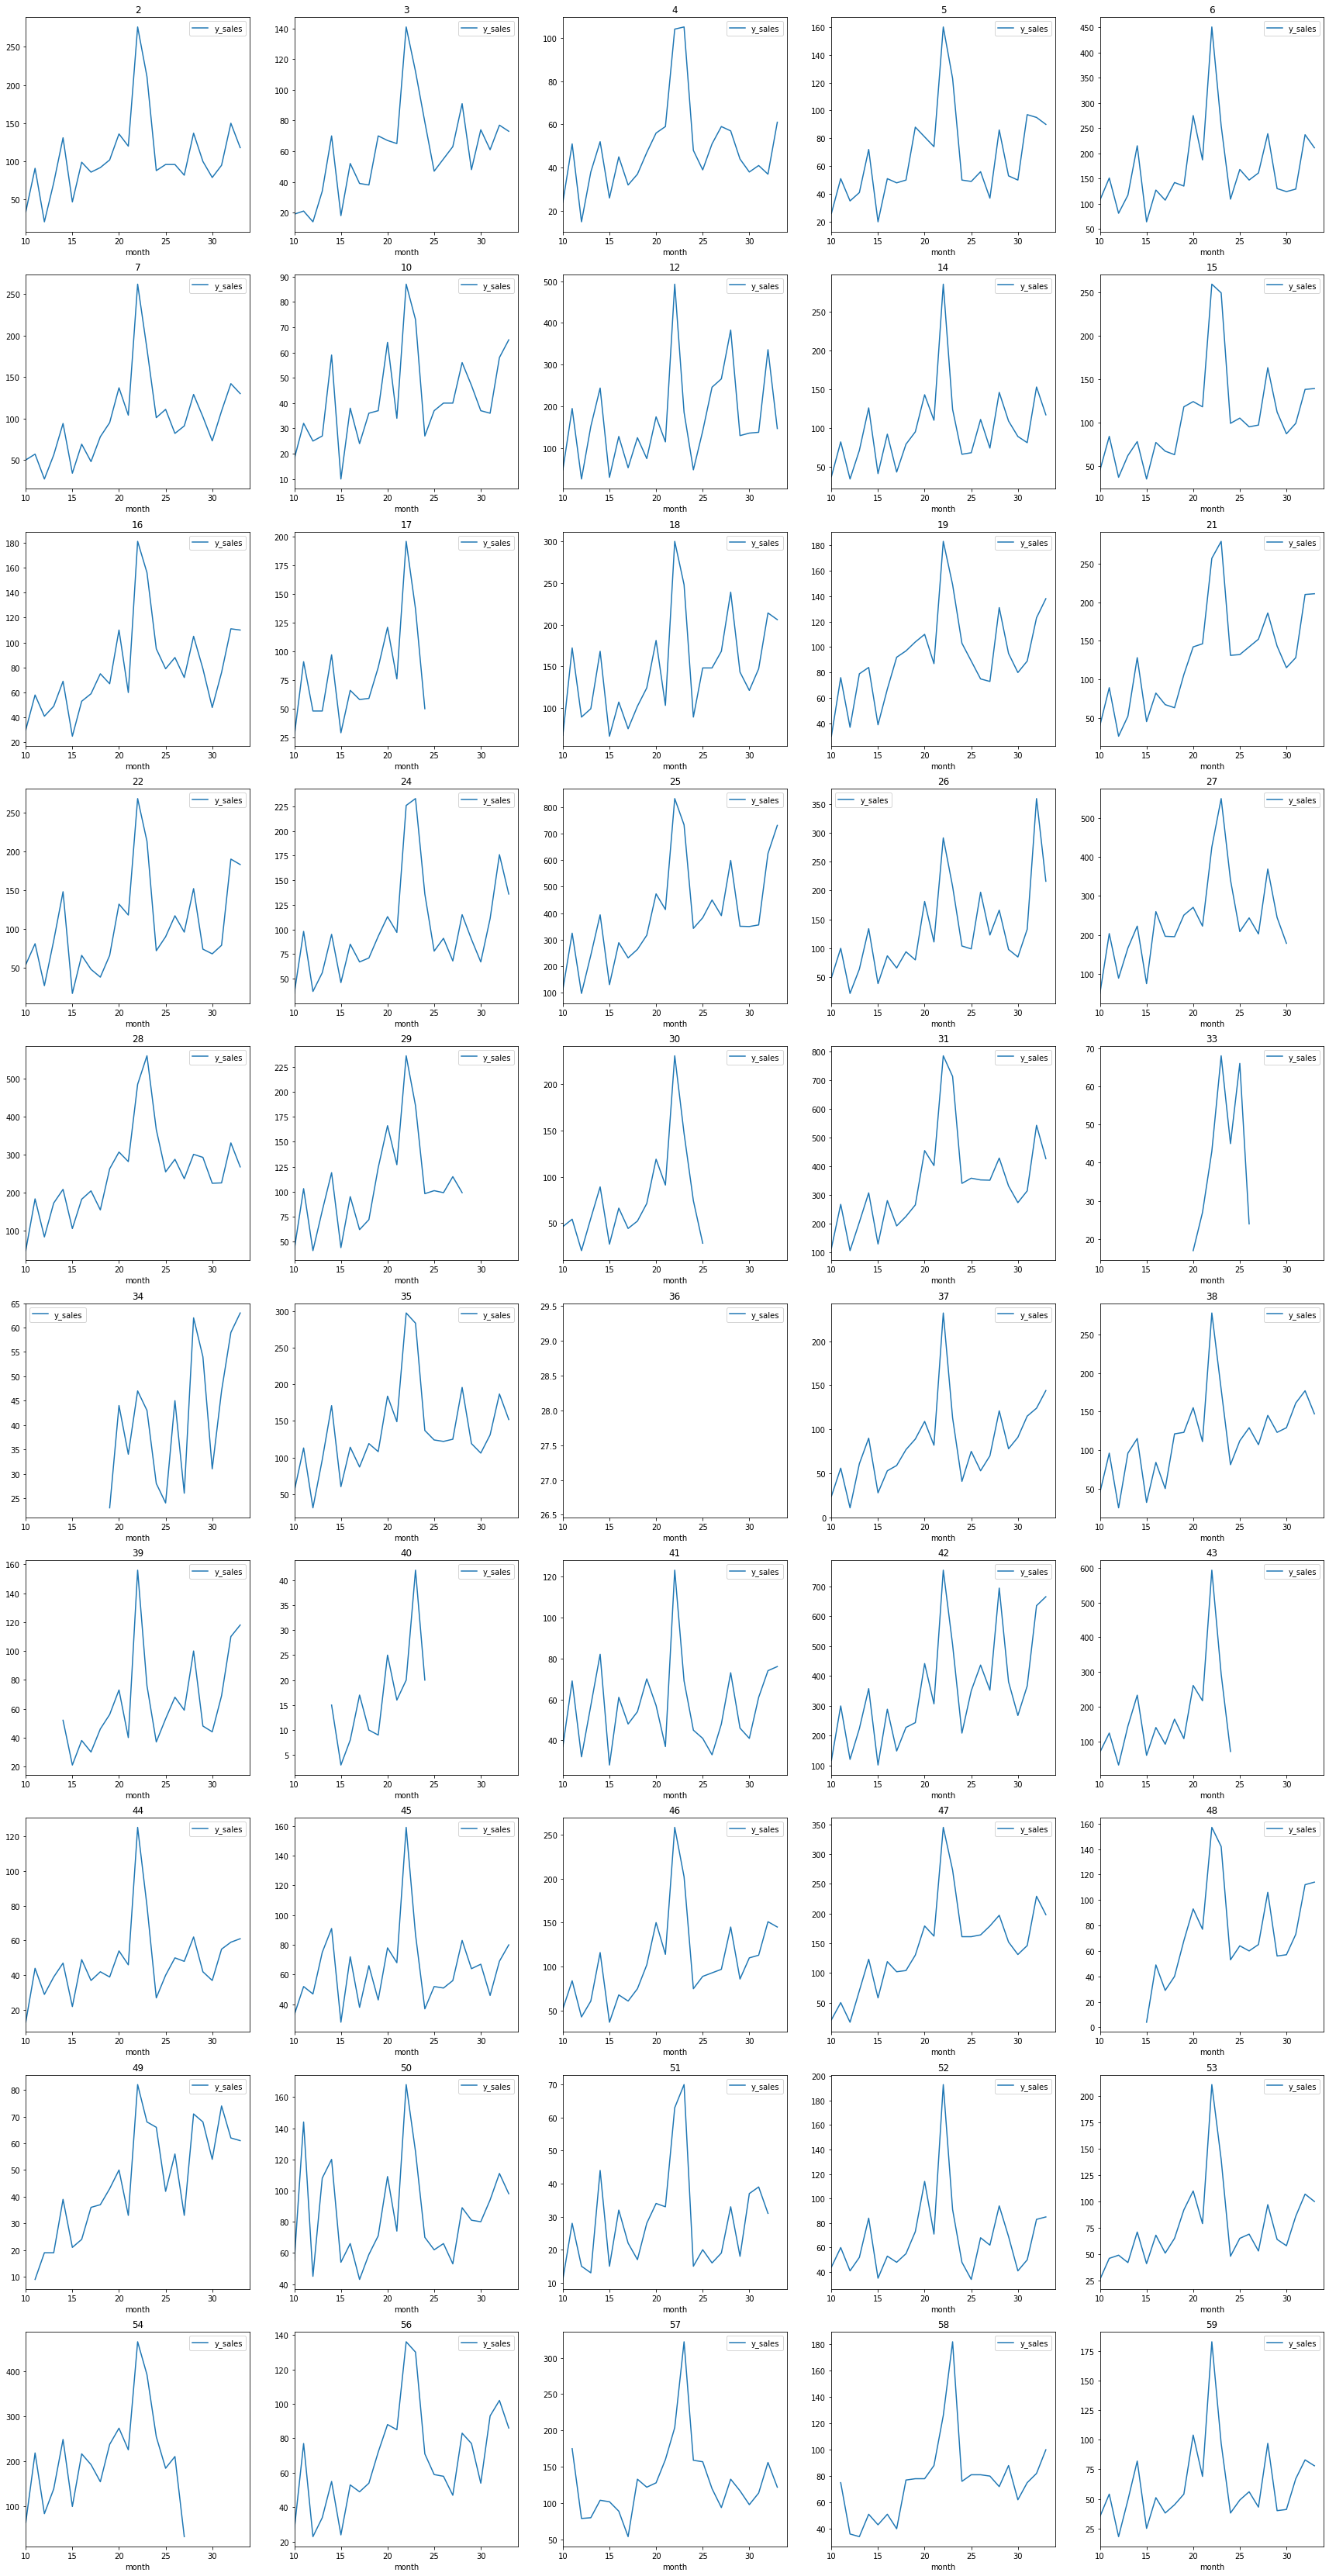

In [187]:
fig = plt.figure(figsize = (30,60))
axs = []
# count = 1
# rows = 10
# cols = 5
for i in range(1,51):
    axs.append(eval('fig.add_subplot(10,5,'+str(i)+')')) 

#ax = fig.add_subplot(111)
count=0
for sh in su:
    s = stcm20ms[stcm20ms.shop_id == sh]
    s.plot(x='month', y='y_sales',kind='line',logy=False,xlim=(10,34),title=sh,ax=axs[count]) #,ylim=(-10,100)
    count += 1

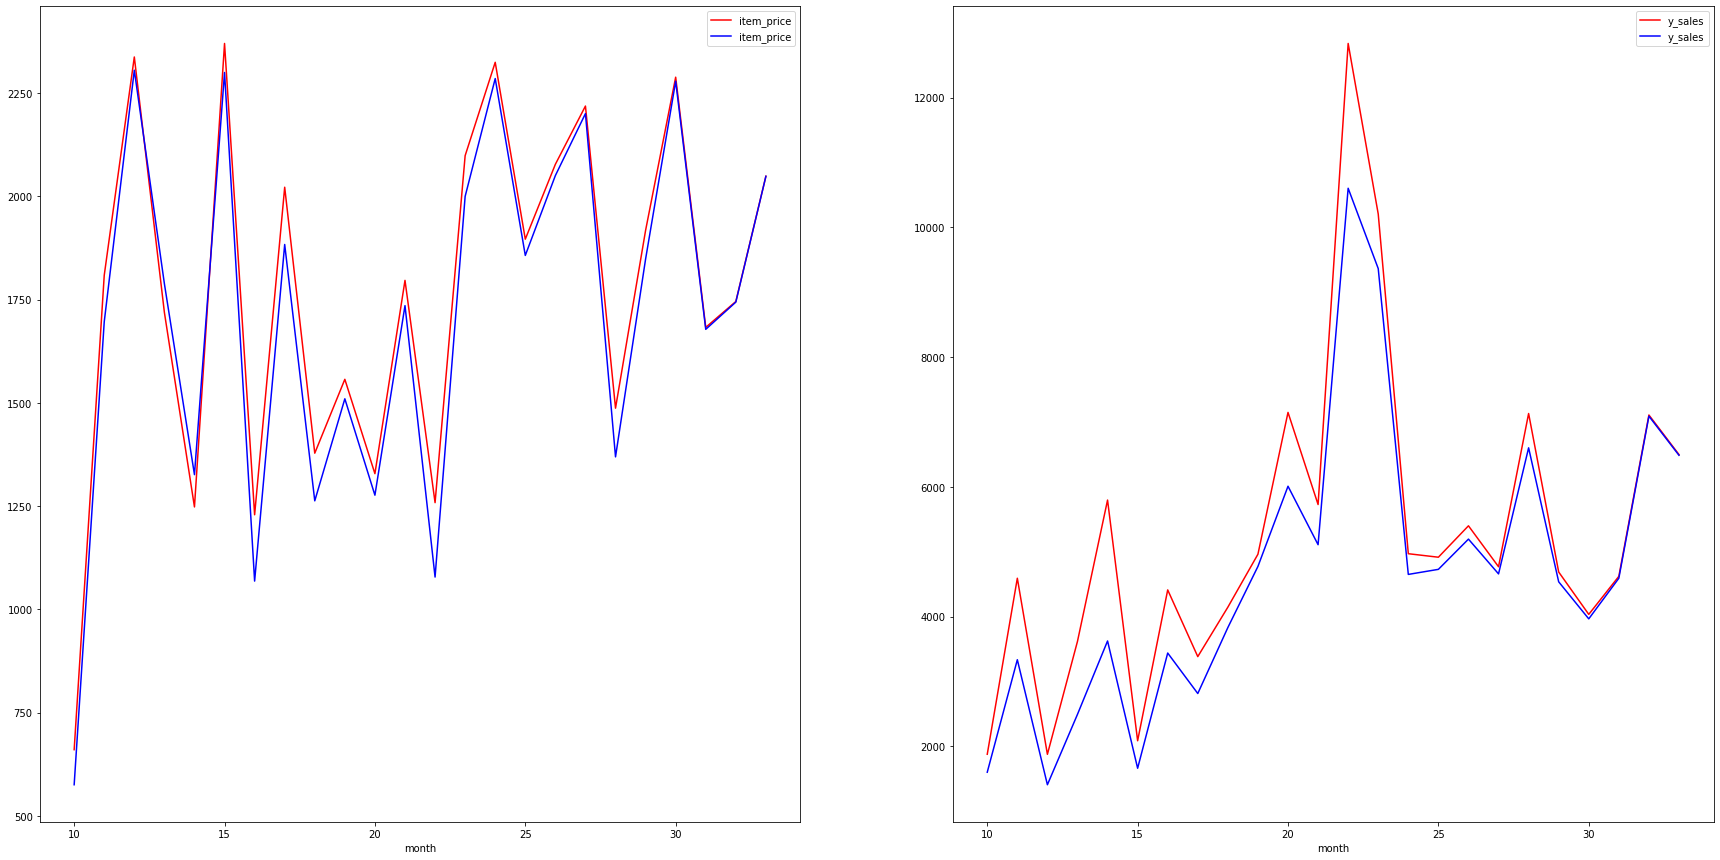

In [188]:
# OK, so no sales of PS4 before month 10

fig = plt.figure(figsize=(30,15)) 
axP = fig.add_subplot(121)
axS = fig.add_subplot(122)
mP = stcm20m.plot(x='month', y='item_price', ax=axP, color='red')
tmP = stcm20tm.plot(x='month', y='item_price', ax=axP, color='blue')
mS = stcm20m.plot(x='month', y='y_sales', ax=axS, color='red')
tmS = stcm20tm.plot(x='month', y='y_sales', ax=axS, color='blue')

# nothing suspicious except for the big spike in sales around xmas 2014 (and the no-sales for months 0-9)
#  and, item category 20 has a large number of shops selling in it, so not necessarily a shop issue

In [199]:
sub85full = submissions8and5.merge(items_new[['item_id','item_category_id','item_category3','item_category4','cluster_code']],on='item_id',how='left').reset_index(drop=True)
sub85full = sub85full.merge(item_categories_augmented[['item_category_id', 'en_cat_name']], on='item_category_id',how='left').reset_index(drop=True)
sub85full.item_name = sub85full.item_name.apply(lambda x: x[:60])
sub85_20_36 = sub85full.query('(item_category_id==20) & (shop_id==36)').copy(deep=True).reset_index(drop=True)
sub85_20_36 = sub85_20_36.merge(sales_train_cln_mrg[['shop_id','item_id','item_cnt_day']],on=['shop_id','item_id'],how='left').reset_index(drop=True).fillna(0)
print(sub85_20_36.head(2))
print(sub85_20_36.describe())
print(sub85_20_36.query('((diffpct > 0) | (diffpct < 0)) & (item_cnt_day > 0)').sort_values('item_id').head(50))

       ID  sales8  sales5  diff  diffpct  shop_id  item_id                                                  item_name  item_category_id item_category3 item_category4  cluster_code  en_cat_name  item_cnt_day
0  163778   1.516   0.186 1.329   87.699       36     1386                    Alien: Isolation [PS4, Russian version]                20          Games    PlayStation          1316  Games - PS4             0
1  164534   0.410   0.186 0.224   54.576       36     1389  Alien: Isolation. Nostromo Edition [PS4, Russian version]                20          Games    PlayStation          1316  Games - PS4             0
               ID  sales8  sales5   diff  diffpct  shop_id   item_id  item_category_id  cluster_code  item_cnt_day
count         145     145     145    145      145      145       145               145           145           145
mean  164,584.648   0.661   0.366  0.295   20.861       36 5,040.462                20     2,859.255         0.193
std     1,297.146   0.627   0.543 

#**Data Preparation, Including Feature Merging and Feature Generation**

##**Define Various 'Constants' That Determine Feature Creation, etc.**
**Also, do some basic assignments for variables that will get used many times**

####**Choices For Statistics-Based and Time-Lagged Feature Generation**

In [0]:
# Define various constants that drive the attributes of the various features
ITEM_CNT_TRAIN_CLIP = 250  # will clip item_cnt_month to 20 after the model runs; for training, we'll let it go to this higher value (=uint8)
CARTESIAN_FILL_MONTH_START = 20
CARTESIAN_CORRELATION_START_MONTH = 23

####**Selection of Initial Features, Enhanced Readability of DataFrames**

In [0]:
# Reduce size of DF a bit; remove features I think may not be as helpful as others
#    (saves memory, and makes it make it easier to read the DF when printing)
# Also, discard 'item_price' for now, as it creates an issue when filling the cartesian product dataframe (filling/interpolating missing values)

# columns needed in the shops_new dataframe (dropping many of the secondary features for now)
SHOPS_KEEP_LIST = ['shop_id','shop_type_enc','s_type_broad_enc','shop_tested']
# columns needed in the items_new dataframe (dropping many of the secondary features for now)
ITEMS_KEEP_LIST = ['item_id','item_category_id','cluster_code','item_category3_enc','item_category4_enc','item_tested']
# conforming the the features dropped from shops_new and items_new, drop these features from the test and train dataframes
TEST_DROP_LIST = ['shop_city_enc','shop_federal_district_enc','fd_popdens_enc','fd_gdp_enc']
TRAIN_DROP_LIST = ['date','item_price','shop_city_enc','shop_federal_district_enc','fd_popdens_enc','fd_gdp_enc']

# rename columns for readability in the various dataframes
SHOPS_COLUMN_RENAME = {'shop_tested':'shop_test',
                       'shop_type_enc':'shop_typeA',
                       's_type_broad_enc':'shop_typeB'}
ITEMS_COLUMN_RENAME = { 'item_tested':'item_test', 
                        'item_category_id':'item_cat0',
                        'item_category3_enc':'item_cat3',
                        'item_category4_enc':'item_cat4',
                        'cluster_code':'item_cluster'}
TEST_COLUMN_RENAME = {'cluster_code':'item_cluster', **SHOPS_COLUMN_RENAME, **ITEMS_COLUMN_RENAME}
TRAIN_COLUMN_RENAME = {'date_block_num':'month','item_cnt_day':'sales', **SHOPS_COLUMN_RENAME, **ITEMS_COLUMN_RENAME}

# re-order columns for organized readability, for test_mrg dataset, for sales_train_cln_mrg dataset, and for the (to be created) combined sales-train-test (stt) dataset
TEST_COLUMN_ORDER = ['ID', 'month', 'shop_id', 'item_id', 'sales','shop_typeA', 'shop_typeB',
                'item_cat0', 'item_cat3', 'item_cat4', 'item_cluster', 'shop_test', 'item_test','shop_item_test']
TRAIN_COLUMN_ORDER = ['month', 'shop_id', 'item_id', 'sales', 'shop_typeA', 'shop_typeB',
                'item_cat0', 'item_cat3', 'item_cat4', 'item_cluster', 'shop_test', 'item_test','shop_item_test']
STT_COLUMN_ORDER = TRAIN_COLUMN_ORDER


####**"Variable Constants" that are computed, but will not change through notebook**
They simplify the code to enhance readability



In [0]:
# Define various 'variable constants' that won't change through this notebook, but get used frequently
TEST_LENGTH = len(test_mrg)
TRAIN_LENGTH = len(sales_train_cln_mrg)

###**Helper Functions**

In [0]:
# helper function to print out column datatypes and memory usage, using multiple columns so we don't have to scroll so much
def print_col_info(df,nrows=5):
    """
    instead of the usual single column (plus index) series printout of dtypes and memory use in a dataframe,
    this function combines dtypes and memory use so they use the same index,
    and then prints out multiple columns of length "nrows", where each column is like: "column_dtype \t column_memory_use(MB) \t column_name"
        df = dataframe of interest
            col_dtypes = pd.Series, type obj, index = column_name, values = dtype  (e.g., from the command "df.dtypes")
            col_mem = pd.Series, type int64, index = column_name, values = column memory use (bytes) (e.g., from the command "df.memory_usage(deep=True)")
        nrows = int, tells how many rows of (type/mem/name) to print before moving to a new printout column for the next triplet (type/mem/name)
                if nrows == 0, print all triplets in just one column, with no "wrapping"
    finishes with a printout of total df memory usage
    """
    col_mem = df.memory_usage(deep=True)
    col_mem = col_mem/1e6  #change to MB
    total_mem = col_mem.sum()

    col_dtypes = pd.Series([df.index.dtype], index = ['Index'])  # df.memory_usage includes Index, but df.dtypes does not include Index, so we have to add it
    col_dtypes = pd.concat([col_dtypes,df.dtypes], axis=0)

    col_info_df = pd.concat([col_dtypes, col_mem], axis=1).reset_index().rename(columns={'index':'Column Name', 0:'DType', 1:'MBytes'})


    if nrows == 0:
        print(col_info_df)
    else:
        col_info_df.MBytes = col_info_df.MBytes.apply(lambda x: str(f'{x:.1f}'))
        #col_info_df.DType = col_info_df.DType.apply(lambda x: str(x))
        info_df_len = len(col_info_df)
        cnames = col_info_df.columns
        n_info_cols = len(cnames)
        between_cols = 6  # spaces separating the info-group columns (e.g., between "ColName Dtype Mem" and next column "ColName Dtype Mem")

        # adjust number of rows such that we don't have nasty column with just one or a few rows
        stragglers = info_df_len % nrows
        n_print_cols = info_df_len // nrows
        if (stragglers > nrows/2):
            n_print_cols += 1
        elif (stragglers > 0):
            nrows = info_df_len // n_print_cols
            if info_df_len % n_print_cols > 0:
                nrows += 1

        df_list = []
        for pc in range(n_print_cols):
            df_list.append(col_info_df.shift(periods = -nrows*pc))
        df_print = pd.concat(df_list, axis = 1)
        df_print = df_print.iloc[:nrows][:].fillna(" ")
        col_headers = df_print.columns
        n_df_cols = len(col_headers)
        
        # find max string length in each column
        columnLengths = np.vectorize(len)
        maxColumnLengths = columnLengths(df_print.values.astype(str)).max(axis=0)
        col_widths = np.add(maxColumnLengths,3)

        for r in range(nrows+1):
            if r==0:
                string_list = col_headers
            else:
                string_list = df_print.iloc[r-1][:]
            print_row = ''
            c_count = 0
            for c in range(n_df_cols):
                print_row = print_row + f'{str(string_list[c]):>{col_widths[c]}} '
                c_count += 1
                if c_count == n_info_cols:
                    c_count = 0
                    print_row += " " * between_cols  # extra space between columns of common data

            print(print_row)

    print(f'\nNumber of rows in DataFrame: {len(df):,d}')
    print(f'DataFrame total memory usage: {total_mem:.0f} MB')

In [0]:
print_col_info(sales_train_cln_mrg,8)  #example use of the above helper function

      Column Name      DType   MBytes                        Column Name    DType  MBytes       
            Index      int64      0.0          shop_federal_district_enc    int64    23.3       
             date     object    195.3                   s_type_broad_enc    int64    23.3       
   date_block_num      int64     23.3                     fd_popdens_enc    int64    23.3       
          shop_id      int64     23.3                         fd_gdp_enc    int64    23.3       
          item_id      int64     23.3                        item_tested     bool     2.9       
       item_price    float64     23.3                   item_category_id    int64    23.3       
     item_cnt_day      int64     23.3                       cluster_code    int64    23.3       
      shop_tested       bool      2.9                 item_category3_enc    int64    23.3       
    shop_type_enc      int64     23.3                 item_category4_enc    int64    23.3       
    shop_city_enc      int64  

##**Initial data prep, formatting**

###**Clean up the data, drop undesirable columns, merge train and test**

In [0]:
# Clean up the shops_new and items_new dataframes
#    1) remove columns with features that we don't use at this time
#    2) rename columns to be shorter, for easier printing
#    3) convert boolean to 1/0 integer values

shops_new_purged = shops_new[SHOPS_KEEP_LIST].rename(columns = SHOPS_COLUMN_RENAME)
items_new_purged = items_new[ITEMS_KEEP_LIST].rename(columns = ITEMS_COLUMN_RENAME)

shops_new_purged.shop_test = shops_new_purged.shop_test.astype(np.int8)    # change boolean to integer 1/0 for later use
items_new_purged.item_test = items_new_purged.item_test.astype(np.int8)    # same as above

print(f'shops_new_purged dataframe length: {len(shops_new_purged)}')
print(shops_new_purged.head(2))
print('\n')
print(f'items_new_purged dataframe length: {len(items_new_purged)}')
print(items_new_purged.head(2))

shops_new_purged dataframe length: 60
   shop_id  shop_typeA  shop_typeB  shop_test
0        0          20          10          0
1        1          50          60          0


items_new_purged dataframe length: 22170
   item_id  item_cat0  item_cluster  item_cat3  item_cat4  item_test
0        0         40           920          7          3          0
1        1         76          2600         10          5          0


In [0]:
# Need to add some columns to test_mrg so we can append it to sales_train_cln_mrg before generating certain features
TEST_COLUMNS_ADD = {'month':34,'sales':0,'shop_item_test':1} # price = np.NAN
for k,v in TEST_COLUMNS_ADD.items():
    test_mrg[k] = v

In [0]:
# Add shop_item_test column to train data; add (shop,item) tuple to each row in train and in test

# Create a feature column for (sales_train_cln_mrg.shop_item_pair in test_mrg), convert boolean categories into integers
test_mrg.shop_tested = test_mrg.shop_tested.astype(np.int8)    # change boolean to integer 1/0 for later use
test_mrg.item_tested = test_mrg.item_tested.astype(np.int8)    # same as above
sales_train_cln_mrg.shop_tested = sales_train_cln_mrg.shop_tested.astype(np.int8)    # change boolean to integer 1/0 for later use
sales_train_cln_mrg.item_tested = sales_train_cln_mrg.item_tested.astype(np.int8)    # same as above
sales_train_cln_mrg['shop_item_test'] = sales_train_cln_mrg.item_tested * sales_train_cln_mrg.shop_tested

In [0]:
# Reduce size of DF a bit; make more readable and remove features I think may not be as helpful as others
# Also, discard 'item_price' for now, as it creates an issue when filling the cartesian product dataframe (need to come up with a plan for filling/interpolating missing values)
test_augmented = test_mrg.drop(TEST_DROP_LIST, axis=1).rename(columns = TEST_COLUMN_RENAME)
test_augmented = test_augmented[TEST_COLUMN_ORDER]
# 'stt' will be the dataframe for (S)ales of (T)rain appended with (T)est
stt = sales_train_cln_mrg.drop(TRAIN_DROP_LIST, axis=1).rename(columns = TRAIN_COLUMN_RENAME)
stt = stt[TRAIN_COLUMN_ORDER]

In [0]:
# Concatenate/append the test dataset onto the train dataset, so that every feature we make will apply to both
#   Because we assign date_block_num = 34 to test rows (and no train rows = 34), we can use this
#   to separate the test rows from the train rows after feature generation is complete
#   This allows us to exclude test_mrg['ID'] column (memory hog), and merge back the 'ID' just before predictions are submitted for grading

stt = stt.append(test_augmented.drop('ID',axis=1), ignore_index=True)

print(f'Number of rows in month 34 = {len(stt[stt.month == 34]):,d} (= number of rows in test data set = {TEST_LENGTH:,d})')
print(f'Number of rows in (cleaned) train dataset = {TRAIN_LENGTH:,d} and in combined sales_train_test (stt) dataset = {len(stt):,d}')
print(f'Unique stt... shops = {stt.shop_id.nunique()}, items = {stt.item_id.nunique()}, item_category_ids = {stt.item_cat0.nunique()}, item_clusters = {stt.item_cluster.nunique()}')
print(stt.tail())

Number of rows in month 34 = 214,200 (= number of rows in test data set = 214,200)
Number of rows in (cleaned) train dataset = 2,914,268 and in combined sales_train_test (stt) dataset = 3,128,468
Unique stt... shops = 55, items = 22041, item_category_ids = 84, item_clusters = 2146
         month  shop_id  item_id  sales  shop_typeA  shop_typeB  item_cat0  item_cat3  item_cat4  item_cluster  shop_test  item_test  shop_item_test
3128463     34       45    18454      0          50          60         55          8          4          3927          1          1               1
3128464     34       45    16188      0          50          60         64          5          2            64          1          1               1
3128465     34       45    15757      0          50          60         55          8          4           235          1          1               1
3128466     34       45    19648      0          50          60         40          7          3            40          1 

###**Make Adjustments to Feature Encoding**

In [0]:
# Clip the values of item sales per day (will clip again after grouping by month, and then clip at 20 just before submission of results for grading)
stt.sales = stt.sales.clip(0, ITEM_CNT_TRAIN_CLIP)  # eventually want to clip sales/month at 20, but it probably makes sense to let it go higher during feature generation to better separate the categories

In [0]:
# re-scale cluster_code so we can use int16 (<= 32767)
#   do it with the items_new dataframe, so we are including all possible item_id and cluster_code values
items_new_purged.item_cluster = items_new_purged.item_cluster.astype('category')
items_new_purged.item_cluster = items_new_purged.item_cluster.cat.codes
print(f'Number of unique item_cluster values: {items_new_purged.item_cluster.nunique():d}; Max item_cluster value: {items_new_purged.item_cluster.max():d}\n')
print(items_new_purged.head(2))

Number of unique item_cluster values: 2147; Max item_cluster value: 2146

   item_id  item_cat0  item_cluster  item_cat3  item_cat4  item_test
0        0         40           582          7          3          0
1        1         76          1348         10          5          0


In [0]:
# merge the new int16 version of cluster code onto the train and test datasets; drop the old code column

stt = stt.drop('item_cluster', axis=1).merge(items_new_purged[['item_id','item_cluster']], on='item_id', how='left')
test_augmented = test_augmented.drop('item_cluster', axis=1).merge(items_new_purged[['item_id','item_cluster']], on='item_id', how='left')

test_augmented = test_augmented[TEST_COLUMN_ORDER]
stt = stt[TRAIN_COLUMN_ORDER]

print(stt.head(2))
print(test_augmented.head(2))

   month  shop_id  item_id  sales  shop_typeA  shop_typeB  item_cat0  item_cat3  item_cat4  item_cluster  shop_test  item_test  shop_item_test
0      0       59    22154      1          40          60         37          7          3           747          1          1               1
1      0       25     2552      1          40          60         58          8          4           568          1          0               0
   ID  month  shop_id  item_id  sales  shop_typeA  shop_typeB  item_cat0  item_cat3  item_cat4  item_cluster  shop_test  item_test  shop_item_test
0   0     34        5     5037      0          40          60         19          4          6          1331          1          1               1
1   1     34        5     5320      0          40          60         55          8          4           783          1          1               1


In [0]:
# print out some info on the stt dataframe (stt ("sales_train_test") = sales_train_cln_mrg merged with month=34 test_mrg data)
#Create a column of shop-item pair tuples for later use
stt_tuples = stt[['month','shop_id','item_id','shop_test','item_test','shop_item_test']].copy(deep=True)
stt_tuples['s_i_tuple'] = list(zip(stt_tuples.shop_id.to_list(), stt_tuples.item_id.to_list()))
#test_tuples = stt_tuples[stt_tuples.month == 34]

train_tuples_in_test = stt_tuples.query("(month < 34) & (shop_item_test == 1)")
nrows_train_in_test = len(train_tuples_in_test)
unique_s_i_tuples = train_tuples_in_test.s_i_tuple.unique()
nunique_s_i_tuples = len(unique_s_i_tuples)
print(f'Number of rows in train dataset that match a test set shop-item pair: {nrows_train_in_test:,d} / {TRAIN_LENGTH:,d}')
print(f'Number of rows in test dataset that match a train set shop-item pair: {nunique_s_i_tuples:,d} / {TEST_LENGTH:,d}\n')

# downcast to reduce memory footprint; use helper function to print the memory usage info
stt = stt.reset_index(drop=True).apply(pd.to_numeric,  downcast='integer')  #reset index saves 25MB
print('stt dataframe:')
print_col_info(stt,5)
print('\nstt_tuples dataframe:')
print_col_info(stt_tuples,5)

Number of rows in train dataset that match a test set shop-item pair: 1,227,786 / 2,914,268
Number of rows in test dataset that match a train set shop-item pair: 111,470 / 214,200

stt dataframe:
Column Name    DType MBytes         Column Name   DType MBytes             Column Name    DType MBytes       
     Index    int64    0.0          shop_typeA    int8    3.1            item_cluster    int16    6.3       
     month     int8    3.1          shop_typeB    int8    3.1               shop_test     int8    3.1       
   shop_id     int8    3.1           item_cat0    int8    3.1               item_test     int8    3.1       
   item_id    int16    6.3           item_cat3    int8    3.1          shop_item_test     int8    3.1       
     sales    int16    6.3           item_cat4    int8    3.1                                               

Number of rows in DataFrame: 3,128,468
DataFrame total memory usage: 50 MB

stt_tuples dataframe:
 Column Name    DType  MBytes             Column N

##**Compute and Merge Statistics-Based Features on Grouped-by-Month train/val/test Dataset**

###Create monthly_stt dataframe, grouping by month the (s)ales_(t)rain_(t)est dataframe

In [0]:
# Compute values in real time, then in a later code cell we will compute shifted versions
#   if we include price as a feature, note that using 'median' price aggregation keeps things np.int8
#   similarly, with other feature aggregations, only keeping the 'sum' aggregate function (without mean or std, for example) helps to minimize memory requirements
#   And, when adding in cartesian product rows, it is trivial to fill in missing values (whereas for 'price', we would have to figure out some sort of interpolation)
#   Note that when adding in cartesian product rows, we are assuming that sales = 0 for any shop-item pair not already in the sales_train dataset
#      ---> we may want to revisit this assumption that shops are reporting ALL their sales, and that sales_train dataset does represent ALL sales from months 0 to 33

# drop item_cat4... not showing great feature importance
stt = stt.drop('item_cat4',axis=1)


monthly_stt = pd.DataFrame()
def compute_stats(df=stt, monthly_df=monthly_stt, no_merge=True, group=['month','item_id'], stats={'sales':['sum']}, aggcolnames=['sales_by_item']):
    """
    function for computing statistics-based features, in an attempt to be flexible if
    we wish to add in extra statistics or extra group-by categories
    """
    group_df = df.groupby(group).agg(stats)
    group_df.columns = aggcolnames
    group_df.reset_index(inplace=True)
    if no_merge:  # this creates the initial monthly-grouped dataframe into which we will merge all other grouped statistics
        monthly_df = group_df.copy(deep=True)
    else:
        monthly_df = monthly_df.merge(group_df, on = group, how = 'left')

    return monthly_df           # original monthly_df merged with aggregated and suitably named stats columns created from ungrouped dataframe (stt)


basic_stats = OrderedDict({'sales':['sum']})
initial_stats = OrderedDict({'shop_typeA':['median'], 
                    'shop_typeB':['median'], 'item_cat0':['median'], 'item_cat3':['median'], 
                    'item_cluster':['median'], 'shop_test':['median'], 
                    'item_test':['median'], 'shop_item_test':['median'], 'sales':['sum']})  #'item_cat4':['median'], 
stats = OrderedDict()
# important: do 'shop_item' first, as it sets up configuration for all other categories to hold their values as needed
stats['shop_item'] = {'group':['shop_id','item_id'], 'aggstats':initial_stats,'aggnames':['_sales']}
# these stats below will get merged into the monthly dataframe created in the line above
stats['shop'] = {'group':['shop_id'], 'aggstats':basic_stats, 'aggnames':['_sales']}
stats['item'] = {'group':['item_id'], 'aggstats':basic_stats, 'aggnames':['_sales']}
stats['item_cat0'] = {'group':['item_cat0'], 'aggstats':basic_stats, 'aggnames':['_sales']}
stats['item_cat3'] = {'group':['item_cat3'], 'aggstats':basic_stats, 'aggnames':['_sales']}
#stats['item_cat4'] = {'group':['item_cat4'], 'aggstats':basic_stats, 'aggnames':['_sales']}
stats['item_cluster'] = {'group':['item_cluster'], 'aggstats':basic_stats, 'aggnames':['_sales']}


no_merge = True
print('Completed: ',end='')
for k,v in stats.items():
    group = ['month'] + v['group']
    stats = v['aggstats']
    if k=='shop_item':
        aggnames = ['shop_typeA','shop_typeB','item_cat0','item_cat3','item_cluster','shop_test','item_test','shop_item_test','y_sales'] #,'item_cat4'
        stats_col_names = ['y_sales']
    else:
        aggnames = [k+x for x in v['aggnames']]
        stats_col_names += aggnames
    monthly_stt = compute_stats(df=stt, monthly_df=monthly_stt, no_merge=no_merge, group=group, stats=stats, aggcolnames=aggnames).copy(deep=True)
    no_merge = False
    print(f'{k}, ',end='')
print('done')

print(f'\nmonthly_stt all aggregate column names: {stats_col_names}')
print(f'\nmonthly_stt fully grouped and merged: memory usage before downcast = {monthly_stt.memory_usage(deep=True).sum()/1e6:.0f} MBytes')

#Reset index and Downcast
monthly_stt = monthly_stt.reset_index(drop=True).apply(pd.to_numeric, downcast='unsigned')
print('\nmonthly_stt (after reset_index and downcast):')
print_col_info(monthly_stt,6)
print('\n')
print(monthly_stt.head())

Completed: shop_item, shop, item, item_cat0, item_cat3, item_cluster, done

monthly_stt all aggregate column names: ['y_sales', 'shop_sales', 'item_sales', 'item_cat0_sales', 'item_cat3_sales', 'item_cluster_sales']

monthly_stt fully grouped and merged: memory usage before downcast = 118 MBytes

monthly_stt (after reset_index and downcast):
  Column Name     DType MBytes             Column Name     DType MBytes                 Column Name     DType MBytes       
        Index     int64    0.0               item_cat0     uint8    1.8                     y_sales    uint16    3.6       
        month     uint8    1.8               item_cat3     uint8    1.8                  shop_sales    uint16    3.6       
      shop_id     uint8    1.8            item_cluster    uint16    3.6                  item_sales    uint16    3.6       
      item_id    uint16    3.6               shop_test     uint8    1.8             item_cat0_sales    uint16    3.6       
   shop_typeA     uint8    1.8      

In [0]:
# print out some info about the monthly-grouped dataframe:
MONTHLY_STT_LENGTH = len(monthly_stt)

print(f'\nN rows (stt) = {len(stt):,d},  N rows (monthly_stt) = {MONTHLY_STT_LENGTH:,d}')
#print(f'N rows of original sales_train_cln_mrg in test set = {nrows_train_in_test:,d} / {TRAIN_LENGTH:,d}, ',end='')
#print(f'N rows of test set in monthly_stt = {monthly_stt.shop_item_test.sum():,d} / {MONTHLY_STT_LENGTH:,d}')
print(f'DataFrame length reduction upon month/shop/item grouping implies on average {TRAIN_LENGTH:,d} / ({MONTHLY_STT_LENGTH:,d} - {TEST_LENGTH:,d}) = {TRAIN_LENGTH/(MONTHLY_STT_LENGTH-TEST_LENGTH):.1f} training set rows for a given shop-item pair.')

monthly_stt_tuples = monthly_stt[['month','shop_id','item_id','shop_test','item_test','shop_item_test']].copy(deep=True)
monthly_stt_tuples['s_i_tuple'] = list(zip(monthly_stt_tuples.shop_id.to_list(), monthly_stt_tuples.item_id.to_list()))
#test_tuples = stt_tuples[stt_tuples.month == 34]

monthly_train_tuples_in_test = monthly_stt_tuples.query("(month < 34) & (shop_item_test == 1)")
nrows_monthly_train_in_test = len(monthly_train_tuples_in_test)
unique_monthly_s_i_tuples = monthly_train_tuples_in_test.s_i_tuple.unique()
nunique_monthly_s_i_tuples = len(unique_monthly_s_i_tuples)
print(f'Number of rows in monthly-grouped train dataset that match a test set shop-item pair: {nrows_monthly_train_in_test:,d} / {MONTHLY_STT_LENGTH:,d}')
print(f'Number of rows in test dataset that match a monthly-grouped train set shop-item pair: {nunique_monthly_s_i_tuples:,d} / {TEST_LENGTH:,d}\n')

print(f'Recall, for the full training set (not yet grouped by month):')
print(f'Number of rows in train dataset that match a test set shop-item pair: {nrows_train_in_test:,d} / {TRAIN_LENGTH:,d}')
print(f'Number of rows in test dataset that match a train set shop-item pair: {nunique_s_i_tuples:,d} / {TEST_LENGTH:,d}\n')

co = 'Column Name'
nu = 'N Unique Values'
mx = 'Maximum Value'
mn = 'Minimum Value'
print(f'{co:>19}  {nu:>16}  {mx:>14}  {mn:>14}')
for c in monthly_stt.columns:
    nu = monthly_stt[c].nunique()
    mx = monthly_stt[c].max()
    mn = monthly_stt[c].min()
    print(f'{c:>19}  {nu:16d}  {mx:14d}  {mn:14d}')

print(f'\n{monthly_stt.describe()}')

print(f'\nmonthly_stt all aggregate column names: {stats_col_names}')


N rows (stt) = 3,128,468,  N rows (monthly_stt) = 1,809,624
DataFrame length reduction upon month/shop/item grouping implies on average 2,914,268 / (1,809,624 - 214,200) = 1.8 training set rows for a given shop-item pair.
Number of rows in monthly-grouped train dataset that match a test set shop-item pair: 601,746 / 1,809,624
Number of rows in test dataset that match a monthly-grouped train set shop-item pair: 111,470 / 214,200

Recall, for the full training set (not yet grouped by month):
Number of rows in train dataset that match a test set shop-item pair: 1,227,786 / 2,914,268
Number of rows in test dataset that match a train set shop-item pair: 111,470 / 214,200

        Column Name   N Unique Values   Maximum Value   Minimum Value
              month                35              34               0
            shop_id                55              59               2
            item_id             22041           22169               0
         shop_typeA                 5      

In [0]:
'''
think about this later... probably want to do something like sqrt() on shop_sales and item_cat0_sales
but log() or sqrt(log) of x+1 => log1p() for item_sales and item_cluster_sales
and no expansion/compression for cat3 or cat4 sales...

%%time
# Scale the values of the different columns so they have similar (or properly weighted, based on importance) value magnitudes
#  Note, y_sales (= prediction target) is about 10x (or more) less than the grouped category sales

# I don't want to apply any additive or multiplicative transformation to y_sales, as this is directly related to what we want to predict
#  However, what I can do is clip it to some value sufficiently higher than the final clipping value of 20
#  Let's clip to ITEM_CNT_TRAIN_CLIP = 250 , as this fits into a uint8
# Then let's do histogram-like binning to force the various group-by-xx stats features into the same storage range, so all stats features will be in range(0,250)
#  --> the binning will cause loss of some information, but it will keep roughly the same relative spacing between the different categories
pred_target_colname = stats_col_names[0]  # put this in a variable name in case we change 'y_sales' to something different in the future
bin_cols = stats_col_names.copy()
bin_cols.remove(pred_target_colname)
monthly_stt2 = monthly_stt.copy(deep=True) # don't mess up monthly_stt while I'm developing this code
monthly_stt2[pred_target_colname] = monthly_stt2[pred_target_colname].clip(0,ITEM_CNT_TRAIN_CLIP)

before_bin_zero_item_sales = len(monthly_stt2[monthly_stt2.item_sales ==0])
#nps= np.vectorize(np.sqrt)  # np.sqrt(x/scale1) = 30s
for bc in bin_cols:
    #scale1 = monthly_stt2[bc].max() / 2000  # scale all columns to similar range before applying expansion to highlight lower values of sales
    #monthly_stt2[bc] = monthly_stt2[bc].apply(lambda x: np.sqrt(np.log1p(x)/scale1))    #np.log(np.sqrt(x)+1)) #(lambda x: np.log1p(x))  # compress the entries with huge numbers, so the linear scaling before binning keeps the finer info of small, but nonzero, values
    scale2 = monthly_stt2[bc].max() / ITEM_CNT_TRAIN_CLIP
    monthly_stt2[bc] = monthly_stt2[bc].apply(lambda x: 1+x/scale2 if x>0 else 0)  # add in the +1 and special case for 0, so we don't lose fractional stuff
    monthly_stt2[bc] = pd.cut(monthly_stt2[bc],ITEM_CNT_TRAIN_CLIP+1, precision=0, duplicates='drop', labels=False) #, include_lowest=True)

after_bin_zero_item_sales = len(monthly_stt2[monthly_stt2.item_sales ==0])

print(monthly_stt2.head())
print('\n')
print(monthly_stt2.describe())
print('\n')
print(f'Before binning, n_rows with item_sales == 0: {before_bin_zero_item_sales:,d}, and after binning: {after_bin_zero_item_sales:,d}')
print('\n')
# pandas describe(include='all') function has poor handling of numerical values when computing nunique for a column; however, using explicit nunique() works OK, so here's the following table:
co = 'Column Name'
nu = 'N Unique Values'
mx = 'Maximum Value'
mn = 'Minimum Value'
print(f'{co:>19}  {nu:>16}  {mx:>14}  {mn:>14}')
for c in monthly_stt2.columns:
    nu = monthly_stt2[c].nunique()
    mx = monthly_stt2[c].max()
    mn = monthly_stt2[c].min()
    print(f'{c:>19}  {nu:16d}  {mx:14d}  {mn:14d}')

'''
nocode=True

In [0]:
'''
this ties in with the above code cell
ignore for now

# Demonstration of binning giving results quite similar to the (linearly scaled) original

# Also, interesting plots for each different shop's sales by month... several shops have no recent sales
# cat0, shop, item, itemcluster
pltcol = 'item_cluster'
cliptop = 100250
plotcolmincounts = 0
month = 20 # (and up)
monthly_stt3 = monthly_stt.copy(deep=True)
# monthly_stt3['shop_sales_scaled'] = monthly_stt3['shop_sales'] / (16338/250)
# monthly_stt3 = monthly_stt3.groupby(['month','shop_id']).agg({'shop_sales_scaled':['median'],'shop_sales_bin':['median']})
# # monthly_stt3.columns = ['shop_sales_scaled','shop_sales_bin']
# monthly_stt3 = monthly_stt3.groupby(['month','shop_id']).agg({'shop_sales':['median']})
# monthly_stt3.columns = ['shop_sales']
# monthly_stt3 = monthly_stt3.reset_index()
# print(monthly_stt3.head())
# for s in monthly_stt3.shop_id.unique()[20:25]:
#     dfplot = monthly_stt3[monthly_stt3.shop_id == s]
#     ax = dfplot.plot(x='month',y='shop_sales',kind='line',color='orange',figsize=(20,5),grid=True)
#     #ax2 = dfplot.plot(x='month',y='shop_sales_bin',kind='scatter',color='black',ax=ax)


monthly_stt3 = monthly_stt3.groupby(['month','item_id']).agg({pltcol:['median']})
monthly_stt3.columns = [pltcol]
monthly_stt3 = monthly_stt3.reset_index()
dfplot = monthly_stt3[monthly_stt3.month >= month].copy(deep=True)
print(dfplot.head())
dfplot[pltcol] = dfplot[dfplot[pltcol] >= plotcolmincounts][pltcol].clip(0,cliptop)
ax = dfplot.plot(x='month',y=pltcol,kind='hist',bins= 50,color='orange',figsize=(20,8),grid=True)
    
# for i in monthly_stt3.item_id.unique()[2000:2005]:
#     dfplot = monthly_stt3[monthly_stt3.item_id == i]
#     ax = dfplot.plot(x='month',y='item_sales',kind='line',color='orange',figsize=(20,10),grid=True)
#     #ax2 = dfplot.plot(x='month',y='shop_sales_bin',kind='scatter',color='black',ax=ax)

'''
nocode=True

In [0]:
'''
# go back to using monthly_stt, because all of the following code uses that name, and I don't want to change all of it

monthly_stt = monthly_stt2.copy(deep=True)
'''
nocode=True

##**Determine the Strategy for Adding Cartesian Product Rows**

###Cartesian-Product Thoughts
It benefits us to expand the train/val data with additional rows corresponding to certain missing shop-item pairs, so our model has a better chance of accurately predicting for the shop-item pairs test set. This is primarily because categorical groupings give certain shop-item pairs relevance even if they are not in the train or test sets. </br>

* Because we have shops and items categorically grouped, we can infer certain things about a previously-unseen shop-item pair, by using the behavior of the shops and items in the same categories.
* To train in anticipation of being able to predict all test set shop-item pairs, the model needs to be scored on a train dataset that has all of the test set's shop-item pairs in each time period, with proper estimates of values that may need to be interpolated.  
** If we make the simplest assumption of zero sales for any shop-item pair not present in the sales_train dataset, we can just fill with 0 for any of the sales_by columns for the new cartesian product rows.
** If we use 'price' or one of its functional aggregates as a feature, things get more complicated, as it probably is not ideal to set price = 0 when adding the new cartesian product rows.  We need to infer or interpolate if we plan to use price-based features in our model.
** An alternative to manually interpolating is to train a preliminary model for months \< 34, and use the preliminary model(s) to make predictions for what sales counts should be used for the new cartesian product rows.  You might have one model for every aggregate feature, for example, or you could combine several of these features as "target" predictions in a single model.
* Similarly, it is important for the validation set to be scored based on predictions for all relevant shop-item pairs, and not just the shop-item pairs present in the sales_train dataset.
* We do not need to add cartesian product rows to month 34, because the model only considers single row inputs, and not chunks of rows as inputs. (Although this is a possible model variant... feeding it a group of correlated rows that are not already correlated by aggregate features... then the model has nrows times as many "feature inputs" to deal with)

</br>

What makes a shop-item pair relevant to add using cartesian product?:
* Shop focus:
* 1. Any and all shop_ids in the test set should be present in the train and validation sets</br>

</br>

* Item focus:
* 2. Any and all item_ids in the test set should be present in the train and validation sets
* 3. Any items that have the same item_category_id as any of the items in the test set
* 4. Any items that have the same item_cluster as any of the items in the test set</br>

</br>

* Date focus:
* 5. Recent months appear to be much more valuable than early months
* 6. Look for shops or items with zero sales in the future and also zero sales in the past xx months, and assume they are closed or no longer selling.  Set up some method of forcing the model prediction to be zero for the following month.

</br>

The cartesian product is going to create a huge number of extra rows, and will dramatically increase memory requirements and running time.  So, we need to be judicious in our choice of what months to expand in cartesian-land, and if any months should be dropped or can somehow manage without full cartesian product expansion.

####Inspect data to find a memory-friendly way of incorporating cartesian product rows

In [0]:
# Populate the train/test dataframe with cartesian products to inform the model explicitly on behavior of shop-item pairs in previous months

# First, consider the following:
#  to help keep the dataframe memory requirements lower, let's only cartesian product rows for the most important features:
#  shop_id present in test, or item_id present in test, or item_cat0 present in test, or item_cluster present in test

test_shops_u = test_augmented.shop_id.unique()
test_items_u = test_augmented.item_id.unique()
test_item_cat_u = test_augmented.item_cat0.unique()
test_item_cluster_u = test_augmented.item_cluster.unique()
print(f'Unique test... shops = {len(test_shops_u)}, items = {len(test_items_u)}, item_cat0s = {len(test_item_cat_u)}, item_clusters = {len(test_item_cluster_u)}')

Unique test... shops = 42, items = 5100, item_cat0s = 62, item_clusters = 1218


In [0]:
# See how many rows conform to either shop_id in test, item_id in test, item_cat0 in test, or item_clusters in test
# reduced_data = sales_train_test.query("(shop_id in @test_shops_u) | (item_id in @test_items_u) | (item_cat0 in @test_item_cat_u) | (item_cluster in @test_item_cluster_u)")
# print(f'Number of rows in reduced_data month 34 = {len(reduced_data[reduced_data.date_block_num == 34]):,d} (note, number of rows in test data set = {TEST_LENGTH:,d})')
# print(f'Unique reduced_data... shops = {reduced_data.shop_id.nunique()}, items = {reduced_data.item_id.nunique()}, item_cat0s = {reduced_data.item_cat0.nunique()}, item_clusters = {reduced_data.item_cluster.nunique()}')
# print(f'Number of rows in reduced_data: {len(reduced_data):,d}')
# not really worth it to filter down train data to just those that are closely related to test

# let's see what happens if we only consider as useful the shops / items / item_cats / item_clusters in months 20 to 34
CART_FILL_MO_START = CARTESIAN_FILL_MONTH_START # fixed value set above, just after loading data files (presently = 20)
CART_CORR_MO_START = CARTESIAN_CORRELATION_START_MONTH # (present value = 23)

nrows_stt = len(stt)
stt_month34_nrows = len(stt[stt.month == 34])

def find_correlated_shops_items(start_month = CART_CORR_MO_START, end_month = 34,
                                querystr = "(shop_id in @test_shops_u) | (item_id in @test_items_u) | (item_cat0 in @test_item_cat_u) | (item_cluster in @test_item_cluster_u)"):
    """
    The idea behind this function is to reduce computer memory requirements by reducing the number of shops and items from which we create our cartesian product...
        Instead of taking all unique shops (60) and items (22700) and applying them to form the rows present for every month in our train/val data,
        we only take the shops and items that have presence in a certain month range in the sales_train_test dataset,
        and, only take those that are closely correlated to test rows 
        (e.g. rows in sales_train_test that have the same shop_id as any of the test shops, or that have the same item_id, or same item_cat0, or same item_cluster code)
    Note that using intuition suggesting more-recent months will give more valuable information, we can limit the queried months in sales_train_test by adjusting start_month and/or end_month
        this will further reduce the numbers of "test-correlated" shop_ids and item_ids, to a point where our cartesian product size may be less than half that of the full version
    returns: dict with info on the sales_train_test rows matching query conditions, along with lists and list_lengths of the unique shops and unique items found by the query
    """
    reduced_dataframe = stt.query("(month >= @start_month) & (month <= @end_month)").query(querystr)
    cp = {}  # cartesian product info is held in this dict
    cp['shop_id_list'] = reduced_dataframe.shop_id.unique()
    cp['n_shop_ids'] = len(cp['shop_id_list'])
    cp['item_id_list'] = reduced_dataframe.item_id.unique()
    cp['n_item_ids'] = len(cp['item_id_list'])
    cp['item_cat0_list'] = reduced_dataframe.item_cat0.unique()
    cp['n_item_cat0s'] = len(cp['item_cat0_list'])
    cp['item_cluster_list'] = reduced_dataframe.item_cluster.unique()
    cp['n_item_clusters'] = len(cp['item_cluster_list'])
    cp['start_month'] = start_month
    cp['end_month'] = end_month
    cp['query_conditions'] = [x.split(" ")[0] for x in querystr.split("(")][1:]
    return cp

In [0]:
%%time

cart_prod = find_correlated_shops_items()

# all test items are in the cartesian product, if we include month 34 when doing our query
# let's see how many of the shops and items are covered if we don't include month 34
# (this gives us an idea of how many of the test items (or their correlated categories) are not present in sales_train, and thus
#  an idea of how many of the cartesian product rows will have no original training information to interpolate values from)
# (note: when # uncovered shops = 0, then total number of test rows not present in cartesian product = 42 shops * n_uncovered_items)
for start_month in [15,17,19,21,23,25,27,29,CART_CORR_MO_START]:
    cart_prod_33 = find_correlated_shops_items(start_month, end_month=33)
    n_uncovered_test_shops33 = len(test_shops_u) - len([x for x in test_shops_u if x in cart_prod_33['shop_id_list']])
    n_uncovered_test_items33 = len(test_items_u) - len([x for x in test_items_u if x in cart_prod_33['item_id_list']])
    n_uncovered_test_item_cat0s33 = len(test_item_cat_u) - len([x for x in test_item_cat_u if x in cart_prod_33['item_cat0_list']])
    n_uncovered_test_item_clusters33 = len(test_item_cluster_u) - len([x for x in test_item_cluster_u if x in cart_prod_33['item_cluster_list']])
    print(f'\nFor query terms {cart_prod_33["query_conditions"]}, for {cart_prod_33["start_month"]:2d} <= month <= {cart_prod_33["end_month"]:2d}:',end='')
    print(f' n cartesian product rows = {cart_prod_33["n_shop_ids"]:2d} x {cart_prod_33["n_item_ids"]:<5d} = {(cart_prod_33["n_shop_ids"] * cart_prod_33["n_item_ids"]):,d}')
    print(f'    test_missing: shops = {n_uncovered_test_shops33:2d} / {len(test_shops_u):2d}, items = {n_uncovered_test_items33:>3d} / {len(test_items_u):4d}, ',end='')
    print(f'item_category_ids = {n_uncovered_test_item_cat0s33:1d} / {len(test_item_cat_u):2d}, item_clusters ={n_uncovered_test_item_clusters33:3d} / {len(test_item_cluster_u):4d}',end='')
    if n_uncovered_test_shops33 == 0:
        print(f', n test rows = {n_uncovered_test_items33:>4d} x {len(test_shops_u):2d} = {(len(test_shops_u)*n_uncovered_test_items33):,d} / {(len(test_shops_u)*len(test_items_u)):,d}')
    else:
        print('')
    

stt_rows_by_month = {}
stt_rows_in_cp = {}
cp_rows_in_stt = {}
cp_rows_not_in_stt = {}
total_rows_after_cp_merge = {}
stt_rolling_totals_before_cp_merge = {0:0}
stt_rolling_totals_after_cp_merge = {0:0}
cpshops = cart_prod['shop_id_list']
cpitems = cart_prod['item_id_list']
n_cptuples = cart_prod['n_shop_ids'] * cart_prod['n_item_ids']
print("\nComputation completed for month:",end='')
for m in range(35):
    stt_rows_by_month[m] = len(stt[stt.month == m])
    m_stt_in_cp = stt[stt.month == m].query("(shop_id in @cpshops) & (item_id in @cpitems)")
    stt_rows_in_cp[m] = len(m_stt_in_cp)
    m_unique_shop_item_pairs_in_STTandCP = set(m_stt_in_cp.apply(lambda row: (row.shop_id, row.item_id), axis = 1).to_list())
    cp_rows_in_stt[m] = len(m_unique_shop_item_pairs_in_STTandCP)
    cp_rows_not_in_stt[m] = (n_cptuples - cp_rows_in_stt[m]) * (m < 34)  # we won't be merging cartesian product into month 34
    total_rows_after_cp_merge[m] = stt_rows_in_cp[m] + cp_rows_not_in_stt[m]
    stt_rolling_totals_before_cp_merge[m+1] = stt_rolling_totals_before_cp_merge[m] + stt_rows_by_month[m]
    stt_rolling_totals_after_cp_merge[m+1] = stt_rolling_totals_after_cp_merge[m] + total_rows_after_cp_merge[m]
    print(f' {m},',end='')
print(' done')


For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 15 <= month <= 33: n cartesian product rows = 52 x 15545 = 808,340
    test_missing: shops =  0 / 42, items = 393 / 5100, item_category_ids = 1 / 62, item_clusters =  8 / 1218, n test rows =  393 x 42 = 16,506 / 214,200

For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 17 <= month <= 33: n cartesian product rows = 52 x 14628 = 760,656
    test_missing: shops =  0 / 42, items = 405 / 5100, item_category_ids = 1 / 62, item_clusters =  8 / 1218, n test rows =  405 x 42 = 17,010 / 214,200

For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 19 <= month <= 33: n cartesian product rows = 52 x 13472 = 700,544
    test_missing: shops =  0 / 42, items = 430 / 5100, item_category_ids = 1 / 62, item_clusters =  9 / 1218, n test rows =  430 x 42 = 18,060 / 214,200

For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 21 <= month <= 33: n cartesian product rows 

####As seen above, we only reduce the cartesian product size significantly if we restrict ourselves to selecting only recent-month attributes to evaluate for correlation with test shops and items.  I'm going to choose months 23-34 for determining what shops and items will make up the cartesian product.  It seems like a good range of months for compromise between size of eventual dataset and the number of test items that match with a correlated feature present in the original sales_train dataset.

In [0]:
# compute aggregate values
total_additional_rows = sum(cp_rows_not_in_stt.values())
total_additional_rows_from_fillstart = sum(dict((key, cp_rows_not_in_stt[key]) for key in range(CART_FILL_MO_START,35)).values())
total_pre_merge_rows_from_fillstart = sum(dict((key, stt_rows_by_month[key]) for key in range(CART_FILL_MO_START,35)).values())
total_post_merge_rows_from_fillstart = sum(dict((key, total_rows_after_cp_merge[key]) for key in range(CART_FILL_MO_START,35)).values())
all_months_post_merge_rows = sum(total_rows_after_cp_merge.values())
merged_size_vs_start_month = dict((key, all_months_post_merge_rows - stt_rolling_totals_after_cp_merge[key]) for key in stt_rolling_totals_after_cp_merge)
# additional_rows_by_month = dict(sorted(cp_rows_not_in_stt.items()))  # if we want a nicely-sorted dict to just print the whole thing

In [0]:
def colprintdict(m_start,stt_rows,stt_rows_in_cp,cp_rows_in_stt,cp_rows_not_in_stt,total_rows_stt_cp_merge,stt_before_m,merged_before_m,merged_nrows_ge_m):
    idx_names = ['month:','stt (k)','stt in cp (k)','cp in stt (k)','cp not in stt (k)',
                 'stt&cp (k)','stt lt.m (k)','stt&cp lt.m (k)','stt&cp ge.m (k)']
    idx_width = len(max(idx_names, key = len))
    numbers = [list(range(35)),stt_rows,stt_rows_in_cp,cp_rows_in_stt,cp_rows_not_in_stt,total_rows_stt_cp_merge,stt_before_m,merged_before_m,merged_nrows_ge_m]
    col_width = 6
    for rowdx in range(len(idx_names)):
        print_row = f'  {idx_names[rowdx]:>{idx_width}}'
        for i in range(m_start,35):
            div = 999 * (rowdx>0) + 1  # convert everything except month number to thousands, for tighter printing
            print_row += f'  {(numbers[rowdx][i]//div):>{col_width},d}'
        print(print_row)

print(f'\nUnique sales_train_test... shops = {stt.shop_id.nunique()}, items = {stt.item_id.nunique()}, item_cat0s = {stt.item_cat0.nunique()}, item_clusters = {stt.item_cluster.nunique()}')
print(f'Number of rows in original sales_train_test dataframe: {nrows_stt:,d}, and for month 34 only, n_rows = {stt_month34_nrows:,d}')

print(f'\nNumber of unique "values correlated with test set" as computed from months {CART_CORR_MO_START} through 34:')
print(f'    n_unique_shops = {cart_prod["n_shop_ids"]}, n_unique_items = {cart_prod["n_item_ids"]}, n_unique_item_cat0s = {cart_prod["n_item_cat0s"]}, n_unique_item_clusters = {cart_prod["n_item_clusters"]}')
print(f'Cartesian product size = {cart_prod["n_shop_ids"]} x {cart_prod["n_item_ids"]:,d} = {(cart_prod["n_shop_ids"] * cart_prod["n_item_ids"]):,d}')
print(f'Number of rows in sales_train_test from month {CART_FILL_MO_START} through month 34, before any cartesian products:   {total_pre_merge_rows_from_fillstart:,d}')
print(f'Number of rows in sales_train_test from month {CART_FILL_MO_START} through month 34, after "cartesian product" merge: {total_post_merge_rows_from_fillstart:,d}')
if CART_FILL_MO_START > 0:
    print(f'Number of rows in sales_train_test if keeping all original stt rows, but merging cartesian product only into months {CART_FILL_MO_START} to 33: {(nrows_stt + total_additional_rows_from_fillstart):,d}\n')
    print(f'Number of rows in sales_train_test if keeping original stt rows and merging cartesian product into all stt months (0 to 33): {all_months_post_merge_rows:,d}\n')
print(f'Number of rows (in thousands), by month, in sales_train_test (stt) data set, and in cartesian-product (cp) set, and overlaps between the two:')
colprintdict(0,stt_rows_by_month, stt_rows_in_cp, cp_rows_in_stt, cp_rows_not_in_stt, total_rows_after_cp_merge, stt_rolling_totals_before_cp_merge, stt_rolling_totals_after_cp_merge, merged_size_vs_start_month)
print(f'\n. ')
#print(f'\nTotal number of "cartesian product" rows to be inserted in sales_train_test to fill from month {CART_FILL_MO_START} through month 33: {total_additional_rows:,d}')




Unique sales_train_test... shops = 55, items = 22041, item_cat0s = 84, item_clusters = 2146
Number of rows in original sales_train_test dataframe: 3,128,468, and for month 34 only, n_rows = 214,200

Number of unique "values correlated with test set" as computed from months 23 through 34:
    n_unique_shops = 52, n_unique_items = 12192, n_unique_item_cat0s = 74, n_unique_item_clusters = 1848
Cartesian product size = 52 x 12,192 = 633,984
Number of rows in sales_train_test from month 20 through month 34, before any cartesian products:   1,194,091
Number of rows in sales_train_test from month 20 through month 34, after "cartesian product" merge: 9,526,935
Number of rows in sales_train_test if keeping all original stt rows, but merging cartesian product only into months 20 to 33: 11,466,424

Number of rows in sales_train_test if keeping original stt rows and merging cartesian product into all stt months (0 to 33): 22,909,743

Number of rows (in thousands), by month, in sales_train_test (s

####Based on the above numbers, and the desire to include at least a year of data before test month 34, for now I will choose to add the cartesian product rows only to months 20 - 33.  They are unhelpful in month 34, and to keep down the size of the train/val dataset, I'm guessing that months before 20 are not so relevant for evaluating the test set.</br>

To keep things simple for now, I think I will just drop the early months or perhaps I might just prepend them them without cartesian product.  In the future, to assist more with training, I might want to ensure that shop-item pairs in a given month's sales_train data must be present in the previous 1 to 3 months, so we get better training with our time-lag features.

In [0]:
# Here are the numbers as printed from code cells above, that helped me determine to
#   go with months 23-34 to determine cartesian product shops & items, and fill the cartesian product only for months 20-33

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 15 <= month <= 33: n cartesian product rows = 52 x 15545 = 808,340
#     test_missing: shops =  0 / 42, items = 393 / 5100, item_category_ids = 1 / 62, item_clusters =  8 / 1218, n test rows =  393 x 42 = 16,506 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 17 <= month <= 33: n cartesian product rows = 52 x 14628 = 760,656
#     test_missing: shops =  0 / 42, items = 405 / 5100, item_category_ids = 1 / 62, item_clusters =  8 / 1218, n test rows =  405 x 42 = 17,010 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 19 <= month <= 33: n cartesian product rows = 52 x 13472 = 700,544
#     test_missing: shops =  0 / 42, items = 430 / 5100, item_category_ids = 1 / 62, item_clusters =  9 / 1218, n test rows =  430 x 42 = 18,060 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 21 <= month <= 33: n cartesian product rows = 52 x 12573 = 653,796
#     test_missing: shops =  0 / 42, items = 454 / 5100, item_category_ids = 1 / 62, item_clusters = 10 / 1218, n test rows =  454 x 42 = 19,068 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 23 <= month <= 33: n cartesian product rows = 52 x 11726 = 609,752
#     test_missing: shops =  0 / 42, items = 466 / 5100, item_category_ids = 1 / 62, item_clusters = 12 / 1218, n test rows =  466 x 42 = 19,572 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 25 <= month <= 33: n cartesian product rows = 49 x 10718 = 525,182
#     test_missing: shops =  0 / 42, items = 493 / 5100, item_category_ids = 1 / 62, item_clusters = 19 / 1218, n test rows =  493 x 42 = 20,706 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 27 <= month <= 33: n cartesian product rows = 48 x 9389  = 450,672
#     test_missing: shops =  0 / 42, items = 535 / 5100, item_category_ids = 1 / 62, item_clusters = 28 / 1218, n test rows =  535 x 42 = 22,470 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 29 <= month <= 33: n cartesian product rows = 45 x 8368  = 376,560
#     test_missing: shops =  0 / 42, items = 600 / 5100, item_category_ids = 1 / 62, item_clusters = 31 / 1218, n test rows =  600 x 42 = 25,200 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 23 <= month <= 33: n cartesian product rows = 52 x 11726 = 609,752
#     test_missing: shops =  0 / 42, items = 466 / 5100, item_category_ids = 1 / 62, item_clusters = 12 / 1218, n test rows =  466 x 42 = 19,572 / 214,200

# Unique sales_train_test... shops = 55, items = 22041, item_cat0s = 84, item_clusters = 2146
# Number of rows in original sales_train_test dataframe: 3,128,468, and for month 34 only, n_rows = 214,200

# Number of unique "values correlated with test set" as computed from months 23 through 34:
#     n_unique_shops = 52, n_unique_items = 12192, n_unique_item_cat0s = 74, n_unique_item_clusters = 1848
# Cartesian product size = 52 x 12,192 = 633,984
# Number of rows in sales_train_test from month 20 through month 34, before any cartesian products:   1,194,091
# Number of rows in sales_train_test from month 20 through month 34, after "cartesian product" merge: 9,526,935
# Number of rows in sales_train_test if keeping all original stt rows, but merging cartesian product only into months 20 to 33: 11,466,424

# Number of rows in sales_train_test if keeping original stt rows and merging cartesian product into all stt months (0 to 33): 22,909,743

# Number of rows (in thousands), by month, in sales_train_test (stt) data set, and in cartesian-product (cp) set, and overlaps between the two:
#                    month       0       1       2       3       4       5       6       7       8       9      10      11      12      13      14      15      16      17      18      19      20      21      22      23      24      25      26      27      28      29      30      31      32      33      34
#          rows in stt (k)     114     107     120      93      90      99      99     103      95      91      95     142      98      89      91      77      77      81      78      86      73      77      86     130      88      71      69      56      54      54      55      57      50      52     214
#       rows stt in cp (k)      56      56      65      53      54      60      63      69      68      69      74     117      83      77      81      70      72      76      74      83      70      76      85     130      88      71      69      56      54      54      55      57      50      52     214
#       rows cp in stt (k)      27      27      30      27      28      30      33      35      33      34      36      49      41      39      41      38      40      42      42      44      39      40      45      59      46      41      40      32      32      31      33      33      29      31     214
#   rows cp not in stt (k)     606     606     603     606     605     603     600     598     600     599     597     584     592     594     592     595     593     591     591     589     594     593     588     574     587     592     593     601     601     602     600     600     604     602       0
#          rows stt&cp (k)     663     662     669     659     660     663     663     668     668     668     672     701     675     672     674     665     665     668     665     673     665     669     674     705     675     664     663     657     656     656     656     657     654     655     214
#        rows stt lt.m (k)       0     114     222     342     435     526     625     725     828     924   1,015   1,111   1,253   1,352   1,441   1,533   1,610   1,688   1,769   1,847   1,934   2,007   2,085   2,171   2,302   2,391   2,463   2,532   2,589   2,643   2,698   2,753   2,811   2,861   2,914
#     rows stt&cp lt.m (k)       0     663   1,325   1,995   2,654   3,315   3,978   4,642   5,310   5,979   6,648   7,320   8,021   8,697   9,369  10,044  10,709  11,374  12,043  12,709  13,382  14,048  14,717  15,392  16,097  16,773  17,437  18,101  18,758  19,414  20,071  20,727  21,385  22,040  22,695
#     rows stt&cp ge.m (k)  22,909  22,246  21,583  20,914  20,254  19,594  18,930  18,267  17,598  16,930  16,261  15,589  14,887  14,212  13,539  12,865  12,200  11,535  10,866  10,200   9,526   8,861   8,192   7,517   6,812   6,136   5,472   4,808   4,151   3,494   2,838   2,182   1,524     869     214

# If I want to cartesian-productize the lagged months, then a start month of #20 implies I need to c-p fill down through month 17 if I use 3-month lag features, or to 14 if I use 6-month
# The respective dataset number of rows for 14, 17, 20 are: 13.5M, 11.5M, 9.5M

##**Add the cartesian product rows to the train/val/test dataset:**

In [0]:
#############################################################################
# This code cell determines which time-lag features we will use, and 
#   how that influences the add-in of cartesian product rows
#############################################################################

# In future, maybe consider use of pandas shift method; also could do a rolling average or sum or median
# use lag = 1 month for all monthly sales features (and delete original 'real-time' features)
# add lag = 2 months for all monthly sales features
# add lag = 3 months for all monthly sales features  #### for by_item, by_shop_item, by_item_cat, by_item_cat3, by_item_cat4, by_item_cluster
# add lag = 6 months for all monthly sales features  #### or sum(previous year) for by_item, by_shop_item, by_item_cluster
# 
# then, delete first 6 months (or more) of monthly_stt_cartesian_df

# stats_col_names = ['y_sales', 'shop_sales', 'item_sales', 'item_cat0_sales', 'item_cat3_sales', 'item_cat4_sales', 'item_cluster_sales']
# consider adding to stats a column or two (*stats_col_names) equal to the sum of previous n months, where n = 2 or 3 or 6.... will help us determine if a shop is now closed, or if an item is no longer sold

#all_columns = df.columns
agg_cols_all = stats_col_names
agg_cols_for_L1 = agg_cols_all
lag1_cols = [x +'_L1' for x in agg_cols_for_L1]
agg_cols_for_L2 = agg_cols_all
lag2_cols = [x +'_L2' for x in agg_cols_for_L2]
agg_cols_for_L3 = agg_cols_all
lag3_cols = [x +'_L3' for x in agg_cols_for_L3]
agg_cols_for_L4 = agg_cols_all
lag4_cols = [x +'_L4' for x in agg_cols_for_L4]
agg_cols_for_L5 = agg_cols_all
lag5_cols = [x +'_L5' for x in agg_cols_for_L5]
agg_cols_for_L6 = agg_cols_all
lag6_cols = [x +'_L6' for x in agg_cols_for_L6]

lags = [1,2,3] #,4,5,6]  
all_lag_cols = {1:[agg_cols_for_L1, lag1_cols, dict(zip(agg_cols_for_L1, lag1_cols))],
                2:[agg_cols_for_L2, lag2_cols, dict(zip(agg_cols_for_L2, lag2_cols))],
                3:[agg_cols_for_L3, lag3_cols, dict(zip(agg_cols_for_L3, lag3_cols))],
                4:[agg_cols_for_L4, lag4_cols, dict(zip(agg_cols_for_L4, lag4_cols))],
                5:[agg_cols_for_L5, lag5_cols, dict(zip(agg_cols_for_L5, lag5_cols))],
                6:[agg_cols_for_L6, lag6_cols, dict(zip(agg_cols_for_L6, lag6_cols))]}

lag_merge_on_cols = ['month','shop_id','item_id']

In [0]:
# Create cartesian product so model has info to look at for every relevant shop-item-month combination in the months desired

cartesian_months_u = list(range((CART_FILL_MO_START-max(lags)),34))  # add enough months of cartesian product that after time-lags, we end up with cart. prods in months CART_FILL_MO_START through 33 (don't need to fill month 34)
index = pd.MultiIndex.from_product([cartesian_months_u,cart_prod['shop_id_list'],cart_prod['item_id_list']], names = ["month", "shop_id", "item_id"])
df = pd.DataFrame(index = index).reset_index()

# merge in the rows from training set with month < (CART_FILL_MO_START-max(lags))
df = monthly_stt[monthly_stt.month < (CART_FILL_MO_START-max(lags))][['month','shop_id','item_id']].append(df, ignore_index=True)
# now merge in the rows for the test set, month 34
df = df.append(monthly_stt[monthly_stt.month ==34][['month','shop_id','item_id']], ignore_index=True)

#Downcast
df = df.apply(pd.to_numeric, downcast='integer')
print(f'Column Data Types: \n{df.dtypes}\n')
print(f'Number of months: {df.month.nunique():,d}')
print(f'Number of shops: {df.shop_id.nunique():,d}')
print(f'Number of items: {df.item_id.nunique():,d}')
print(f'DataFrame length: {len(df):,d}\n')
print(f'df memory usage: {df.memory_usage(deep=True).sum()/1e6:.0f} MBytes')

Column Data Types: 
month       int8
shop_id     int8
item_id    int16
dtype: object

Number of months: 35
Number of shops: 55
Number of items: 21,694
DataFrame length: 11,908,902

df memory usage: 48 MBytes


In [0]:
%%time
# First, merge the shops_new_purged dataframe: (can't just merge with monthly_stt, because cartesian product df has more shop-item pairs)
df = df.merge(shops_new_purged, how='left', on='shop_id')
#Downcast
df = df.apply(pd.to_numeric, downcast='integer')

# Next, merge the items_new_purged dataframe to be sure we cover all items in the cartesian product df
df = df.merge(items_new_purged, how='left', on='item_id')
df['shop_item_test'] = df.shop_test * df.item_test
#Downcast
df = df.reset_index(drop=True)
df = df.apply(pd.to_numeric, downcast='integer')

print('Cartesian-product df (after downcast):')
print_col_info(df,6)

Cartesian-product df (after downcast):
  Column Name    DType  MBytes             Column Name    DType  MBytes       
        Index    int64     0.0               item_cat0     int8    11.9       
        month     int8    11.9            item_cluster    int16    23.8       
      shop_id     int8    11.9               item_cat3     int8    11.9       
      item_id    int16    23.8               item_cat4     int8    11.9       
   shop_typeA     int8    11.9               item_test     int8    11.9       
   shop_typeB     int8    11.9          shop_item_test     int8    11.9       
    shop_test     int8    11.9                                                

Number of rows in DataFrame: 11,908,902
DataFrame total memory usage: 167 MB
CPU times: user 6.76 s, sys: 231 ms, total: 7 s
Wall time: 6.99 s


In [0]:
%%time
# Now we merge in the real-time block-month data and see if memory requirements aren't overloading Colab:
PREVIOUSLY_MERGED_COLUMNS = ['month','shop_id','item_id','shop_typeA', 'shop_typeB', 'item_cat0', 'item_cat3', 'item_cluster', 'shop_test', 'item_test', 'shop_item_test'] #, 'item_cat4'

df = df.merge(monthly_stt, how='left',on=PREVIOUSLY_MERGED_COLUMNS).fillna(0).reset_index(drop=True)
#Downcast
df = df.apply(pd.to_numeric, downcast='unsigned')

print('Cartesian-product df (after downcast):')
print_col_info(df,6)
print(f'\ndf.head:\n{df.head()}')
print(f'\ndf.tail:\n{df.tail()}')

Cartesian-product df (after downcast):
  Column Name     DType  MBytes             Column Name     DType  MBytes                 Column Name     DType  MBytes       
        Index     int64     0.0               item_cat0     uint8    11.9                  shop_sales    uint16    23.8       
        month     uint8    11.9            item_cluster    uint16    23.8                  item_sales    uint16    23.8       
      shop_id     uint8    11.9               item_cat3     uint8    11.9             item_cat0_sales    uint16    23.8       
      item_id    uint16    23.8               item_cat4     uint8    11.9             item_cat3_sales    uint16    23.8       
   shop_typeA     uint8    11.9               item_test     uint8    11.9          item_cluster_sales    uint16    23.8       
   shop_typeB     uint8    11.9          shop_item_test     uint8    11.9                                                     
    shop_test     uint8    11.9                 y_sales    uint16    23.

##**Compute and Merge the Time-Lag Features**

In [0]:
%%time
# shift the stuff and merge into df
#   drop any rows that don't have matching shop-item pair from t minus lag
print(f'Unlagged DataFrame length: {len(df):,d}\n')
dfL = df.copy(deep=True)
dfL['y_target'] = df.y_sales.copy(deep=True)  # keep an unlagged version if item sales per month as our training / test target value
for L in lags:
    cols_to_shift = lag_merge_on_cols + all_lag_cols[L][0]
    lag_df = df[cols_to_shift].copy(deep=True)  # inner product merge (to follow) will discard month > 34, months < lag, and early-time-period rows where we didn't force cartesian product formation for that month (if they don't have a match with lag)
    #lag_df.month = lag_df.month.apply(lambda x: x + L)
    lag_df.eval('month = month + @L', inplace=True)
    lag_df = lag_df.rename(columns = all_lag_cols[L][2]).reset_index(drop=True)
    (print(f'Column names for lag = {L}: {lag_df.columns}'))
    # Downcast to conserve memory
    lag_df = lag_df.apply(pd.to_numeric, downcast='integer')
    dfL = dfL.merge(lag_df, on = lag_merge_on_cols, how = 'inner')
    print(f'Lagged {L} DataFrame length: {len(dfL):,d}\n')

dfL.drop(agg_cols_all, axis=1, inplace=True)
dfL = dfL[dfL.month >= CART_FILL_MO_START]
dfL = dfL.reset_index(drop=True)
dfL = dfL.apply(pd.to_numeric, downcast='unsigned')
print('Cartesian-product with lagged features dfL (after downcast):')
print_col_info(dfL,8)
print(f'\ndfL.head:\n{dfL.head()}')

Unlagged DataFrame length: 11,908,902

Column names for lag = 1: Index(['month', 'shop_id', 'item_id', 'y_sales_L1', 'shop_sales_L1', 'item_sales_L1', 'item_cat0_sales_L1', 'item_cat3_sales_L1', 'item_cluster_sales_L1'], dtype='object')
Lagged 1 DataFrame length: 10,772,982

Column names for lag = 2: Index(['month', 'shop_id', 'item_id', 'y_sales_L2', 'shop_sales_L2', 'item_sales_L2', 'item_cat0_sales_L2', 'item_cat3_sales_L2', 'item_cluster_sales_L2'], dtype='object')
Lagged 2 DataFrame length: 9,990,469

Column names for lag = 3: Index(['month', 'shop_id', 'item_id', 'y_sales_L3', 'shop_sales_L3', 'item_sales_L3', 'item_cat0_sales_L3', 'item_cat3_sales_L3', 'item_cluster_sales_L3'], dtype='object')
Lagged 3 DataFrame length: 9,289,598

Cartesian-product with lagged features dfL (after downcast):
  Column Name     DType  MBytes             Column Name     DType  MBytes                    Column Name     DType  MBytes                    Column Name     DType  MBytes       
        Inde

In [0]:
shops_closed = dfL[dfL.month>30].groupby('shop_id').sum().reset_index()
shops_closed3mo = shops_closed[shops_closed.shop_sales_L1 == 0]
shops_closed6mo = shops_closed[(shops_closed.shop_sales_L1 == 0) & (shops_closed.shop_sales_L3 == 0)]
shops_6mo_list = shops_closed6mo.shop_id.unique()
shops_6mo_in_test = [x for x in shops_6mo_list if x in test_shops_u]
print(f'Number of shops inactive 3 months: {len(shops_closed3mo)}, Number inactive 6 months: {len(shops_closed6mo)}, Number inactive 6mo *and* in the test set: {len(shops_6mo_in_test)}')
print(f'Shops 6mo inactive: {shops_6mo_list}')
items_closed = dfL[dfL.month>30].groupby('item_id').sum().reset_index()
items_closed3mo = items_closed[items_closed.item_sales_L1 == 0]
items_closed6mo = items_closed[(items_closed.item_sales_L1 == 0) & (items_closed.item_sales_L3 == 0)]
items_6mo_list = items_closed6mo.item_id.unique()
items_6mo_in_test = [x for x in items_6mo_list if x in test_items_u]
print(f'Number of items inactive 3 months: {len(items_closed3mo)}, Number inactive 6 months: {len(items_closed6mo)}, Number inactive 6mo *and* in the test set: {len(items_6mo_in_test)}')
print(f'Number of test rows with inactive (months 28-33) items: {len(items_6mo_in_test)} x 42 shops = {len(items_6mo_in_test)*42:,d}')

Number of shops inactive 3 months: 8, Number inactive 6 months: 7, Number inactive 6mo *and* in the test set: 0
Shops 6mo inactive: [17 20 30 33 40 43 54]
Number of items inactive 3 months: 4785, Number inactive 6 months: 3665, Number inactive 6mo *and* in the test set: 571
Number of test rows with inactive (months 28-33) items: 571 x 42 shops = 23,982


In [0]:
# roughly 10% of rows in the test set are dealing with inactive shop-item pairs...
#  should we adjust model to set these to 0 predicted sales for month 34?  (e.g., hard-wire it in code after the model predictions)
code=False

#**Modeling**
*   Train/Val/Test split
*   Model specific feature set
*   Model Fit & Validate
*   Test/Submission Results





##**Train/Test split**

In [0]:
TRAIN_START_MONTH = 26 #CART_FILL_MO_START #24 #less than a year of data, avoiding christmas outlier of 2014
TRAIN_FINAL_MONTH = 33
TARGET_SALES_CLIP = 20

data = dfL.copy(deep=True) 
data = data.drop(['shop_typeB','shop_test','item_test','shop_item_test','item_cat4'], axis=1)
data.y_target = data.y_target.clip(0,TARGET_SALES_CLIP)

train = data.query('(month >= @TRAIN_START_MONTH) & (month <= @TRAIN_FINAL_MONTH)')
y_train = train['y_target']
y_train = y_train.reset_index(drop=True)
y_train = y_train.apply(pd.to_numeric, downcast='unsigned')
X_train = train.drop(['y_target'], axis=1)
X_train = X_train.reset_index(drop=True)
X_train = X_train.apply(pd.to_numeric, downcast='unsigned')

val = data.query('month == 22') #'(month > (@TRAIN_FINAL_MONTH)) & (month < 34)') #
y_val = val['y_target']
y_val = y_val.reset_index(drop=True)
y_val = y_val.apply(pd.to_numeric, downcast='unsigned')
X_val = val.drop(['y_target'], axis=1)
X_val = X_val.reset_index(drop=True)
X_val = X_val.apply(pd.to_numeric, downcast='unsigned')

X_test = data.query('month == 34').drop(['y_target'], axis=1)
X_test = X_test.reset_index(drop=True)
X_test = X_test.apply(pd.to_numeric, downcast='unsigned')

print(f'y_train dtype = {y_train.dtype}')
print(f'y_val dtype = {y_val.dtype}\n')
print('X_train:')
print_col_info(X_train)
print('\nX_val:')
print_col_info(X_val)
print('\nX_test:')
print_col_info(X_test)

feature_names = X_train.columns
X_train_np = X_train.to_numpy() #(dtype = np.float16)
X_val_np = X_val.to_numpy() #(dtype = np.float16)
X_test_np = X_test.to_numpy() #(dtype = np.float16)

print(f'\nsize of X_train_np = {X_train_np.nbytes/(10**6):0.1f} MB')

del X_train
del X_val
del data
del train
del val

y_train dtype = int64
y_val dtype = int64

X_train:
  Column Name     DType  MBytes                 Column Name     DType  MBytes                    Column Name     DType  MBytes                    Column Name     DType  MBytes                    Column Name     DType  MBytes       
        Index     int64     0.0                item_cluster    uint16    10.1             item_cat3_sales_L1    uint16    10.1             item_cat3_sales_L2    uint16    10.1             item_cat3_sales_L3    uint16    10.1       
        month     uint8     5.1                   item_cat3     uint8     5.1          item_cluster_sales_L1    uint16    10.1          item_cluster_sales_L2    uint16    10.1          item_cluster_sales_L3    uint16    10.1       
      shop_id     uint8     5.1                  y_sales_L1    uint16    10.1                     y_sales_L2    uint16    10.1                     y_sales_L3    uint16    10.1                                                        
      item_id    uin

In [0]:
X_train_np.dtype

dtype('uint16')

####Some dataset visualizations

(array([2.35311e+05, 6.07220e+04, 2.28400e+04, 1.13700e+04, 6.51100e+03,
        3.96500e+03, 2.64600e+03, 1.79100e+03, 1.34500e+03, 1.04200e+03,
        0.00000e+00, 7.24000e+02, 6.29000e+02, 5.07000e+02, 4.12000e+02,
        3.49000e+02, 2.83000e+02, 2.40000e+02, 2.06000e+02, 1.98000e+02,
        2.16900e+03]),
 array([ 1.        ,  1.9047619 ,  2.80952381,  3.71428571,  4.61904762,
         5.52380952,  6.42857143,  7.33333333,  8.23809524,  9.14285714,
        10.04761905, 10.95238095, 11.85714286, 12.76190476, 13.66666667,
        14.57142857, 15.47619048, 16.38095238, 17.28571429, 18.19047619,
        19.0952381 , 20.        ]),
 <a list of 21 Patch objects>)

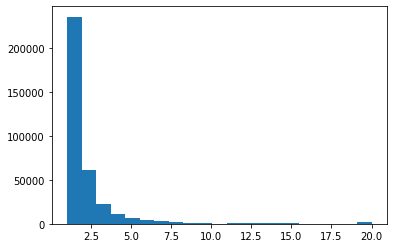

In [0]:
plt.hist(y_train[y_train>0],bins=21)
#NOTE: Note outlier in training set (and not present in val set). 
#Reason why rmse worse in train than val set. 
#Also reason R2 better in train than val set (since normalised by the mean of each set in a sense) (so R2 for now more fairly shows the extend of overfitting)

(array([0.0000e+00, 2.1271e+04, 5.0340e+03, 1.8740e+03, 9.2600e+02,
        5.4800e+02, 3.2800e+02, 2.1600e+02, 1.4600e+02, 1.3000e+02,
        8.7000e+01, 5.9000e+01, 5.9000e+01, 5.0000e+01, 4.3000e+01,
        4.3000e+01, 3.1000e+01, 2.1000e+01, 2.4000e+01, 1.4000e+01,
        2.2600e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 24 Patch objects>)

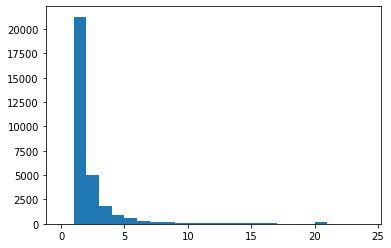

In [0]:
plt.hist(y_val[y_val>0],bins=list(range(25)))

In [0]:
print('Shape of X is ' + str(X_train.shape))
X_test.tail()

NameError: ignored

In [0]:
print(y_train.max())
print(y_train.dtype)
y_train.head()

##**LightGBM - Lightweight Gradient-Boosted Decision Tree**

In [0]:
%%time

# Adjust LGBM Parameters to see if we can get a better result
model_lgbm = LGBMRegressor(
    objective='regression', 
    boosting='gbdt',
    metric='rmse',
    device_type='cpu',
    verbosity=2,
    #output_freq=10,
    learning_rate=0.1,
    num_iterations=1000,
    early_stopping_round=25,
    feature_fraction=0.7,
    #min_data_per_group=100,
    #max_cat_to_onehot=8,
    #top_k=20,
    #max_bin=255,
    #min_data_in_bin=3,
    seed=420
)

# categorical_feature=1,2,3,4,5,6  LGBM doesn't like this as a parameter

model_lgbm.fit(X_train_np, y_train,
               eval_set=[(X_val_np, y_val)])
     

y_pred_train, y_pred_val, y_pred_test =  model_lgbm.predict(X_train_np).clip(0,20), model_lgbm.predict(X_val_np).clip(0,20), model_lgbm.predict(X_test_np).clip(0,20)
train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
print(f'R^2 train =  {train_score:.4f}    R^2 val =  {val_score:.4f}')
print(f'RMSE train = {train_rmse:.4f}    RMSE val = {val_rmse:.4f}')



/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 0.923083
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's rmse: 0.902445
[3]	valid_0's rmse: 0.889228
[4]	valid_0's rmse: 0.87449
[5]	valid_0's rmse: 0.861194
[6]	valid_0's rmse: 0.851308
[7]	valid_0's rmse: 0.84282
[8]	valid_0's rmse: 0.834042
[9]	valid_0's rmse: 0.82763
[10]	valid_0's rmse: 0.821872
[11]	valid_0's rmse: 0.817446
[12]	valid_0's rmse: 0.814188
[13]	valid_0's rmse: 0.81137
[14]	valid_0's rmse: 0.808654
[15]	valid_0's rmse: 0.806171
[16]	valid_0's rmse: 0.803759
[17]	valid_0's rmse: 0.802321
[18]	valid_0's rmse: 0.800824
[19]	valid_0's rmse: 0.799423
[20]	valid_0's rmse: 0.798574
[21]	valid_0's rmse: 0.797519
[22]	valid_0's rmse: 0.796062
[23]	valid_0's rmse: 0.795166
[24]	valid_0's rmse: 0.794643
[25]	valid_0's rmse: 0.794218
[26]	valid_0's rmse: 0.793976
[27]	valid_0's rmse: 0.793702
[28]	valid_0's rmse: 0.793539
[29]	valid_0's rmse: 0.793264
[30]	valid_0's rmse: 0.793016
[31]	valid_0's rmse: 0.792906
[32]	valid_0's rmse: 

In [0]:
# 20. like 19, but train = 20-32 val = 33
    # learning_rate=0.1,
    # num_iterations=1000,
    # early_stopping_round=5,
    # feature_fraction=0.7,
# [24]	valid_0's rmse: 0.573757
# Early stopping, best iteration is:
# [19]	valid_0's rmse: 0.573412
# R^2 train =  0.4034    R^2 val =  0.2852
# RMSE train = 0.6157    RMSE val = 0.5734
# CPU times: user 48.8 s, sys: 83.8 ms, total: 48.9 s
# Wall time: 13.9 s

# 21. like 20, but learning rate = 0.025 (train 20-32, val=33)
# [92]	valid_0's rmse: 0.572035
# [93]	valid_0's rmse: 0.571931
# Early stopping, best iteration is:
# [88]	valid_0's rmse: 0.571807
# R^2 train =  0.4116    R^2 val =  0.2892
# RMSE train = 0.6115    RMSE val = 0.5718
# CPU times: user 2min 34s, sys: 237 ms, total: 2min 34s
# Wall time: 42.4 s

# 22. like 21 but train=24-31 val=32,33, early stopping=25
# [59]	valid_0's rmse: 0.567015
# Early stopping, best iteration is:
# [34]	valid_0's rmse: 0.566461
# R^2 train =  0.4613    R^2 val =  0.3144
# RMSE train = 0.5187    RMSE val = 0.5665
# CPU times: user 59.7 s, sys: 107 ms, total: 59.8 s
# Wall time: 16.7 s

# 23. like 22, but train=24-33 val=22
# [115]	valid_0's rmse: 0.791538
# [116]	valid_0's rmse: 0.791603
# Early stopping, best iteration is:
# [91]	valid_0's rmse: 0.790763
# R^2 train =  0.4737    R^2 val =  0.3025
# RMSE train = 0.5095    RMSE val = 0.7908
# CPU times: user 1min 56s, sys: 169 ms, total: 1min 56s
# Wall time: 32.4 s

# 24. like 22, but train = 26-33 val=22


In [0]:
# run #7...
# R^2 train =  0.5775    R^2 val =  0.4957
# RMSE train = 0.4565    RMSE val = 0.4816 *****************************

# 15. Like #5, but feature_fraction .8 --> 0.7
# [198]	valid_0's rmse: 0.521692
# [199]	valid_0's rmse: 0.521679
# [200]	valid_0's rmse: 0.521659
# Did not meet early stopping. Best iteration is:
# [200]	valid_0's rmse: 0.521659
# R^2 train =  0.5042    R^2 val =  0.4085
# RMSE train = 0.4945    RMSE val = 0.5216
# CPU times: user 3min 3s, sys: 290 ms, total: 3min 3s
# Wall time: 51.1 s

# 16. Like #15, but learningRate 0.1 --> 0.2
# [199]	valid_0's rmse: 0.501111
# [200]	valid_0's rmse: 0.500774
# Did not meet early stopping. Best iteration is:
# [200]	valid_0's rmse: 0.500774
# R^2 train =  0.5362    R^2 val =  0.4550
# RMSE train = 0.4783    RMSE val = 0.5007  **********************
# CPU times: user 3min 6s, sys: 300 ms, total: 3min 6s
# Wall time: 55.5 s

# 17.  Like #16, but numberIterations 200 --> 1000
# [999]	valid_0's rmse: 0.454856
# [1000]	valid_0's rmse: 0.454802
# Did not meet early stopping. Best iteration is:
# [1000]	valid_0's rmse: 0.454802
# R^2 train =  0.6310    R^2 val =  0.5505  ***********************************
# RMSE train = 0.4266    RMSE val = 0.4547  ************************************
# CPU times: user 13min 23s, sys: 1.32 s, total: 13min 24s
# Wall time: 3min 44s

# 18.  Like #17, but use months 32 and 33 for eval/val, instead of just 33
# [988]	valid_0's rmse: 0.446508
# [989]	valid_0's rmse: 0.446508
# Early stopping, best iteration is:
# [986]	valid_0's rmse: 0.446508
# R^2 train =  0.6294    R^2 val =  0.5743 **************************************
# RMSE train = 0.4276    RMSE val = 0.4464 **************************************
# CPU times: user 13min 48s, sys: 1.13 s, total: 13min 49s
# Wall time: 3min 48s
# coursera:  1.039987 and 1.038474.

# 19. like 17, but use 24-32 for train and 33 for eval/val
# [11]	valid_0's rmse: 0.573097
# [12]	valid_0's rmse: 0.574275
# Early stopping, best iteration is:
# [9]	valid_0's rmse: 0.572829
# R^2 train =  0.4229    R^2 val =  0.2866
# RMSE train = 0.5356    RMSE val = 0.5728
# CPU times: user 22.6 s, sys: 54.9 ms, total: 22.7 s
# Wall time: 6.68 s

In [0]:
# 1. Using default parameters, and data inputs like #2 below except train months = 24 to 33 and val = 33
# [98]	valid_0's rmse: 0.52753
# [99]	valid_0's rmse: 0.527504
# [100]	valid_0's rmse: 0.527391
# Did not meet early stopping. Best iteration is:
# [100]	valid_0's rmse: 0.527391
# R^2 train =  0.4846    R^2 val =  0.3955
# RMSE train = 0.5042    RMSE val = 0.5273
# CPU times: user 1min 55s, sys: 160 ms, total: 1min 55s
# Wall time: 33.2 s ---> CPU

# 2. change learning rate from 0.1 to 0.2:
# [72]	valid_0's rmse: 0.527612
# [73]	valid_0's rmse: 0.527612
# Early stopping, best iteration is:
# [72]	valid_0's rmse: 0.527612
# R^2 train =  0.4962    R^2 val =  0.3951
# RMSE train = 0.4985    RMSE val = 0.5275
# CPU times: user 1min 22s, sys: 113 ms, total: 1min 22s
# Wall time: 24.3 s

# 3. changed learning rate to 0.05 and num_iterations from 100 to 200:
# [199]	valid_0's rmse: 0.52968
# [200]	valid_0's rmse: 0.529554
# Did not meet early stopping. Best iteration is:
# [200]	valid_0's rmse: 0.529554
# R^2 train =  0.4844    R^2 val =  0.3904
# RMSE train = 0.5043    RMSE val = 0.5295
# CPU times: user 3min 31s, sys: 321 ms, total: 3min 31s
# Wall time: 1min

# 4. changed back to defaults (LR=0.1) but set iterations to 200:
# [149]	valid_0's rmse: 0.520286
# [150]	valid_0's rmse: 0.520222
# [151]	valid_0's rmse: 0.520223
# Early stopping, best iteration is:
# [150]	valid_0's rmse: 0.520222
# R^2 train =  0.5036    R^2 val =  0.4119
# RMSE train = 0.4949    RMSE val = 0.5201
# CPU times: user 2min 35s, sys: 233 ms, total: 2min 35s
# Wall time: 45.2 s

# 5. Changed the defaults to the following values:
    # num_iterations=200, (was 100)
    # early_stopping_round=3,  (was 0)
    # feature_fraction=0.8,   (was 1.0)
# [199]	valid_0's rmse: 0.513191
# [200]	valid_0's rmse: 0.513097
# Did not meet early stopping. Best iteration is:
# [200]	valid_0's rmse: 0.513097
# R^2 train =  0.5127    R^2 val =  0.4278
# RMSE train = 0.4903    RMSE val = 0.5130
# CPU times: user 3min 4s, sys: 297 ms, total: 3min 4s
# Wall time: 52.6 s

# 6. Same as #5, but changed top_k from 20 to 40
# [199]	valid_0's rmse: 0.513191
# [200]	valid_0's rmse: 0.513097
# Did not meet early stopping. Best iteration is:
# [200]	valid_0's rmse: 0.513097
# R^2 train =  0.5127    R^2 val =  0.4278
# RMSE train = 0.4903    RMSE val = 0.5130
# CPU times: user 3min 41s, sys: 307 ms, total: 3min 41s
# Wall time: 1min 5s

# 7. Same as #5, but 1000 iterations
# [655]	valid_0's rmse: 0.481793
# [656]	valid_0's rmse: 0.481774
# [657]	valid_0's rmse: 0.4817
# [658]	valid_0's rmse: 0.4817
# [659]	valid_0's rmse: 0.4817
# [660]	valid_0's rmse: 0.4817
# Early stopping, best iteration is:
# [657]	valid_0's rmse: 0.4817
# R^2 train =  0.5775    R^2 val =  0.4957
# RMSE train = 0.4565    RMSE val = 0.4816 *********************************
# CPU times: user 8min 50s, sys: 734 ms, total: 8min 51s
# Wall time: 2min 32s

# 8. Same as #5, but min_data_per_group 100 --> 10
# [200]	valid_0's rmse: 0.513097
# Did not meet early stopping. Best iteration is:
# [200]	valid_0's rmse: 0.513097
# R^2 train =  0.5127    R^2 val =  0.4278
# RMSE train = 0.4903    RMSE val = 0.5130
# CPU times: user 3min 5s, sys: 269 ms, total: 3min 5s
# Wall time: 53 s

# 9. Same as #5, but min_data_per_group 100 --> 2
# [199]	valid_0's rmse: 0.513191
# [200]	valid_0's rmse: 0.513097
# Did not meet early stopping. Best iteration is:
# [200]	valid_0's rmse: 0.513097
# R^2 train =  0.5127    R^2 val =  0.4278
# RMSE train = 0.4903    RMSE val = 0.5130
# CPU times: user 3min 4s, sys: 239 ms, total: 3min 4s
# Wall time: 52.5 s

# 10. Same as #5, but min_data_per_group 100 --> 250
# [199]	valid_0's rmse: 0.513191
# [200]	valid_0's rmse: 0.513097
# Did not meet early stopping. Best iteration is:
# [200]	valid_0's rmse: 0.513097
# R^2 train =  0.5127    R^2 val =  0.4278
# RMSE train = 0.4903    RMSE val = 0.5130
# CPU times: user 3min 5s, sys: 296 ms, total: 3min 5s
# Wall time: 53 s

# 11. Same as #5, but max_cat_to_one_hot 4 --> 8
# [199]	valid_0's rmse: 0.513191
# [200]	valid_0's rmse: 0.513097
# Did not meet early stopping. Best iteration is:
# [200]	valid_0's rmse: 0.513097
# R^2 train =  0.5127    R^2 val =  0.4278
# RMSE train = 0.4903    RMSE val = 0.5130
# CPU times: user 3min 8s, sys: 292 ms, total: 3min 8s
# Wall time: 53.5 s

# 12. Same as #5, but max_bin 255 --> 2500
# [199]	valid_0's rmse: 0.514684
# [200]	valid_0's rmse: 0.514573
# Did not meet early stopping. Best iteration is:
# [200]	valid_0's rmse: 0.514573
# R^2 train =  0.5153    R^2 val =  0.4245
# RMSE train = 0.4890    RMSE val = 0.5145
# CPU times: user 3min 8s, sys: 258 ms, total: 3min 8s
# Wall time: 53.7 s

# 13.  Same as #5 but min_data_in_bin 3 --> 1
# [199]	valid_0's rmse: 0.514805
# [200]	valid_0's rmse: 0.514776
# Did not meet early stopping. Best iteration is:
# [200]	valid_0's rmse: 0.514776
# R^2 train =  0.5132    R^2 val =  0.4241
# RMSE train = 0.4900    RMSE val = 0.5147
# CPU times: user 3min 37s, sys: 289 ms, total: 3min 37s
# Wall time: 1min 3s

# 14. Combine 12 and 13 maxbin=2500 mindata=1 (similar for 512/1)
# [199]	valid_0's rmse: 0.513408
# [200]	valid_0's rmse: 0.513254
# Did not meet early stopping. Best iteration is:
# [200]	valid_0's rmse: 0.513254
# R^2 train =  0.5140    R^2 val =  0.4274
# RMSE train = 0.4897    RMSE val = 0.5132
# CPU times: user 3min 4s, sys: 270 ms, total: 3min 4s
# Wall time: 52.5 s

In [0]:
'''
%%time
# train model using LightGBM

X_train_model, X_val_model, X_test_model = X_train_np, X_val_np, X_test_np

model = LGBMRegressor()
model.fit(X_train_model, y_train)
y_pred_train, y_pred_val, y_pred_test =  model.predict(X_train_model).clip(0,20), model.predict(X_val_model).clip(0,20), model.predict(X_test_model).clip(0,20)
train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
print('R^2 train_score is ' + str(train_score) + ' R^2 val_score is ' + str(val_score))
print('RMSE train_score is ' + str(train_rmse) + ' RMSE val_score is ' + str(val_rmse))

# Without generated categorical features: (just taking the value stored in Andreas' v2 ipynb; not sure if this is most recent)
# R^2 train_score is 0.5108922437639128 R^2 val_score is 0.38163861354245354
# RMSE train_score is 0.8416184867414083 RMSE val_score is 0.851328159473957

# 1. With first shot at including some generated categorical features:
# R^2 train_score is 0.4871673830283305 R^2 val_score is 0.3646786484583454
# RMSE train_score is 0.586654761721401 RMSE val_score is 0.5322081738361989
# CPU times: user 2min 57s, sys: 192 ms, total: 2min 57s
# Wall time: 49.1 s

# 2. Here are the results if I just use DF.to_numpy() instead of DF.to_numpy(dtype=float16)  (I end up with uint16 dtypes)
# R^2 train_score is 0.48836824027900894 R^2 val_score is 0.36575968261979375
# RMSE train_score is 0.5859674989625443 RMSE val_score is 0.5317551903459706
# CPU times: user 3min 22s, sys: 123 ms, total: 3min 22s
# Wall time: 55.7 s
# --> slight improvement in coursera grader (best of #1,2,3,4 and #2 with unsold items sales set to 0)

# 3. Train like #2, but after computing test predictions, set predictions = 0 for items with no sales in past 6 months
#   --> coursera grader not too happy with this, gives worse scores, but grade remains 5/10

# 4. Here are the results from the last attempt, but using months <=32 for train, and only month 33 for val, and clip 20 --> 250:
# R^2 train_score is 0.26223874204479025 R^2 val_score is 0.20398385176523903
# RMSE train_score is 1.4264801517941286 RMSE val_score is 1.0928061916192278
# CPU times: user 2min 50s, sys: 104 ms, total: 2min 51s
# Wall time: 45.5 s
# --> worse on coursera than the previous

# 5. Here are results from above, but setting clip back to 20, like the earlier attempts
# R^2 train_score is 0.4818971522257163 R^2 val_score is 0.2893950060550262
# RMSE train_score is 0.5738173652542723 RMSE val_score is 0.5717097863529877
# CPU times: user 3min 29s, sys: 107 ms, total: 3min 29s
# Wall time: 57.4 s
# --> coursera slightly worse than #2 and #1 above, but better than the others

# 6.set train months from 24 to 33, and val month=33 (overlapping train)... I want train to get as close as possible to test
# R^2 train_score is 0.4911524341090605 R^2 val_score is 0.4111897309963226
# RMSE train_score is 0.501018977322913 RMSE val_score is 0.5204142579638138
# CPU times: user 2min 20s, sys: 99.9 ms, total: 2min 20s
# Wall time: 37.4 s
# --> slightly worse than the previous attempt #5

# 7. drop the columns: shop_typeB, shop_test, item_test, shop_item_test
# R^2 train_score is 0.4832235262048875 R^2 val_score is 0.387985576195249
# RMSE train_score is 0.5049073497045727 RMSE val_score is 0.5305695571697053
# CPU times: user 2min 8s, sys: 100 ms, total: 2min 8s
# Wall time: 35 s

# 8. also drop cat4 stats & lags, and increase cartesian fill back to month 10, and include lags 1,2,3,4,5,6 instead of just 1,2,3... train 10-33, val=33
# R^2 train_score is 0.47397413468100047 R^2 val_score is 0.3541106108004789
# RMSE train_score is 0.5812099836323634 RMSE val_score is 0.5206025235255616
# CPU times: user 6min 2s, sys: 1.97 s, total: 6min 4s
# Wall time: 1min 37s
# --> coursera score nearly identical to #5

# 9. train 10-30, val = 31,32,33 lags = 1,2,3,4
# R^2 train_score is 0.48184056676610665 R^2 val_score is 0.3578670993442651
# RMSE train_score is 0.5916670101233873 RMSE val_score is 0.5110675263409217
# CPU times: user 4min 29s, sys: 224 ms, total: 4min 29s
# Wall time: 1min 17s
# --> coursera score slightly worse than previous

# 10.  train 24-33 val=33 lags= 1-6
# R^2 train_score is 0.48632294943758003 R^2 val_score is 0.39896317143904403
# RMSE train_score is 0.4808905768788801 RMSE val_score is 0.5022011884126181
# CPU times: user 2min 26s, sys: 139 ms, total: 2min 26s
# Wall time: 39.1 s
# --> coursera score a tiny bit better than #8
'''
nocode=True

R^2 train_score is 0.48632294943758003 R^2 val_score is 0.39896317143904403
RMSE train_score is 0.4808905768788801 RMSE val_score is 0.5022011884126181
CPU times: user 2min 26s, sys: 139 ms, total: 2min 26s
Wall time: 39.1 s


####Feature Importance and Submission of Results for LightGBM

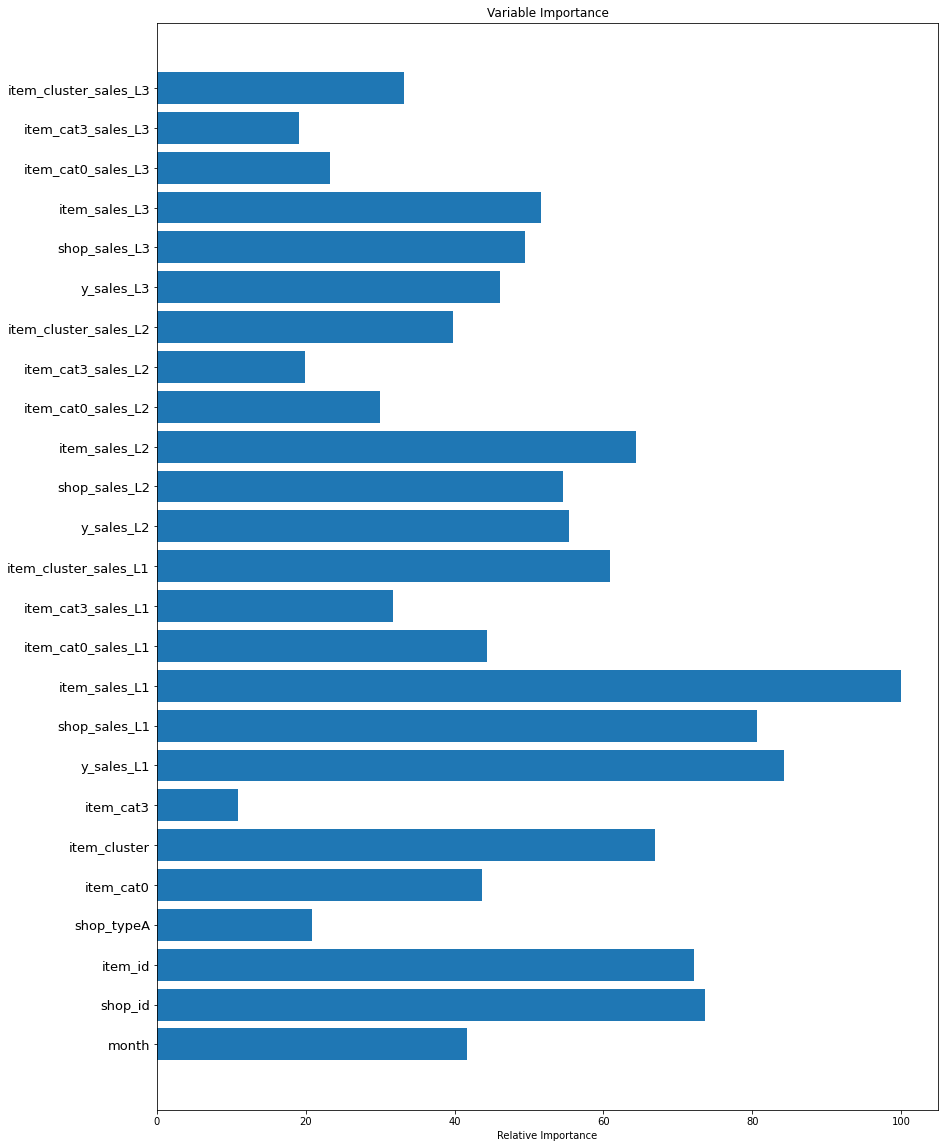

<Figure size 432x288 with 0 Axes>

In [0]:
# Plot feature importance - Results Visualization
feature_importance = model_lgbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.arange(feature_importance.shape[0])
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(14,20)) 
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tick_params(axis='y', which='major', labelsize = 13)
plt.show()
plt.savefig('LGBM_feature_importance_v1.4_mg.png')

Submission prep

In [0]:
# Merge the test predictions with IDs from the original test dataset, and keep only columns "ID" and "item_cnt_month"
y_pr_test_mrg = pd.DataFrame.from_dict({'item_cnt_month':y_pred_test,'shop_id':X_test.shop_id,'item_id':X_test.item_id})
y_pr_test_mrg = test.merge(y_pr_test_mrg, on=['shop_id','item_id'], how= 'left').reset_index(drop=True)
y_submission = y_pr_test_mrg.drop(['shop_id','item_id'],axis=1)
print(len(y_submission))
print(y_submission.head())

214200
   ID  item_cnt_month
0   0           1.029
1   1           0.053
2   2           0.827
3   3           0.196
4   4           0.175


In [0]:
'''
# It looks like the average prediction for items that haven't sold in the previous 6 months before month 34
#   is roughly 1647 / 23982 = 0.07
#
# Let's try setting these items' predictions to 0 and see if the grader is happy
'''

# Nope, this actually made things slightly worse per the coursera grader

'''
nosales = y_pr_test_mrg.loc[y_pr_test_mrg['item_id'].isin(items_6mo_in_test)]
print(len(nosales))
print(nosales.item_cnt_month.sum())
nosales['item_cnt_month'] = 0
y_pr_test_mrg = y_pr_test_mrg.merge(nosales[['shop_id','item_id','item_cnt_month']], on=['shop_id','item_id'], how='left').fillna(1)
print(len(y_pr_test_mrg))
print(y_pr_test_mrg.head())
y_pr_test_mrg['item_cnt_month'] = 0
y_pr_test_mrg = y_pr_test_mrg.eval('item_cnt_month = item_cnt_month_x * item_cnt_month_y')
print(len(y_pr_test_mrg))
print(y_pr_test_mrg.head())
nosales = y_pr_test_mrg.loc[y_pr_test_mrg['item_id'].isin(items_6mo_in_test)]
print(len(nosales))
print(nosales.item_cnt_month.sum())

y_submission = y_pr_test_mrg.drop(['shop_id','item_id','item_cnt_month_x','item_cnt_month_y'],axis=1)
print(len(y_submission))
print(y_submission.head())
'''
nocode=True

In [0]:
model_name = 'LGBMv1p4mg_18'

%cd "{GDRIVE_REPO_PATH}"

y_submission.to_csv("./models_and_predictions/" + model_name + '_submission.csv', index=False)


/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag


In [0]:
# # save predictions for an ensemble
# pickle.dump(y_pred_train, open("./models_and_predictions/" + model_name + '_pred_train.pickle', 'wb'))
# pickle.dump(y_pred_val, open("./models_and_predictions/" + model_name + '_pred_val.pickle', 'wb'))
# pickle.dump(y_pred_test, open("./models_and_predictions/" + model_name + '_pred_test.pickle', 'wb'))

# # save the model to disk
# pickle.dump(model, open("./models_and_predictions/" + model_name + '_model.sav', 'wb'))

 
# # load the model from disk
# loaded_model = pickle.load(open(model_file_name, 'rb'))

#**Mike's Progress Boundary**
---
---

##**Model Fitting, Validation, Prediction, and Results Submission**
* Linear Regression
* LightGBM
* XGBoost

###**Linear Regression Model**

suffers from the poor encoding of our categorical variables; we can revisit this after encoding with a method other than ordinal

####Model-Specific Feature Set
* Recode Ordinal-Encoded Categorical Features for similar value ranges between the features, so they will have similar weight as inputs to the model
* However, StandardScaler will not remove the undesired "ordinality" of the category coding.  In future, we need to do something like mean encoding, one-hot encoding, or dense one-hot (embedded) encoding.

In [0]:
#Remove categorical features unless encoded (e.g one-hot encoding) for basically any method other than a tree method (Linear Regresion, Neural Networks etc)
# from sklearn.preprocessing import StandardScaler
LinRegFeaturesToDrop= ['month', 'shop_id', 'item_id', 'item_cat0']
scaler =  StandardScaler()

X_train_LinReg = scaler.fit_transform(X_train.drop(LinRegFeaturesToDrop, axis = 1))
X_val_LinReg = scaler.transform(X_val.drop(LinRegFeaturesToDrop, axis = 1))
X_test_LinReg = scaler.transform(X_test.drop(LinRegFeaturesToDrop, axis = 1))
feature_names_LinReg = X_train.drop(LinRegFeaturesToDrop, axis = 1).columns

In [0]:
feature_names = X_train.columns
X_train_np = X_train.to_numpy(dtype = np.float16)
del X_train
X_val_np = X_val.to_numpy(dtype = np.float16)
del X_val
X_test_np = X_test.to_numpy(dtype = np.float16)
del X_test
X_train_np.nbytes/(10**6)

638.256072

####Model Training for Linear Regression

In [0]:
#import sklearn
#from sklearn.linear_model import LinearRegression
X_train_model, X_val_model, X_test_model = X_train_LinReg, X_val_LinReg, X_test_LinReg
model = LinearRegression()
model.fit(X_train_model, y_train)

y_pred_train, y_pred_val, y_pred_test =  model.predict(X_train_model).clip(0,20), model.predict(X_val_model).clip(0,20), model.predict(X_test_model).clip(0,20)
train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
print('R^2 train_score is ' + str(train_score) + ' R^2 val_score is ' + str(val_score))
print('RMSE train_score is ' + str(train_rmse) + ' RMSE val_score is ' + str(val_rmse))

R^2 train_score is 0.08517523446851238 R^2 val_score is 0.05999361085512289
RMSE train_score is 8.668098180391704 RMSE val_score is 10.774036139925371


####Feature Importance for Linear Regression

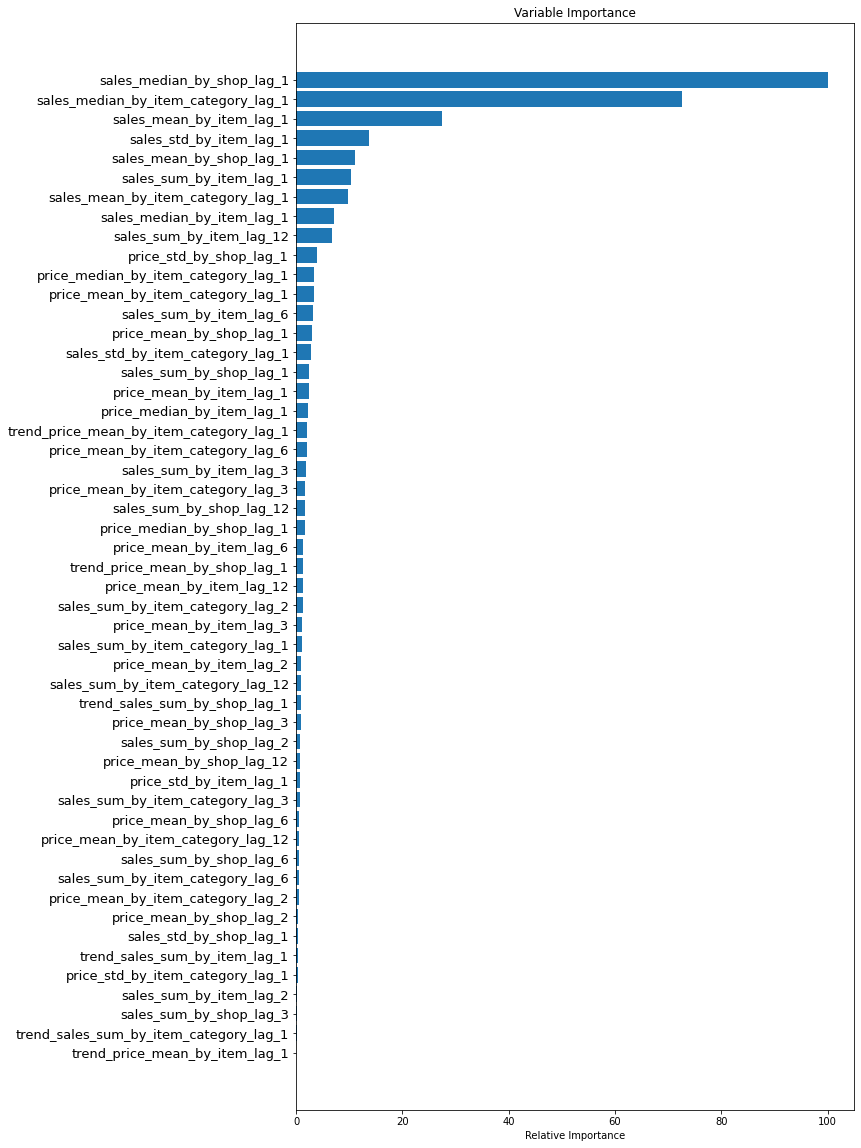

<Figure size 432x288 with 0 Axes>

In [0]:
feature_importance = np.abs(model.coef_)
# summarize feature importance
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,20)) 
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names_LinReg[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tick_params(axis='y', which='major', labelsize = 13)
plt.show()
plt.savefig('LinReg_feature_importance.png')

In [0]:
X_train_LinReg.columns

####Submission Prep for Linear Regression

In [0]:
#Folder to save models and predictions
%cd "{os.join(GDRIVE_REPO_PATH,'/models_and_predictions')}"

In [0]:
model_name = 'LinRegv2_mg'


submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_pred_test
})
submission.to_csv(model_name + '_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(y_pred_train, open(model_name + '_pred_train.pickle', 'wb'))
pickle.dump(y_pred_val, open(model_name + '_pred_val.pickle', 'wb'))
pickle.dump(y_pred_test, open(model_name + '_pred_test.pickle', 'wb'))

# save the model to disk
pickle.dump(model, open(model_name + '_model.sav', 'wb'))
 
# # load the model from disk
# loaded_model = pickle.load(open( model_name + '_model.sav', 'rb'))
# print(result)

In [0]:
submission.head()

,ID,item_cnt_month
0,0,0.620781
1,1,0.429811
2,2,0.416615
3,3,0.469035
4,4,0.434907


###**XGBoost - Gradient-Boosted Decision Tree**

In [0]:
%%time
X_train_model, X_val_model, X_test_model = X_train_np, X_val_np, X_test_np

model = XGBRegressor()
model.fit(X_train_model, y_train)

y_pred_train, y_pred_val, y_pred_test =  model.predict(X_train_model).clip(0,20), model.predict(X_val_model).clip(0,20), model.predict(X_test_model).clip(0,20)
train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
print('R^2 train_score is ' + str(train_score) + 'R^2 val_score is ' + str(val_score))
print('RMSE train_score is ' + str(train_rmse) + 'RMSE val_score is ' + str(val_rmse))

[21:24:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 train_score is 0.09796589353051244R^2 val_score is 0.06403915444253994
RMSE train_score is 8.607288197126733RMSE val_score is 10.750826813311914


####Feature Importance and Submission of Results for XGBoost

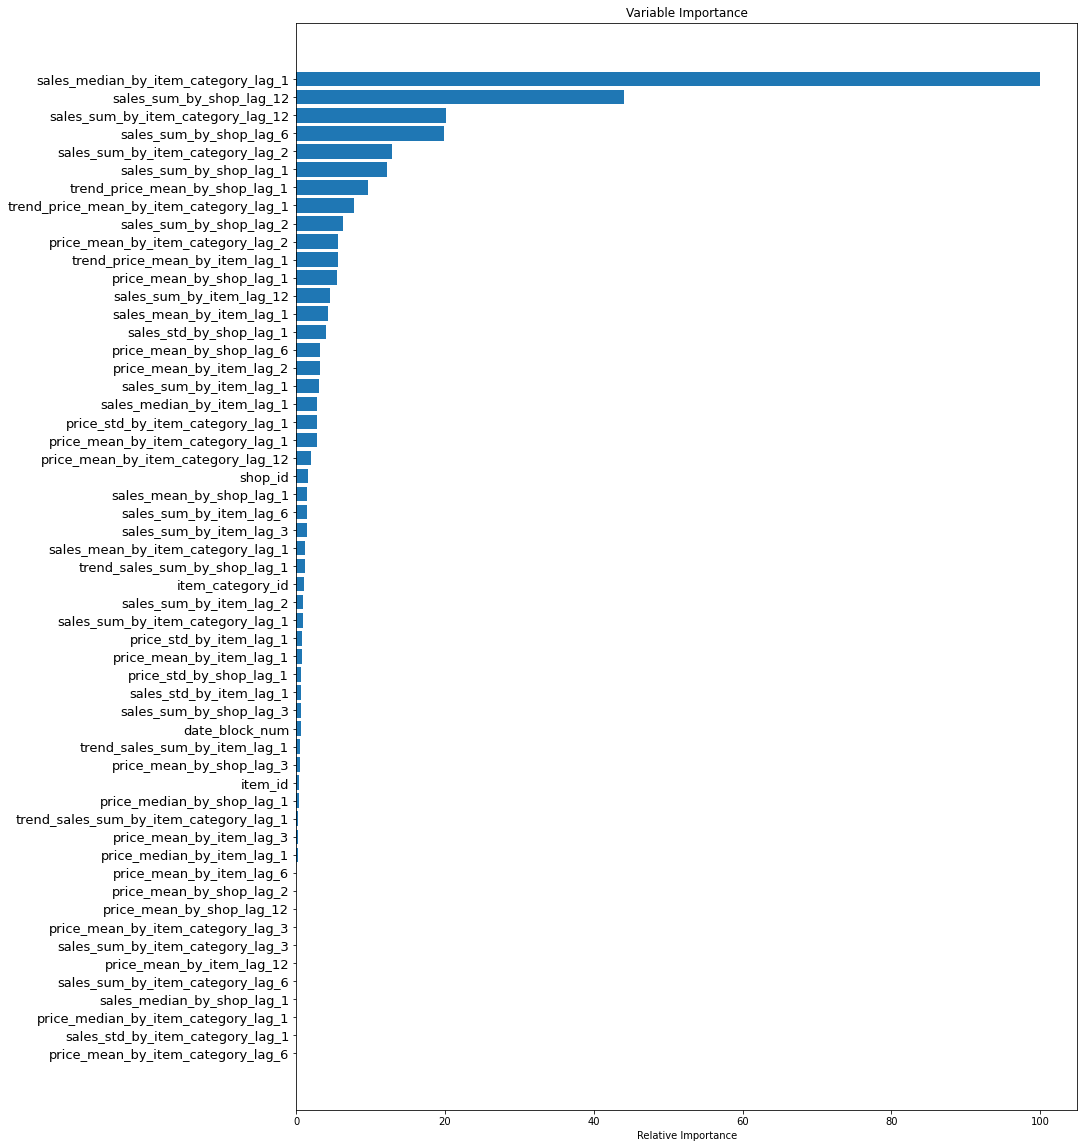

<Figure size 432x288 with 0 Axes>

In [0]:
# Plot feature importance - Results Visualization
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(14,20)) 
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tick_params(axis='y', which='major', labelsize = 13)
plt.show()
plt.savefig('gbt_feature_importance_mg.png')

Sumbission prep

In [0]:
model_name = 'XGBv2'

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_pred_test
})
submission.to_csv(model_name + '_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(y_pred_train, open(model_name + '_pred_train.pickle', 'wb'))
pickle.dump(y_pred_val, open(model_name + '_pred_val.pickle', 'wb'))
pickle.dump(y_pred_test, open(model_name + '_pred_test.pickle', 'wb'))

# save the model to disk
pickle.dump(model, open(model_name + '_model.sav', 'wb'))

 
# # load the model from disk
# loaded_model = pickle.load(open(model_file_name, 'rb'))

#**Miscellaneous Code Snippets and Thoughts for Future Work**

##**Important to Revisit**

###**To-Do List**

####1. **Test/Train Split**
* **Don't Shuffle for now** ... Time-series data generally benefits from being fed to model without shuffling (Andreas).</br>
Although, I'm curious about shuffling the training/val data rows, within a given month at least, and after split.  I definitely think the val data should come from the last xx months, where xx= 1 to 6, depending on size of dataset, and month range of truncated data set.
* **Possible Model Split or Additional Feature**... Consider sales variance by_year or by_2years (instead of by_month) for items with low price, vs. variance for items with high price... (or, low/high sales)... sales trends could be different enough that we might benefit from adding such a feature, or from training multiple models with training/val/test data split according to the focus of each model. </br> Based on the graphics of feature importance generated by Andreas, I'm not sure this is a big issue, but if I'm understanding correctly, the std is only calculated on a monthly grouping, and not on the entire sales_train set.  The std might be more important if mean or median of 6, 12, 18, or 24 months is made into a feature.


####2. **Weighting of shops and items based on recent behavior**
* **Explicit Forcing of Predictions = 0** for items or shops that have zero sales in the past 3, 6, or 12 months (as if the shop closed, or as if the item is no longer being sold).  Need to first check the months at 11, 12, 13 before the test month, to make sure shop opening, or item for sale is not a seasonal thing.
* **Weighting for shops based on integral of sales**... The thought is that Andreas' feature importance plot shows trend-based features to be of minor importance, so it may be more relevant to look at trend-based features where final month (or two or three) have zero sales vs. those that have trends without zero sales. (e.g., if zero sales for months 30-33, or if 500 sales for months 30-33, you have same trend, but would want to make very different predictions... so trend may be more relevant when combining with some knowledge about number of sales, like a feature = "trend x total sales."  (i.e., the integral of sales rather than the slope of sales).  This might be simply done with pandas' "rolling" method.


####3. **Feature Adjustment**
* **Re-Scale the Stats-Based Features**... perhaps not important for decision tree models, but other models will probably benefit by scaling everything to the same range (perhaps int16 or uint16). Or, scale to slightly different ranges, based on intuition of feature importance.  Sales by shop_item pair per month is likely more important than sales by item_cat4 per month, yet the latter is presently substantially larger than the former.
* **Better encoding for categorical features**... instead of a random-ordinal encoding or a pure ordinal encoding, we should reduce the influence of encoding on feature behavior. Consider mean-encoding or sklearn.feature_extraction.FeatureHasher or TensorFlow embedded categorization to keep number of features down? Could be more memory-friendly than one-hot encoding.
* **Workdays and Holidays per month** ... Adjust item_cnt_day by number of days in month block; also adjust for holidays and weekends, if it is clear there are no sales on such days.  Or, give different weight to sales on weekends or holidays if we see these dominate the sales vs. if they have very few sales. (Scale by number of weekends/holidays in each month vs. Nov. 2015).  Need to do further EDA first, to see if there really is a deviation of sales on these non-standard days, probably using original dataset grouped by shop_id.</br>
Also need to check on monthly behavior... months like December, January, and February may behave differently than other months because of Christmas and because of the large concentration of Russian holidays.  It could make sense to scale the sales of these months so they fit better the overall trends of sales from October to March.  In this way, we feed the model a better-behaved dataset that is not overly influenced by crazy months (particularly, since we are given November as test, and will validate on "smooth" months like October, or Sept+Oct, or Aug+Sept+Oct... and won't be doing any test/val on crazy months)


####4. **Data Memory Requirements and Model Training Time**
* **Expanding the Number of Rows in Test/Val**... Consider expansion of cartesian-product size and number of dataframe months being kept for test/val, if things are running quickly and without huge memory requirements.
* **More Categ. Features**... Consider expansion of the number of categorical generated features that are included.  I so far have only chosen a few, which I though matched with Andreas' output of feature importance.
* **More Stats Features**... Consider expansion of the number of stats features to be included.  I chose to use only the sum() aggregation function because it was simple to implement and understand, and matched well with Andreas' feature importance.  I could add in other stats like std, or (as described above) something like a rolling integral, or some other stat aggregation where instead of "by_month", it could be "by_3mo" or "by_season"
* **Interpolating Price for Cartesian-Product Rows**... Consider inclusion of price in the train/val/test data, where some sort of interpolation is used to fill the empty values after cartesian-product merge.  Maybe something simple like ffill or a fast algorithm.
* **Interpolating Sales for Cartesian-Product Rows**... Consider the case where sales_train doesn't represent *all* sales over that time period... some shop-item combinations may have nonzero sales, but were not included in the sales_train dataset for some reason.  (I don't think we were given any guarantees that sales_train was a complete representation of all sales.)  We may want to run training/val after cartesian-product merge, and see if it gives nonzero sales predictions for any of the newly-merged rows.  Then, we use these predictions, re-generate the features, and re-train the model.  Repeat as long as the model keeps getting better.  (This could also be a way to refine or interpolate for *price* if we choose to use it as a feature or feature generator.)



####Done:
* pd.cut or pd.qcut to reduce complexity of item price feature --> int16
* When grouping by month, use sum() for item_cnt_day, but use median() for other integer type features so the feature column will also be an integer (not sure if this is going to be strictly true, after watching how pandas behaves... I believe I saw one time where pandas gave the median as something like 100.5, to show that values 100 and 101 were equally centered in the data.  So instead of choosing one of these integer values, it may return a float.... I need to check if this can be set in the median() parameters, or if downcasting to an integer forces it to round the float properly vs. generating a crazy number or a NaN)
* Temporarily merge test rows into training data set before performing feature generation, so that where desirable, the feature generation is applied in a way that gives minimal "special treatment" to test or train sets.
* Convert data types and category encodings so as to use minimal memory (int8 or int16 better than int32, int64, float32, string).
* Similarly, focus on most important features (as determined from earlier modeling experiments by Andreas), and delete less-helpful columns to reduce memory requirements.
* Also, discard features (luckily mostly of secondary importance) that need to be stored with 4 or more bytes, as these features rapidly grow the dataset size.
* Be sure to reset_index(drop=True) as this can save many Megabytes if it had changed to the default int64. (I don't know yet exactly when pandas decides to do this... probably after something like a merge or group operation that can influence the index.  Anyhow... just be sure to reset the index when memory is of importance.)
* Keep dataset size down by judiciously choosing shops/items to use in cartesian-product when filling out the sparse sales_train data to better match the test set shop/item pairs.
* Keep number of lag features relatively small, and the number of months in the biggest lag to be reasonably small, so we can drop a significant number of early months from the training data.


###**Using Feathering to Save / Load Large Datafiles More Quickly**

In [0]:
# import pandas as pd
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# data_gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks'
# os.chdir(data_gdrive_repo_path)

data_folder = 'models_and_predictions/'
filename = 'TS_Stats-Features-for-Modelling-v3_mg.feather'

In [0]:
data = matrix[matrix['month'] >= 14]
data.reset_index().astype('float32').to_feather(data_folder + filename)

In [0]:
data = pd.read_feather(data_folder + filename, columns=None, use_threads=True)
data = data.astype({'index': np.int32}).set_index('index')
cols_by_types = infer_variable_types(matrix)
data = sort_variable_types(data, categorical_cols = cols_by_types['categorical'], numerical_cols = cols_by_types['numerical'])
data.tail()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_2,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,sales_mean_by_item_lag_1,sales_mean_by_item_lag_2,sales_mean_by_item_lag_3,sales_mean_by_item_lag_6,sales_mean_by_item_lag_12,price_mean_by_shop_lag_1,price_mean_by_shop_lag_2,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,sales_mean_by_shop_lag_1,sales_mean_by_shop_lag_2,sales_mean_by_shop_lag_3,sales_mean_by_shop_lag_6,sales_mean_by_shop_lag_12,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_2,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,sales_mean_by_item_category_lag_1,sales_mean_by_item_category_lag_2,sales_mean_by_item_category_lag_3,sales_mean_by_item_category_lag_6,sales_mean_by_item_category_lag_12,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,trend_price_mean_by_item_lag_1,trend_price_mean_by_item_lag_3,trend_price_mean_by_item_lag_6,trend_price_mean_by_item_lag_12,trend_sales_mean_by_item_lag_1,trend_sales_mean_by_item_lag_3,trend_sales_mean_by_item_lag_6,trend_sales_mean_by_item_lag_12,trend_price_mean_by_shop_lag_1,trend_price_mean_by_shop_lag_3,trend_price_mean_by_shop_lag_6,trend_price_mean_by_shop_lag_12,trend_sales_mean_by_shop_lag_1,trend_sales_mean_by_shop_lag_3,trend_sales_mean_by_shop_lag_6,trend_sales_mean_by_shop_lag_12,trend_price_mean_by_item_category_lag_1,trend_price_mean_by_item_category_lag_3,trend_price_mean_by_item_category_lag_6,trend_price_mean_by_item_category_lag_12,trend_sales_mean_by_item_category_lag_1,trend_sales_mean_by_item_category_lag_3,trend_sales_mean_by_item_category_lag_6,trend_sales_mean_by_item_category_lag_12,above_12m_mean_price_mean_by_item,above_12m_mean_sales_mean_by_item,above_12m_mean_price_mean_by_shop,above_12m_mean_sales_mean_by_shop,above_12m_mean_price_mean_by_item_category,above_12m_mean_sales_mean_by_item_category
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11128045,34,46,12470,0.0,193773,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
11128046,34,41,12470,0.0,198873,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
11128047,34,44,12470,0.0,203973,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
11128048,34,39,12470,0.0,209073,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
11128049,34,45,12470,0.0,214173,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
data = data.loc[:,~data.columns.str.startswith('above_12m_mean_')]
data.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_2,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,sales_mean_by_item_lag_1,sales_mean_by_item_lag_2,sales_mean_by_item_lag_3,sales_mean_by_item_lag_6,sales_mean_by_item_lag_12,price_mean_by_shop_lag_1,price_mean_by_shop_lag_2,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,sales_mean_by_shop_lag_1,sales_mean_by_shop_lag_2,sales_mean_by_shop_lag_3,sales_mean_by_shop_lag_6,sales_mean_by_shop_lag_12,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_2,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,sales_mean_by_item_category_lag_1,sales_mean_by_item_category_lag_2,sales_mean_by_item_category_lag_3,sales_mean_by_item_category_lag_6,sales_mean_by_item_category_lag_12,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,trend_price_mean_by_item_lag_1,trend_price_mean_by_item_lag_3,trend_price_mean_by_item_lag_6,trend_price_mean_by_item_lag_12,trend_sales_mean_by_item_lag_1,trend_sales_mean_by_item_lag_3,trend_sales_mean_by_item_lag_6,trend_sales_mean_by_item_lag_12,trend_price_mean_by_shop_lag_1,trend_price_mean_by_shop_lag_3,trend_price_mean_by_shop_lag_6,trend_price_mean_by_shop_lag_12,trend_sales_mean_by_shop_lag_1,trend_sales_mean_by_shop_lag_3,trend_sales_mean_by_shop_lag_6,trend_sales_mean_by_shop_lag_12,trend_price_mean_by_item_category_lag_1,trend_price_mean_by_item_category_lag_3,trend_price_mean_by_item_category_lag_6,trend_price_mean_by_item_category_lag_12,trend_sales_mean_by_item_category_lag_1,trend_sales_mean_by_item_category_lag_3,trend_sales_mean_by_item_category_lag_6,trend_sales_mean_by_item_category_lag_12
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
638,14,2,27,0.0,0,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
639,14,3,27,0.0,0,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
640,14,4,27,0.0,0,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
641,14,5,27,0.0,0,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
642,14,6,27,0.0,0,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##**Stashed Code, May or May Not Be Important in Future**

###**EDA (Andreas' Early Work)**

In [0]:
data = matrix
df1 = data.describe(include = 'all')
df1.loc['dtype'] = data.dtypes
df1.loc['size'] = len(data)
df1.loc['% Null_count'] = data.isnull().mean()
df1

,date_block_num,shop_id,item_id
count,1.09138e+07,1.09138e+07,1.09138e+07
mean,14.9733,31.1872,11309.3
std,9.49562,17.3496,6209.98
min,0,0,0
25%,7,16,5976
50%,14,30,11391
75%,23,46,16605
max,33,59,22169
dtype,int8,int8,int16
size,10913850,10913850,10913850


### **Feature Generation/Engineering (Andreas' Early Work)**

Time series features
*   Statistics of previous months (e.g. mean of item_price for a specific item/shop in previous months)
*   Trends of previous months - rate of change of the above statistics based features (e.g. rate of change of mean item_price from today to the past 3 months for a specific shop/item)




####1.1) Statistics-Based Features

> Compute their "real-time" values (will follow with time-lag computations)


In [0]:
#Compute sum, mean, std, and median of item price/item cnt for the below categories:
#Maybe include count?

#1)
#per month and item_id
monthly_sales_per_item = sales_train.groupby(['month','item_id']).agg({'item_price': ['mean', 'std', 'median'],
                                                               'item_cnt_day': ['sum', 'mean', 'std', 'median']
                                                               })
monthly_sales_per_item.columns = ['price_mean_by_item', 'price_std_by_item', 'price_median_by_item',
                 'sales_by_item', 'sales_mean_by_item', 'sales_std_by_item', 'sales_median_by_item']
monthly_sales_per_item.reset_index(inplace=True)
matrix = pd.merge(matrix, monthly_sales_per_item, on=['month','item_id'], how='left')

#2)
#per month and shop_id
monthly_sales_per_shop = sales_train.groupby(['month','shop_id']).agg({'item_price': ['mean', 'std', 'median'],
                                                               'item_cnt_day': ['sum', 'mean', 'std', 'median']})
monthly_sales_per_shop.columns = ['price_mean_by_shop', 'price_std_by_shop', 'price_median_by_shop',
                 'sales_by_shop', 'sales_mean_by_shop', 'sales_std_by_shop', 'sales_median_by_shop']
monthly_sales_per_shop.reset_index(inplace=True)
matrix = pd.merge(matrix, monthly_sales_per_shop, on=['month','shop_id'], how='left')

#3)
#per month and item_category
monthly_sales_per_item_category = sales_train.groupby(['month','item_cat0']).agg({'item_price': ['mean', 'std', 'median'],
                                                               'item_cnt_day': ['sum', 'mean', 'std', 'median']})
monthly_sales_per_item_category.columns = ['price_mean_by_item_category', 'price_std_by_item_category', 'price_median_by_item_category',
                 'sales_by_item_category', 'sales_mean_by_item_category', 'sales_std_by_item_category', 'sales_median_by_item_category']

monthly_sales_per_item_category.reset_index(inplace=True)
matrix = pd.merge(matrix, monthly_sales_per_item_category, on=['month','item_cat0'], how='left')

#4)
#per month, item_id, and shop_id
monthly_sales_per_shop_and_item = sales_train.groupby(['month','item_id', 'shop_id']).agg({'item_price': ['mean', 'std', 'median'],
                                                               'item_cnt_day': ['sum', 'mean', 'std', 'median']})
monthly_sales_per_shop_and_item.columns = ['price_mean_by_item_and_shop', 'price_std_by_item_and_shop', 'price_median_by_item_and_shop',
                 'sales_by_item_and_shop', 'sales_mean_by_item_and_shop', 'sales_std_by_item_and_shop', 'sales_median_by_item_and_shop']

monthly_sales_per_shop_and_item.reset_index(inplace=True)
matrix = pd.merge(matrix, monthly_sales_per_shop_and_item, on=['month','item_id', 'shop_id'], how='left')

#5)
#per month
monthly_sales_per_date_block = sales_train.groupby(['month']).agg({'item_price': ['mean', 'std', 'median'],
                                                               'item_cnt_day': ['sum', 'mean', 'std', 'median']})
monthly_sales_per_date_block.columns = ['price_mean_by_month', 'price_std_by_month', 'price_median_by_month',
                 'sales_by_month', 'sales_mean_by_month', 'sales_std_by_month', 'sales_median_by_month']

monthly_sales_per_date_block.reset_index(inplace=True)
matrix = pd.merge(matrix, monthly_sales_per_date_block, on=['month'], how='left')

#WARNING: FIX DOWNCASTING FOR 'sales_BY_MONTH' COL - it turns to inf with float16
matrix = downcast_df(matrix)

matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,price_mean_by_item,price_std_by_item,price_median_by_item,sales_sum_by_item,sales_mean_by_item,sales_std_by_item,sales_median_by_item,price_mean_by_shop,price_std_by_shop,price_median_by_shop,sales_sum_by_shop,sales_mean_by_shop,sales_std_by_shop,sales_median_by_shop,price_mean_by_item_category,price_std_by_item_category,price_median_by_item_category,sales_sum_by_item_category,sales_mean_by_item_category,sales_std_by_item_category,sales_median_by_item_category,price_mean_by_item_and_shop,price_std_by_item_and_shop,price_median_by_item_and_shop,sales_sum_by_item_and_shop,sales_mean_by_item_and_shop,sales_std_by_item_and_shop,sales_median_by_item_and_shop,price_mean_by_month,price_std_by_month,price_median_by_month,sales_sum_by_month,sales_mean_by_month,sales_std_by_month,sales_median_by_month
0,0,0,19,0.0,0,40,28.0,NaN,28.0,1.0,1.0,NaN,1.0,531.50,1148.0,231.0,5576.0,1.164062,0.559570,1.0,244.5,126.3125,199.0,33504.0,1.145508,0.705078,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710.5,1244.0,399.0,131479.0,1.136719,0.679688,1.0
1,0,1,19,0.0,0,40,28.0,NaN,28.0,1.0,1.0,NaN,1.0,511.75,1156.0,226.0,2948.0,1.093750,0.478760,1.0,244.5,126.3125,199.0,33504.0,1.145508,0.705078,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710.5,1244.0,399.0,131479.0,1.136719,0.679688,1.0
2,0,2,19,0.0,0,40,28.0,NaN,28.0,1.0,1.0,NaN,1.0,960.50,1755.0,499.0,1146.0,1.070312,0.348145,1.0,244.5,126.3125,199.0,33504.0,1.145508,0.705078,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710.5,1244.0,399.0,131479.0,1.136719,0.679688,1.0
3,0,3,19,0.0,0,40,28.0,NaN,28.0,1.0,1.0,NaN,1.0,734.50,1099.0,399.0,767.0,1.024414,0.153198,1.0,244.5,126.3125,199.0,33504.0,1.145508,0.705078,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710.5,1244.0,399.0,131479.0,1.136719,0.679688,1.0
4,0,4,19,0.0,0,40,28.0,NaN,28.0,1.0,1.0,NaN,1.0,702.50,1262.0,349.0,2114.0,1.116211,0.488770,1.0,244.5,126.3125,199.0,33504.0,1.145508,0.705078,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710.5,1244.0,399.0,131479.0,1.136719,0.679688,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11128045,34,46,12470,0.0,193773,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128046,34,41,12470,0.0,198873,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128047,34,44,12470,0.0,203973,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128048,34,39,12470,0.0,209073,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#####TEMPORARY
'''
tmp_features_to_drop = [
                        #'sales_mean_by_item', 'sales_mean_by_shop', 'sales_mean_by_item_category',
'price_mean_by_item_and_shop', 'price_std_by_item_and_shop', 'price_median_by_item_and_shop',
'sales_by_item_and_shop', 'sales_mean_by_item_and_shop', 'sales_std_by_item_and_shop', 'sales_median_by_item_and_shop',
'price_mean_by_month', 'price_std_by_month', 'price_median_by_month',
'sales_by_month', 'sales_mean_by_month', 'sales_std_by_month', 'sales_median_by_month'
]
matrix = matrix.drop(tmp_features_to_drop, axis = 1)
'''
nocode = True

####1.2) Statistics-Based Features -- Time Lag

> Lag them (put them in the same row/month as the one you'll be using them to predict - e.g e.g if going to use 6 month ago mean of item_price to predict item_cnt of next month, put 6 month ago mean of item_price in the same row as current month's values, used to predict next month)


In [0]:
ts = time.time()

#---------------------------Create Time series based features--------------------------
#TS based features = features computed based on stats (just mean in this case) of item price/cnt of shops or item at different previous months/lags

#ToDo: parallelize this process and the below

TS_lags = [
           1, 3, 6, 12
           2,           #Need 2,4,7,13 lags to calculate 1m, 3m, 6m, 12m trends
           #4, 7, 13
           ]

TS_features = ['price_mean_by_item', 'sales_by_item', 'price_mean_by_shop',
               'sales_by_shop', 'price_mean_by_item_category', 'sales_by_item_category']

for i in range(len(TS_features)):
  matrix_lagged = lag_feature(matrix, TS_lags, TS_features[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['month','shop_id','item_id'], how='left')

print(time.time()-ts)


205.61352038383484


In [0]:
#---------------------------Create Stats based features--------------------------------
#Stats based features = features computed based on stats of item price/cnt of shops or item for just the previous month

ts = time.time()
Stats_lags = [1]

Stats_features = [
                  'price_std_by_item', 'price_median_by_item',
                 'sales_std_by_item', 'sales_median_by_item',
                 'price_std_by_shop', 'price_median_by_shop',
                 'sales_std_by_shop', 'sales_median_by_shop',
                 'price_std_by_item_category', 'price_median_by_item_category',
                 'sales_std_by_item_category', 'sales_median_by_item_category',
                  'sales_mean_by_item', 'sales_mean_by_shop', 'sales_mean_by_item_category' ,
                  'price_mean_by_item_and_shop', 'price_std_by_item_and_shop', 'price_median_by_item_and_shop',
                  'sales_by_item_and_shop', 'sales_mean_by_item_and_shop', 'sales_std_by_item_and_shop', 'sales_median_by_item_and_shop',
                  'price_mean_by_month', 'price_std_by_month', 'price_median_by_month',
                  'sales_by_month', 'sales_mean_by_month', 'sales_std_by_month', 'sales_median_by_month'
                ]
                                  
'''

'''
#Splitting Stats_features as below helped as a quick fix for the session getting crashed from running out of RAM (if GPU still crashes, use TPU for this one - has more RAM)
length = len(Stats_features)
index = length//3
Stats_features_first = Stats_features[:index]
Stats_features_second = Stats_features[index:(index*2)]
Stats_features_third = Stats_features[(index*2):]

for i in range(len(Stats_features_first)):
  matrix_lagged = lag_feature(matrix, Stats_lags, Stats_features_first[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['month','shop_id','item_id'], how='left')
del matrix_lagged


In [0]:
for i in range(len(Stats_features_second)):
  matrix_lagged = lag_feature(matrix, Stats_lags, Stats_features_second[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['month','shop_id','item_id'], how='left')
del matrix_lagged

In [0]:
for i in range(len(Stats_features_third)):
  matrix_lagged = lag_feature(matrix, Stats_lags, Stats_features_third[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['month','shop_id','item_id'], how='left')
del matrix_lagged

fetures_to_drop = TS_features + Stats_features #features are renamed and added as a new column within the lag_features functions, so remove these one
matrix = matrix.drop(fetures_to_drop, axis = 1)
matrix = matrix.fillna(0)
matrix[matrix['month']==13].head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_2,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,sales_sum_by_item_lag_1,sales_sum_by_item_lag_2,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,price_mean_by_shop_lag_1,price_mean_by_shop_lag_2,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_2,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_2,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,sales_sum_by_item_category_lag_1,sales_sum_by_item_category_lag_2,sales_sum_by_item_category_lag_3,sales_sum_by_item_category_lag_6,sales_sum_by_item_category_lag_12,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_lag_1,sales_mean_by_shop_lag_1,sales_mean_by_item_category_lag_1,price_mean_by_item_and_shop_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_sum_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,price_mean_by_month_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_sum_by_month_lag_1,sales_mean_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1
2293,13,2,32,0.0,0,40,144.75,148.0,144.375,340.25,337.75,84.0,89.0,81.0,72.0,208.0,1208.0,1730.0,1351.0,1063.0,1062.0,890.0,1322.0,862.0,875.0,488.0,252.875,257.75,253.25,234.5,252.125,22064.0,28592.0,25440.0,24128.0,31648.0,16.890625,149.0,0.349365,1.0,1419.0,899.0,0.528809,1.0,121.0625,199.0,0.457764,1.0,1.105469,1.072266,1.105469,119.0,0.0,119.0,1.0,1.0,0.0,1.0,863.0,1703.0,399.0,116899.0,1.176758,1.15918,1.0
2294,13,3,32,0.0,0,40,144.75,148.0,144.375,340.25,337.75,84.0,89.0,81.0,72.0,208.0,936.0,1117.0,906.0,636.5,724.0,968.0,1134.0,970.0,890.0,798.0,252.875,257.75,253.25,234.5,252.125,22064.0,28592.0,25440.0,24128.0,31648.0,16.890625,149.0,0.349365,1.0,1384.0,598.5,0.320557,1.0,121.0625,199.0,0.457764,1.0,1.105469,1.057617,1.105469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,863.0,1703.0,399.0,116899.0,1.176758,1.15918,1.0
2295,13,4,32,0.0,0,40,144.75,148.0,144.375,340.25,337.75,84.0,89.0,81.0,72.0,208.0,1060.0,1129.0,918.5,689.0,752.5,1430.0,2248.0,1486.0,1713.0,2025.0,252.875,257.75,253.25,234.5,252.125,22064.0,28592.0,25440.0,24128.0,31648.0,16.890625,149.0,0.349365,1.0,2436.0,499.0,0.667480,1.0,121.0625,199.0,0.457764,1.0,1.105469,1.120117,1.105469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,863.0,1703.0,399.0,116899.0,1.176758,1.15918,1.0
2296,13,5,32,0.0,0,40,144.75,148.0,144.375,340.25,337.75,84.0,89.0,81.0,72.0,208.0,885.0,1025.0,821.5,580.0,591.5,1639.0,2224.0,1390.0,1510.0,877.0,252.875,257.75,253.25,234.5,252.125,22064.0,28592.0,25440.0,24128.0,31648.0,16.890625,149.0,0.349365,1.0,1991.0,399.0,0.442139,1.0,121.0625,199.0,0.457764,1.0,1.105469,1.099609,1.105469,149.0,0.0,149.0,3.0,1.0,0.0,1.0,863.0,1703.0,399.0,116899.0,1.176758,1.15918,1.0
2297,13,6,32,0.0,0,40,144.75,148.0,144.375,340.25,337.75,84.0,89.0,81.0,72.0,208.0,998.0,971.0,790.5,657.0,703.0,3024.0,5468.0,3938.0,3702.0,4008.0,252.875,257.75,253.25,234.5,252.125,22064.0,28592.0,25440.0,24128.0,31648.0,16.890625,149.0,0.349365,1.0,2380.0,399.0,0.582031,1.0,121.0625,199.0,0.457764,1.0,1.105469,1.106445,1.105469,149.0,0.0,149.0,2.0,1.0,0.0,1.0,863.0,1703.0,399.0,116899.0,1.176758,1.15918,1.0


####2.1) Trend-Based Features

> Rate of change of Time series based features (mean of price or item count at past lags/months). Rates of change are calclulated for the past 1m, 3m, 6m, 12m



In [0]:
ts = time.time()
trend_lags = [2, 
              #4, 7, 13
              ]
for TS_feature in TS_features:
  for i in trend_lags:
    matrix['trend_' + TS_feature + '_lag_'+str(i-1)] = \
        (matrix[TS_feature +'_lag_'+str(i)] - matrix[TS_feature + '_lag_1']) / matrix[TS_feature + '_lag_1']
print(time.time()-ts)
matrix.tail()



2.1509287357330322


,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_2,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,sales_sum_by_item_lag_1,sales_sum_by_item_lag_2,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,price_mean_by_shop_lag_1,price_mean_by_shop_lag_2,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_2,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_2,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,sales_sum_by_item_category_lag_1,sales_sum_by_item_category_lag_2,sales_sum_by_item_category_lag_3,sales_sum_by_item_category_lag_6,sales_sum_by_item_category_lag_12,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_lag_1,sales_mean_by_shop_lag_1,sales_mean_by_item_category_lag_1,price_mean_by_item_and_shop_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_sum_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,price_mean_by_month_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_sum_by_month_lag_1,sales_mean_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1
11128045,34,46,12470,0.0,193773,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
11128046,34,41,12470,0.0,198873,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
11128047,34,44,12470,0.0,203973,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
11128048,34,39,12470,0.0,209073,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
11128049,34,45,12470,0.0,214173,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_2,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,sales_sum_by_item_lag_1,sales_sum_by_item_lag_2,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,price_mean_by_shop_lag_1,price_mean_by_shop_lag_2,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_2,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_2,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,sales_sum_by_item_category_lag_1,sales_sum_by_item_category_lag_2,sales_sum_by_item_category_lag_3,sales_sum_by_item_category_lag_6,sales_sum_by_item_category_lag_12,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_lag_1,sales_mean_by_shop_lag_1,sales_mean_by_item_category_lag_1,price_mean_by_item_and_shop_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_sum_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,price_mean_by_month_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_sum_by_month_lag_1,sales_mean_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1
0,0,0,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,4,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


####2.2) Trend-Based Categorical Features

>Categorical feature for whether mean value of TS_features (e.g.price/item cnt of current month) is above mean value of past 12 months of that feature 



In [0]:
#Seems to be an unimportant variable
'''
#if price_lag_1 > mean(price_lag_1,3,6,12)
for TS_feature in TS_features:
  matrix['above_12m_mean_' + TS_feature] = matrix[TS_feature + '_lag_1'] >= matrix[[TS_feature + '_lag_1', TS_feature + '_lag_3', TS_feature + '_lag_6', TS_feature + '_lag_12']].mean(axis = 1)
'''

"\n#if price_lag_1 > mean(price_lag_1,3,6,12)\nfor TS_feature in TS_features:\n  matrix['above_12m_mean_' + TS_feature] = matrix[TS_feature + '_lag_1'] >= matrix[[TS_feature + '_lag_1', TS_feature + '_lag_3', TS_feature + '_lag_6', TS_feature + '_lag_12']].mean(axis = 1)\n"

In [0]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_2,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,sales_sum_by_item_lag_1,sales_sum_by_item_lag_2,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,price_mean_by_shop_lag_1,price_mean_by_shop_lag_2,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_2,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_2,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,sales_sum_by_item_category_lag_1,sales_sum_by_item_category_lag_2,sales_sum_by_item_category_lag_3,sales_sum_by_item_category_lag_6,sales_sum_by_item_category_lag_12,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_lag_1,sales_mean_by_shop_lag_1,sales_mean_by_item_category_lag_1,price_mean_by_item_and_shop_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_sum_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,price_mean_by_month_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_sum_by_month_lag_1,sales_mean_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1
0,0,0,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,4,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:

'''
from google.colab import drive
drive.mount('/content/drive')

import os
gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks/Coursera_Data_Science_Competitions_Kaggle_project/Kag'
os.chdir(gdrive_repo_path)

folder = '/data_output/'
df.to_csv(folder + 'df.csv')
df_read = pd.read_csv(folder + 'df.csv')
'''

'''
#for zip compression
df.to_csv('df.csv.gz', compression='gzip')
df = pd.read_csv('df.csv.gz', compression='gzip')
'''

'''
matrix = pd.read_csv('Full-TS-Features-DataSet.csv')
matrix.head()
'''

"\nmatrix = pd.read_csv('Full-TS-Features-DataSet.csv')\nmatrix.head()\n"

In [0]:
#features_to_remove_post_trend = ['item_price_mean_per_item_and_month', 'item_price_mean_per_shop_and_month'] #for all lags - do not sound like useful features -> their trends should be more useful
lags_to_remove_post_trend = ['_4', '_7', '_13'] #for all features - not needed any more - were just needed to calculate 1m (2m-1m), 3m (4m-1m), 6m (7m-1m), 12m (13m-1m) trends
'''
for feature_to_remove_post_trend in features_to_remove_post_trend:
  matrix = matrix.loc[:,~matrix.columns.str.startswith(feature_to_remove_post_trend)]
'''
for lag_to_remove_post_trend in lags_to_remove_post_trend:
  matrix = matrix.loc[:,~matrix.columns.str.endswith(lag_to_remove_post_trend)]

matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_2,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,sales_sum_by_item_lag_1,sales_sum_by_item_lag_2,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,price_mean_by_shop_lag_1,price_mean_by_shop_lag_2,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_2,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_2,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,sales_sum_by_item_category_lag_1,sales_sum_by_item_category_lag_2,sales_sum_by_item_category_lag_3,sales_sum_by_item_category_lag_6,sales_sum_by_item_category_lag_12,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_lag_1,sales_mean_by_shop_lag_1,sales_mean_by_item_category_lag_1,price_mean_by_item_and_shop_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_sum_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,price_mean_by_month_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_sum_by_month_lag_1,sales_mean_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1
0,0,0,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,4,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


####3.0) Inspection of Data

In [0]:
matrix = matrix.replace([np.inf, -np.inf], np.nan)
matrix.fillna(0, inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_2,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,sales_sum_by_item_lag_1,sales_sum_by_item_lag_2,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,price_mean_by_shop_lag_1,price_mean_by_shop_lag_2,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_2,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_2,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,sales_sum_by_item_category_lag_1,sales_sum_by_item_category_lag_2,sales_sum_by_item_category_lag_3,sales_sum_by_item_category_lag_6,sales_sum_by_item_category_lag_12,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_lag_1,sales_mean_by_shop_lag_1,sales_mean_by_item_category_lag_1,price_mean_by_item_and_shop_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_sum_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,price_mean_by_month_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_sum_by_month_lag_1,sales_mean_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1
0,0,0,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,3,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'item_category_id', 'price_mean_by_item_lag_1',
       'price_mean_by_item_lag_2', 'price_mean_by_item_lag_3',
       'price_mean_by_item_lag_6', 'price_mean_by_item_lag_12',
       'sales_sum_by_item_lag_1', 'sales_sum_by_item_lag_2',
       'sales_sum_by_item_lag_3', 'sales_sum_by_item_lag_6',
       'sales_sum_by_item_lag_12', 'price_mean_by_shop_lag_1',
       'price_mean_by_shop_lag_2', 'price_mean_by_shop_lag_3',
       'price_mean_by_shop_lag_6', 'price_mean_by_shop_lag_12',
       'sales_sum_by_shop_lag_1', 'sales_sum_by_shop_lag_2',
       'sales_sum_by_shop_lag_3', 'sales_sum_by_shop_lag_6',
       'sales_sum_by_shop_lag_12', 'price_mean_by_item_category_lag_1',
       'price_mean_by_item_category_lag_2',
       'price_mean_by_item_category_lag_3',
       'price_mean_by_item_category_lag_6',
       'price_mean_by_item_category_lag_12',
       'sales_sum_by_item_category_lag_1', 'sales_sum_by_item_ca

In [0]:
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_2,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,sales_sum_by_item_lag_1,sales_sum_by_item_lag_2,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,price_mean_by_shop_lag_1,price_mean_by_shop_lag_2,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_2,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_2,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,sales_sum_by_item_category_lag_1,sales_sum_by_item_category_lag_2,sales_sum_by_item_category_lag_3,sales_sum_by_item_category_lag_6,sales_sum_by_item_category_lag_12,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_lag_1,sales_mean_by_shop_lag_1,sales_mean_by_item_category_lag_1,price_mean_by_item_and_shop_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_sum_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,price_mean_by_month_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_sum_by_month_lag_1,sales_mean_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1
11128045,34,46,12470,0.0,193773,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11128046,34,41,12470,0.0,198873,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11128047,34,44,12470,0.0,203973,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11128048,34,39,12470,0.0,209073,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11128049,34,45,12470,0.0,214173,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###**Create Dataframe with Merged Items; Add Generated Features**

In [0]:
test['month'] = 34
test['month'] = test['month'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
matrix['ID'] = matrix['ID'].astype(np.int32)

matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month,ID
11128045,34,45,18454,0.0,214195
11128046,34,45,16188,0.0,214196
11128047,34,45,15757,0.0,214197
11128048,34,45,19648,0.0,214198
11128049,34,45,969,0.0,214199


In [0]:
#Concatenate item category on item item_id's
matrix = pd.DataFrame.merge(matrix,items[['item_cat0', 'item_id']],on='item_id')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id
0,0,0,19,0.0,0,40
1,0,1,19,0.0,0,40
2,0,2,19,0.0,0,40
3,0,3,19,0.0,0,40
4,0,4,19,0.0,0,40


Understanding dataframe created ("matrix")

In [0]:
df = matrix
df1 = df.describe(include = 'all')

df1.loc['dtype'] = df.dtypes
df1.loc['size'] = len(df)
df1.loc['% count'] = df.isnull().mean()
df1.loc['%count 0'] = df.apply(lambda col: (col.count() - np.count_nonzero(col)))
df1

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id
count,1.11280e+07,1.11280e+07,1.11280e+07,1.11280e+07,1.11280e+07,1.11280e+07
mean,15.3396,31.196,11303.7,NaN,2061.52,44.9441
std,9.7604,17.3538,6210.93,0,17033.3,15.1401
min,0,0,0,0,0,0
25%,7,16,5947,0,0,37
50%,15,30,11388,0,0,40
75%,23,47,16592,0,0,55
max,34,59,22169,20,214199,83
dtype,int8,int8,int16,float16,int32,int64
size,11128050,11128050,11128050,11128050,11128050,11128050


In [0]:
#Basic demonstration of feature generation to follow
#mean of a item price or item count for the month with respect to items (will also do with respect to shops later)
group = sales_train.groupby(['month','item_id']).agg({'item_price': ['mean'],
                                                               'item_cnt_day': ['mean']})
group.columns = ['price_mean_by_item', 'sales_mean_by_item']
group

price_mean_by_item  sales_mean_by_item
date_block_num item_id                                        
0              19                28.000000            1.000000
               27              2325.000000            1.000000
               28               549.000000            1.000000
               29              2397.500000            0.666667
               32               338.110349            1.328889
...                                    ...                 ...
33             22162            349.000000            1.000000
               22163            162.698400            1.040000
               22164            549.000000            1.000000
               22166            150.000000            1.833333
               22167            293.098437            1.156250

[233912 rows x 2 columns]

In [0]:
#Option 2 for creating monthly dataset

#For some reason doesn't work as good as the "matrix" (cartesian product up to now)
#LightGBM results after feature generation are r2_score on validation of 0.06 as opposed to 0.3 that we receive with matrix method
'''
monthly_sales = sales_train.groupby(['month', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
monthly_sales.columns = ['item_cnt_month']
monthly_sales.reset_index(inplace=True)
test['month'] = 34
monthly_sales = pd.concat([monthly_sales, test])
monthly_sales = pd.DataFrame.merge(monthly_sales,items[['item_cat0', 'item_id']],on='item_id')
monthly_sales.fillna(0, inplace=True) # 34 month
monthly_sales['ID'] = monthly_sales['ID'].astype(np.int32)
monthly_sales.head()
'''

"\nmonthly_sales = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})\nmonthly_sales.columns = ['item_cnt_month']\nmonthly_sales.reset_index(inplace=True)\ntest['date_block_num'] = 34\nmonthly_sales = pd.concat([monthly_sales, test])\nmonthly_sales = pd.DataFrame.merge(monthly_sales,items[['item_category_id', 'item_id']],on='item_id')\nmonthly_sales.fillna(0, inplace=True) # 34 month\nmonthly_sales['ID'] = monthly_sales['ID'].astype(np.int32)\nmonthly_sales.head()\n"

In [0]:
monthly_sales.tail()

,date_block_num,shop_id,item_id,item_cnt_month
1609119,33,59,22087,6.0
1609120,33,59,22088,2.0
1609121,33,59,22091,1.0
1609122,33,59,22100,1.0
1609123,33,59,22102,1.0


###**Some other Feature Engineering Code Snippets**

In [0]:
# To construct month, year feature from data
# count of days in a month
# time components of item_price and item_cnt (value at t-1, t-2, t-3, t-6, t-12 maybe)
# rate of change of item_cnt (between t-1 and t-2 e.g.), 
# statistics on item_price and item_cnt - mean, std, range, mode, skew?


In [0]:
#Create a distinct day, month, year column
'''
df['date'] = pd.to_datetime(df['date'], format = "%d.%m.%Y")
df['year'], df['month'], features['day'] = df['date'].dt.year, df['date'].dt.month, df['date'].dt.day
df.head()
'''
#also get day count (days in a month)

###**train/val and modeling Code Snippets**

In [0]:
data = matrix

use_toy_data = False #to be used just for code to run quicker when tests are needed to be made
if use_toy_data == True:
  train_start_index = 26
else:
  train_start_index = 14 #skip first 13 months - used to caclulate time series features
train_final_index = 28 #makes validation set to be 20% of the non-test data (threshold is surely debatable)

data = data[data['month'] >= train_start_index]

X_train = data[data.month <= train_final_index].drop(['item_cnt_month', 'ID'], axis=1)
y_train = np.array(data[data.month <= train_final_index]['item_cnt_month'])

X_val = data[(data.month > train_final_index) & (data.month <= 33)].drop(['item_cnt_month', 'ID'], axis=1)
y_val = np.array(data[(data.month > train_final_index) & (data.month <= 33)]['item_cnt_month'])

X_test = data[data.month == 34].drop(['item_cnt_month', 'ID'], axis=1)
X_test = pd.merge(test, X_test, on= ['month', 'item_id', 'shop_id']).drop(['ID'], axis = 1) #to ensure consistency in rows with test sumbission file
del data

In [0]:
# # Prepare Categorical Variables

# categorical = []
# for feature_engineered in features_engineered:
#   categorical.append('above_12m_avg' + feature_engineered)

# categorical.extend(['month','shop_id', 'item_id'])

# def column_index(df, query_cols):
#     indices = []
#     for query_col in query_cols:
#       index=df.columns.get_loc(query_col)
#       indices.append(index)
#     return indices
# categorical_features_pos = column_index(X_train,categorical)

###**Ignore this!**
I was musing about the hypothetical case where we had to submit a model for arbitrary test input shop-item pairs, but for Coursera, we only care about shop-item pairs in the provided test set.  We don't actually submit a model.

#####Ignore this!  We only care about shop-item pairs in the given test set
#####Cartesian product rows... 
It benefits us to fill out the sales train/val data with missing shop-item pairs, so our model has a better chance of accurately predicting for arbitrary shop-item pairs, as might occur in a *hidden* test set. This is because a hidden test set will present our model with only a shop_id and item_id, and we will not be able to add features before model insertion.  We need to train/val for any possible eventuality of shop-item pair even though we have access to data for only a subset of these possible shop-item pairs.</br>

* We need to do train/validation such that we get the most-informed predictions for *any* given shop_id-item_id pair, because *any* pair could be present in the hidden test set.
* Because we have shops and items categorically grouped, we can infer certain things about a previously-unseen shop-item pair, by using the behavior of the shops and items in the same categories.
* To train in anticipation of being able to predict arbitrary *hidden* test set shop-item pairs, the model needs to be scored on a train dataset needs that has all possible shop-item pairs in each time period, with proper estimates of values that may need to be interpolated.  If we make the simplest assumption of zero sales (and do not have 'price' as a feature), then we don't need to interpolate -- we just fill with 0 on any shop-item pairs added by the cartesian product.
* Similarly, the validation set needs to be scored based on predictions for all possible shop-item pairs.
* I need to go back and undo the deletion of shops 9,13 and merging of 0,1,11 in some way that allows predictions on these shops.  Perhaps it is best to include all 60 shop_ids, but add a categorical feature: shops 9,13 = 60 (perhaps, to indicate expected 0 sales in month 34), shops 0,58 = 58 to indicate they are the same shop, shops 1,59 = 59, shops 10,11 = 10, and all other shops have category = their original shop_id.  Also, along with shops 9,13, I should check other shops to see if any appear to have closed (e.g., 0 sales total for the past 3 months).  I could group these together so there is a distinct category for shops that we expect to have zero sales in month 34.  Or, I could go back and adjust the training data so these shops are given zero sales as well as their own distinct categories for each of the category features, so model training easily determines these shops will have zero sales in month 34.  Similarly, I should do this for item_id, and see if any items have zero sales in the past 3 months, for example.
* Finally, the model needs to compute month 34 predictions for all possible shop-item pairs, and have the public and hidden tests simply access the model predictions for month 34 (which can be uniquely addressed by shop-item pair)


The cartesian product is going to create a huge number of extra rows, and will dramatically increase memory requirements and running time.  So, we need to be judicious in our choice of what months to expand in cartesian-land, and if any months should be dropped or can somehow manage without full cartesian product expansion.

In [0]:
################################################################################################################
'''
# Initial work with Cartesian Product (thank you, Andreas!)... I will move this to near the end of the notebook to ease memory/calculation requirements...........
'''
################################################################################################################
# %%time
# matrix = []
# cols = ['month','shop_id','item_id']
# for i in range(34):
#     sales = sales_train[sales_train.month==i]
#     matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))    
# matrix = pd.DataFrame(np.vstack(matrix), columns=cols)

# matrix['month'] = matrix['month'].astype(np.int8)
# matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
# matrix['item_id'] = matrix['item_id'].astype(np.int16)
# matrix.sort_values(cols,inplace=True)
# print("monthly table is")
# print(matrix.head())

# #Concatenate item category on item item_id's
# sales_train = pd.DataFrame.merge(sales_train,items[['item_category_id', 'item_id']],on='item_id')
# print(sales_train.head())

# monthly_sales = sales_train.groupby(['month', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
# monthly_sales.columns = ['item_cnt_month']
# monthly_sales.reset_index(inplace=True)

# matrix = pd.merge(matrix, monthly_sales, on=cols, how='left') #note this merge used to be how = 'left' at first (at first results of GBT) - in case anything doesn't work in the future keep in mind this was changed - might be root of a problem
# matrix['item_cnt_month'] = (matrix['item_cnt_month']
#                                 .fillna(0)
#                                 .clip(0,20) # NB clip target here
#                                 .astype(np.float16))
# matrix.head()
nocode = True

###**Misc. code snippets to keep for possible future use; commented out for now**

In [0]:
# Discarding price information for now, due to issues with filling cartesian product empty values
# # item price is overly descriptive, and requires a 4-byte storage per entry
# #  let's bin it down to just 127 categories, binned by quantiles, and store in int8 1-byte values
# #  Note: due to duplication of bin boundaries, need to set q=750 to get 200 categories (uint8); q=370 gives 127 categories (int8)

# # # 350 --> 117, 200 --> 83 ,  500-->153,  750-->200, 370-->127
# # nbins, labelrange = 370, 127
# # i_p_binned, i_p_boundaries = pd.qcut(stt.item_price,q=nbins,precision=0,duplicates='drop',retbins=True,labels=list(range(labelrange)))
# # bins_table = pd.DataFrame(zip(i_p_boundaries,list(range(labelrange))),columns=['Threshold','Label'])
# # ipbins=i_p_binned.value_counts()
# # bins_table['bin_counts'] = bins_table.Label.apply(lambda x: ipbins.loc[x] if x in ipbins.index else 0)
# # bar = bins_table.iloc[:][:].plot.bar(x='Threshold',y='bin_counts',figsize=(20,8))

# N_BINS = 370  # will return only 127 bins, due to data distribution causing bin overlap

# price_binned = pd.qcut(stt.price[stt.month < 34], q=N_BINS, precision=0, duplicates='drop', labels=False)
# testbins = pd.Series(np.zeros((TEST_LENGTH), dtype=np.int8))
# price_binned = price_binned.append(testbins, ignore_index=True)
# stt.price = price_binned.astype(np.int8)
# print(stt.head(2))
# print(stt.tail(2))

In [0]:
# In future, this is some thinking on how one might interpolate prices into empty cartesian-product rows
# skip this; we are leaving out the "price" feature for now

# Compute 'price' feature for month=34 (test set) and any cartesian-product empties
#  use most recent monthly 'price' median for shop_item pair = month 34 shop-item pair
#  use monthly 'price' median by item if shop-item pair is not in months 0-33
#  use monthly 'price' median by shop_item_cluster if item is not in months 0-33
#  use monthly 'price' median by item_cluster if shop_item_cluster is not in months 0-33
#  use monthly 'price' median by shop_item_cat if item_cluster is not in months 0-33
#  use monthly 'price' median by item_cat

In [0]:
# DESIRED_DTYPES = ['ID               int32   index value from test data set; drop before model training if desired (= 0 for all train data)',
#                   'month            int8	ordinal-encoded month # from start of train data',
#                   'shop_id	        int8	categorical range(60) original shop_id values, minus 0,1,9,11,13',
#                   'item_id	        int16	categorical range(22170) original item_id values, 21671 present in sales_train_cln_mrg',
#                   'price	        int8	continuous (binned) variable, downcast from float64; price is in range (0 to 59200]',
#                   'item_cnt_day     int8   continuous variable, items sold that day at that shop, after clipping to 120 or some other desired value',
#                   'sales            int8   continuous variable, items sold that day at that shop, after clipping to 120 or some other desired value',
#                   'item_cnt_month	int16	continuous variable, items sold during the month at that shop, max value = 120 * 31days = int16; clip to 20 after model transform is applied',
#                   'sales_month  	int16	continuous variable, items sold during the month at that shop, max value = 120 * 31days = int16; clip to 20 after model transform is applied',
#                   'shop_typeA	    int8	Categorical feature indicating small shop / mall / SEC / online...',
#                   'shop_typeB	int8	Categorical feature like shop_typeA_enc, but merging together mall/Mega/SEC so fewer categories',
#                   'item_cat0	int8	Original category codes for the items (0 to 83)',
#                   'item_cat3	    int8	reduction of original 84 categories, grouping primarily by item type',
#                   'item_cat4	    int8	reduction of original 84 categories, grouping primarily by item brand',
#                   'item_cluster	    int16	Categorical grouping of items by name similarity; encoding weighted',
#                   'item_test	    int8	True(=1) if item id is in the test set',
#                   'shop_test	    int8	True(=1) if shop id is in the test set',
#                   'shop_item_test	int8	True(=1) if shop-item pair is in the test set',
#                   'fd_popdens_enc	int8	Categorical feature indicating population density of the federal district the shop is in',
#                   'fd_gdp_enc	    int8	Categorical feature indicating gdp/person for the federal district the shop is in',
#                   'shop_city_enc	int8	Categorical feature indicating which city hosts the shop',
#                   'shop_federal_district_enc	int8	Categorical feature indicating which federal district the shop is in',
#                   'price_med_by_item            int8',
#                   'sales_by_item                int16',
#                   'price_med_by_shop            int8',
#                   'sales_by_shop                int16',
#                   'price_med_by_item_cat        int8',
#                   'sales_by_item_cat            int16',
#                   'price_med_by_shop_item       int8',
#                   'sales_by_shop_item           int16']

# def reset_dtypes(df, dtype_list=DESIRED_DTYPES):
#     """
#     function used to set the columns of dataframe df to the dtypes desired,
#     as given by list of strings where the first two whitespace-separated string
#     elements are the column name and the desired np dtype (not including np)
#     example: dtype_list = ['shop_id int8 some random descriptive text if you want', 'item_id int16 blah blah']
#     This gives you finer control over setting column dtypes as you would like, and
#     easily choosing which columns to perform this on.
#     Drawbacks of using this function: you need to create the dtype_list, and this function does no 
#     error checking to see if your desired dtype is inconsistent with column values (e.g., if you desire int8,
#     but your data actually exceeds +128, you could end up with a negative number during the type conversion.
#     The built-in pandas function seems to do a good job of checking so you don't underspecify the dtype.)
#     """
#     for i in dtype_list:
#         wds = re.findall(r"[\w]+", i)
#         if wds[1] != ('bool' | 'str' | 'object'): 
#             wds[1] = 'np.' + wds[1]  # prepend numerical datatypes with 'np.' (not comprehensive; only ignores bool, str, object dtypes)
#         if wds[0] in df.columns:
#             df[wds[0]] = df[wds[0]].astype(eval(wds[1]))
#     return df
# stt = reset_dtypes(stt)

# Alternative: instead of manually checking and setting dtypes, pandas function seems to work pretty well; unsigned, signed, integer, float...
#  see:  https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html#pandas.to_numeric
# stt = stt.apply(pd.to_numeric, downcast='integer')
# print_col_info(stt,5)

In [0]:
%%time
# starter DF (for merging with stats by month for broader category groupings)
#    monthly_stt = stt with shop-item pair item_cnt_day summed and grouped by month
#    (i.e., rows are the smallest divisions of the dataset by month, as we use the most specific shop and item "categories")
#  use median to keep integers as integers

monthly_stt = stt.groupby(['month','shop_id','item_id']).agg({  'shop_typeA':['median'], 
                                                                'shop_typeB':['median'], 
                                                                'item_cat0':['median'], 
                                                                'item_cat3':['median'], 
                                                                'item_cat4':['median'], 
                                                                'item_cluster':['median'], 
                                                                'shop_test':['median'], 
                                                                'item_test':['median'], 
                                                                'shop_item_test':['median'],
                                                                'sales':['sum']
                                                                }).reset_index()
monthly_stt.columns = monthly_stt.columns.droplevel(1)
monthly_stt.rename({'sales':'sales_by_shop_item'}, axis='columns', inplace=True)

monthly_stt.sales_by_shop_item = monthly_stt.sales_by_shop_item.clip(0,255) # clip the sales/month aggregate sum to uint8

MONTHLY_STT_LENGTH = len(monthly_stt)

print(f'\nmonthly_stt dataframe total memory usage before downcast: {monthly_stt.memory_usage(deep=True).sum()/1e6:.0f} MBytes\n')
#Downcast
monthly_stt = monthly_stt.apply(pd.to_numeric, downcast='unsigned') #'integer')
print('monthly_stt dataframe memory usage after downcast:')
print_col_info(monthly_stt,6)
print(f'\n{monthly_stt.head(3)}')


monthly_stt dataframe total memory usage before downcast: 65 MBytes

monthly_stt dataframe memory usage after downcast:
  Column Name     DType MBytes                 Column Name     DType MBytes       
        Index     int64    0.0                   item_cat3     uint8    1.8       
        month     uint8    1.8                   item_cat4     uint8    1.8       
      shop_id     uint8    1.8                item_cluster    uint16    3.6       
      item_id    uint16    3.6                   shop_test     uint8    1.8       
   shop_typeA     uint8    1.8                   item_test     uint8    1.8       
   shop_typeB     uint8    1.8              shop_item_test     uint8    1.8       
    item_cat0     uint8    1.8          sales_by_shop_item     uint8    1.8       

Number of rows in DataFrame: 1,809,624
DataFrame total memory usage: 27 MB

   month  shop_id  item_id  shop_typeA  shop_typeB  item_cat0  item_cat3  item_cat4  item_cluster  shop_test  item_test  shop_item_test  s

In [0]:
# Create artificial features as combinations of the above, to favor those items / shops in the test set
# by_shop_L1*shop_test, by_item_L1*item_test, by_shop_item_L1*shop_item_test
#   Let's assume we are going to train the model using month=33 as the validation set
#      and, we'll make a second training run using months 32 and 33 as the validation set
#   So, we need shop_test = 1 if shop in month=33.unique (and item_test, and shop_item_test)
#      and, another column if shop in months 32,33 (and item and shop_item)
shop_33_u = dfL.query("(month == 33) & (shop_test == 1)").shop_id.unique()
item_33_u = dfL.query("(month == 33) & (item_test == 1)").item_id.unique()
shop_3233_u = dfL.query("((month == 33) | (month == 32)) & (shop_test == 1)").shop_id.unique()
item_3233_u = dfL.query("((month == 33) | (month == 32)) & (item_test == 1)").item_id.unique()
dfL['s_i_pair'] = zip(dfL.shop_id.to_list(), dfL.item_id.to_list())
pair_33_u = dfL.query("(month == 33) & (shop_item_test == 1)").s_i_pair.unique()
pair_3233_u = dfL.query("((month == 33) | (month == 32)) & (shop_item_test == 1)").s_i_pair.unique()


# @numba.vectorize
# def multiply_columns_by_2(x):  # noqa E501
#     return x * 2

# dfL['shop_x_test_L1'] = dfL.eval('sales_by_shop_L1 * shop_test if shop_id in @shop_33_u else 0')
# dfL['item_x_test_L1'] = dfL.eval('sales_by_item_L1 * item_test if item_id in @item_33_u else 0')
# dfL['shop_item_x_test_L1'] = dfL.eval('sales_by_shop_item_L1 * shop_item_test if s_i_pair in @pair_33_u else 0')
# dfL['shop_x_test_L1L2'] = dfL.eval('(sales_by_shop_L1 + sales_by_shop_L2) * shop_test if shop_id in @shop_3233_u else 0')
# dfL['item_x_test_L1L2'] = dfL.eval('(sales_by_item_L1 + sales_by_item_L2) * item_test if item_id in @item_3233_u else 0')
# dfL['shop_item_x_test_L1L2'] = dfL.eval('(sales_by_shop_item_L1 + sales_by_shop_item_L2) * shop_item_test if s_i_pair in @pair_3233_u else 0')


dfL['shop_x_test_L1'] = dfL.sales_by_shop_L1
print(dfL.shop_x_test_L1.sum())
dfL.shop_x_test_L1 = dfL.query("shop_id not in @shop_33_u").shop_x_test_L1.apply(lambda x: 0) # = 0 #dfL.sales_by_shop_L1 #dfL.apply(lambda x: x.sales_by_shop_L1 * x.shop_test if shop_id in @shop_33_u else 0')
print(dfL.shop_x_test_L1.sum())
# dfL['item_x_test_L1'] = dfL.eval('sales_by_item_L1 * item_test if item_id in @item_33_u else 0')
# dfL['shop_item_x_test_L1'] = dfL.eval('sales_by_shop_item_L1 * shop_item_test if s_i_pair in @pair_33_u else 0')
# dfL['shop_x_test_L1L2'] = dfL.eval('(sales_by_shop_L1 + sales_by_shop_L2) * shop_test if shop_id in @shop_3233_u else 0')
# dfL['item_x_test_L1L2'] = dfL.eval('(sales_by_item_L1 + sales_by_item_L2) * item_test if item_id in @item_3233_u else 0')
# dfL['shop_item_x_test_L1L2'] = dfL.eval('(sales_by_shop_item_L1 + sales_by_shop_item_L2) * shop_item_test if s_i_pair in @pair_3233_u else 0')

dfL.s_i_pair = dfL.s_i_pair.astype('category')
dfL.s_i_pair = dfL.s_i_pair.cat.codes
dfL = dfL.apply(pd.to_numeric, downcast='integer')
print('Cartesian-product with lagged and combined features dfL (after downcast):')
print_col_info(dfL,8)
print(f'\ndfL.head:\n{df.head()}')

NameError: ignored